In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss
import properscoring as ps

from metrics import crps, crps_decomposition

plt.style.use('ggplot')

%config InlineBackend.figure_format='retina'

In [198]:
def brier_score_decomposition(df: pd.DataFrame):
    """Brier Score Decomposition
    
    See: https://www.notion.so/zgenergy/Continuous-Rank-Probability-Score-42dc2a853c574913b42c354df9e80422
    """

    df = df.dropna()

    N = df.observation_count.sum()

    y_bar = np.average(df.observation_mean, weights=df.observation_count) 

    # Reliability
    reliability = 0
    for k, row in df.iterrows():
        nk = row.observation_count
        if nk == 0:
            continue
        qk = row.predicted_prob_mean
        y_bar_k = row.observation_mean
        reliability += nk * (qk - y_bar_k) ** 2
    reliability /= N

    # Resolution
    resolution = 0
    for k, row in df.iterrows():
        nk = row.observation_count
        if nk == 0:
            continue
        qk = row.predicted_prob_mean
        y_bar_k = row.observation_mean
        resolution += nk * (y_bar_k - y_bar) ** 2
    
    resolution /= N

    # Uncertainty
    uncertainty = y_bar * (1 - y_bar)

    # Brier Score
    brier_score_ = reliability - resolution + uncertainty

    return (brier_score_, reliability, resolution, uncertainty)


In [301]:
def plot_calibration(dfg, title=''):

    bs, reli, reso, unc = brier_score_decomposition(dfg)

    fig = plt.figure(figsize=(10, 6))

    # Perfect calibration
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', zorder=1, linewidth=1, label='Perfect Calibration (Reliability)')

    # Overall average
    y_bar = np.average(dfg.observation_mean.values, weights=dfg.observation_count.values)
    plt.axhline(y_bar, label=f'Overall Average ({y_bar.round(3)})', color ='dodgerblue', zorder=1, linestyle='--', linewidth=1)

    # Scatter
    x_points = dfg.predicted_prob_bin.apply(lambda x: x.mid)
    y_points = dfg[('observation_mean')]
    plt.scatter(x_points, y_points, cmap='gray_r', c=dfg.observation_count, zorder=10, )
    plt.colorbar(label=r'$n_k$')

    # Resolution
    for i, (x, y) in enumerate(zip(x_points, y_points)):
        if i == 0:
            label = f'Resolution ({reso.round(3)})'
        else:
            label = None
        plt.vlines(x, min(y, y_bar), max(y, y_bar), color='green', alpha=0.5, linewidth=2, zorder=1, label=label)

    # Reliability
    for i, (x, y) in enumerate(zip(x_points, y_points)):
        if i == 0:
            label = f'Reliability ({reli.round(3)})'
        else:
            label = None
        plt.vlines(x, min(x, x), max(y,y), color='firebrick', alpha=0.5, linewidth=2, zorder=1, label=label)


    fig.patch.set_edgecolor('black')  # Set border color
    fig.patch.set_linewidth(2) 
    plt.legend()
    plt.xlabel('Predicted Probability (Binned)')
    plt.ylabel('Average Observed Frequency')
    plt.title(f'Calibration Plot - {title}')
    

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/2104902618.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/2104902618.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})


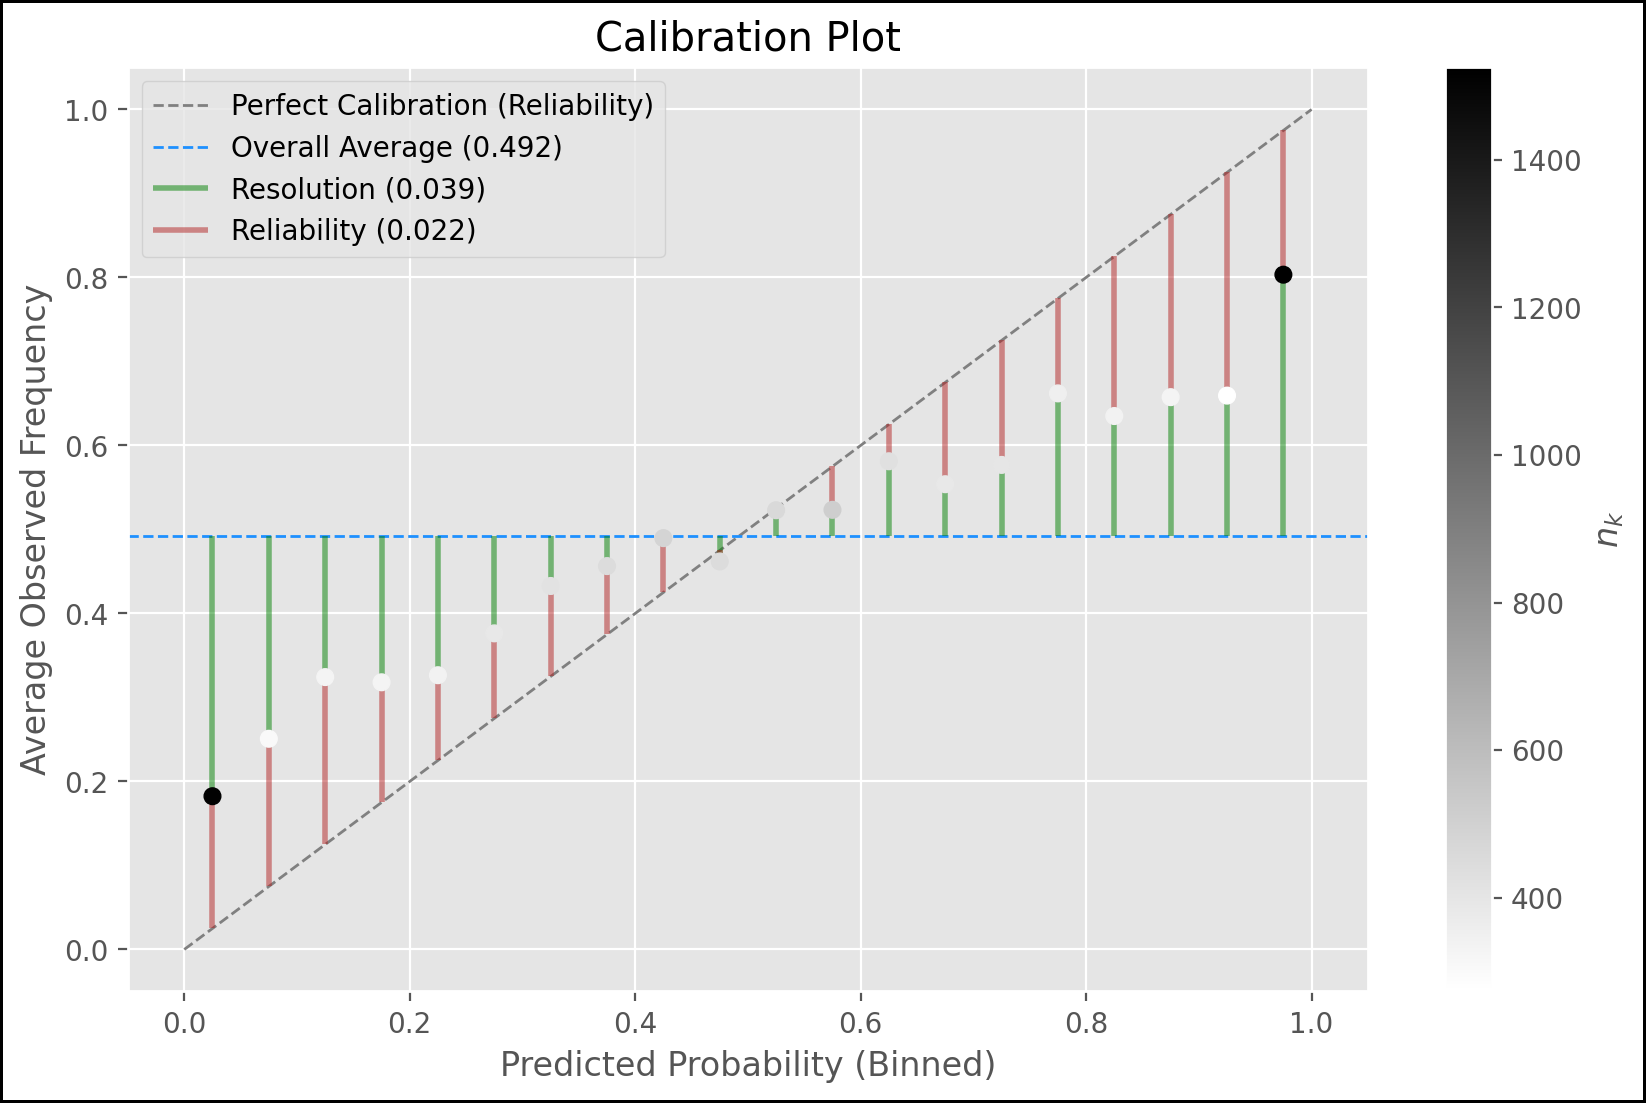

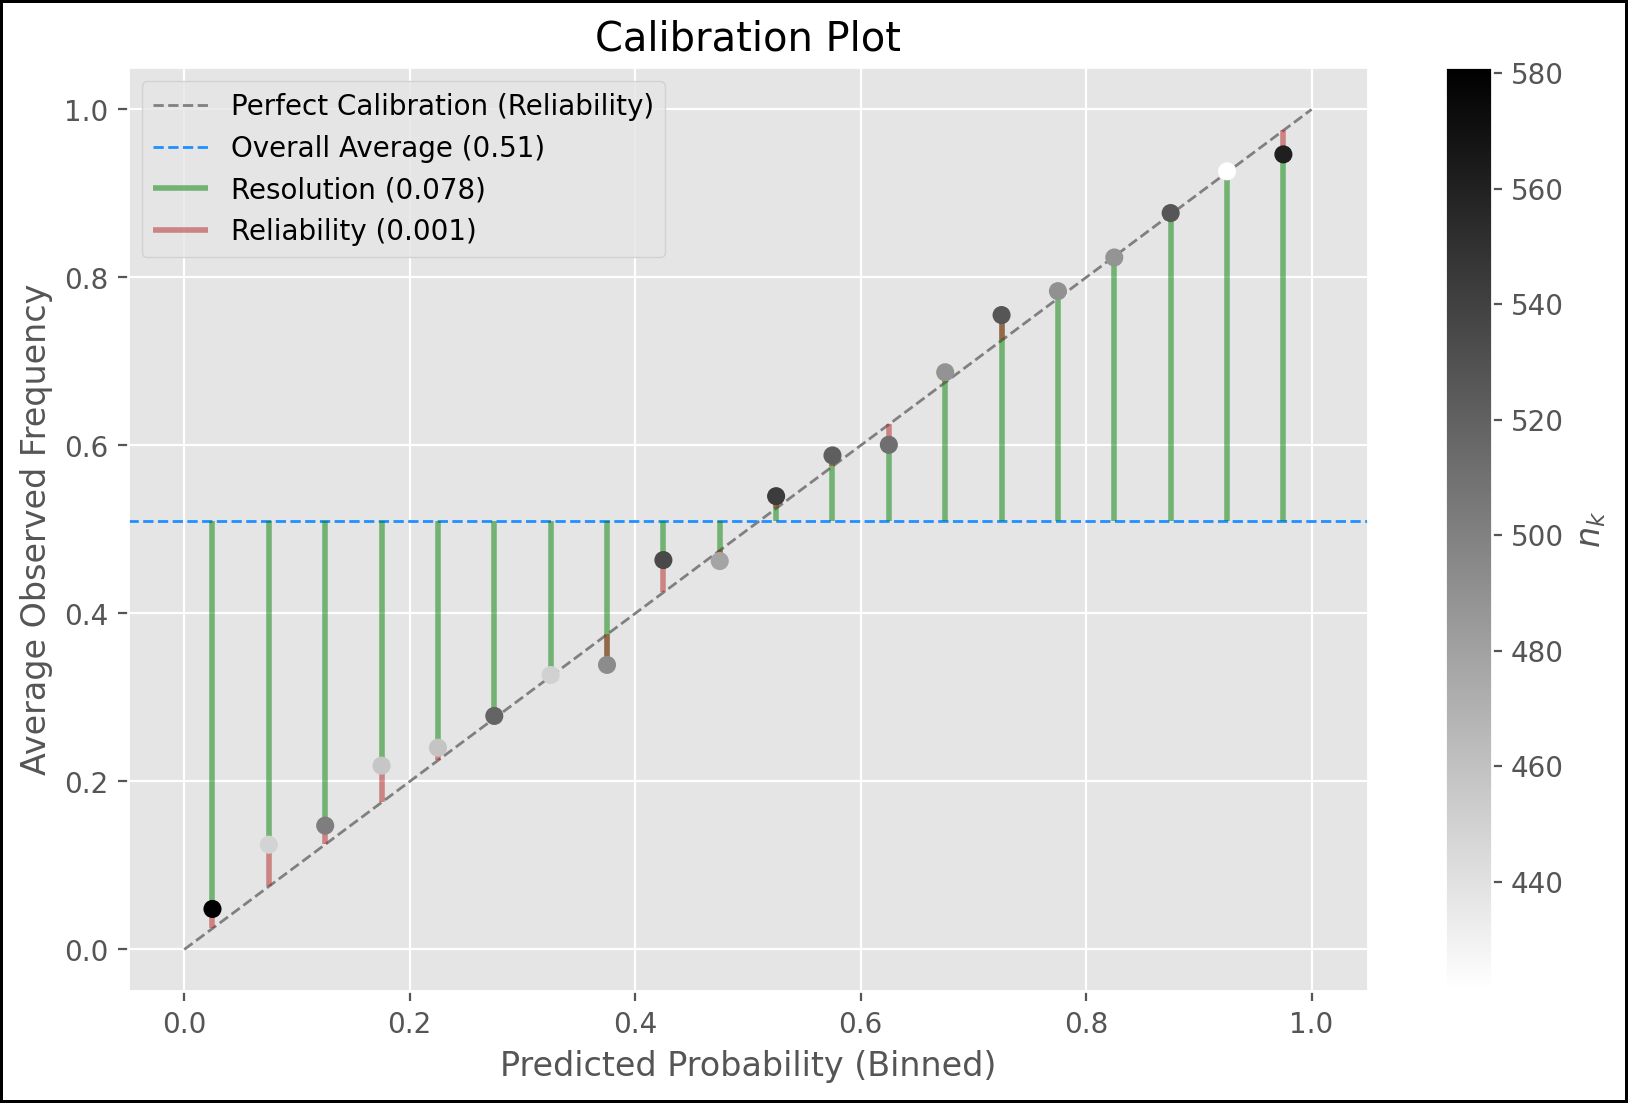

In [203]:
for max_noise in [0.5, 0.1]:
    # Generate Data
    N = 10_000

    observations = []
    predicted_probabilities = []
    for i in range(0, N):
        # Sample a true probability
        true_prob = np.random.uniform(0, 1)

        # Sample from a bernoulli distribution with true_prob as the parameter
        y = np.random.binomial(1, true_prob, 1)[0]

        # Add noise to the true_prob parameter to simulate our noisy estimate
        predicted_prob = np.clip(true_prob + np.random.uniform(-max_noise, max_noise), 0.00001, 0.99999)

        observations.append(y)
        predicted_probabilities.append(predicted_prob)
        
    df = pd.DataFrame({
        "observation": observations,
        'predicted_prob': predicted_probabilities
    })

    step = 0.05
    df = df.assign(
        predicted_prob_bin=pd.cut(df.predicted_prob, bins=np.arange(0, 1 + step, step))
    )

    dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
    dfg.columns = ["_".join(x) for x in dfg.columns]
    dfg = dfg.reset_index()

    plot_calibration(dfg)

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/3287311260.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})


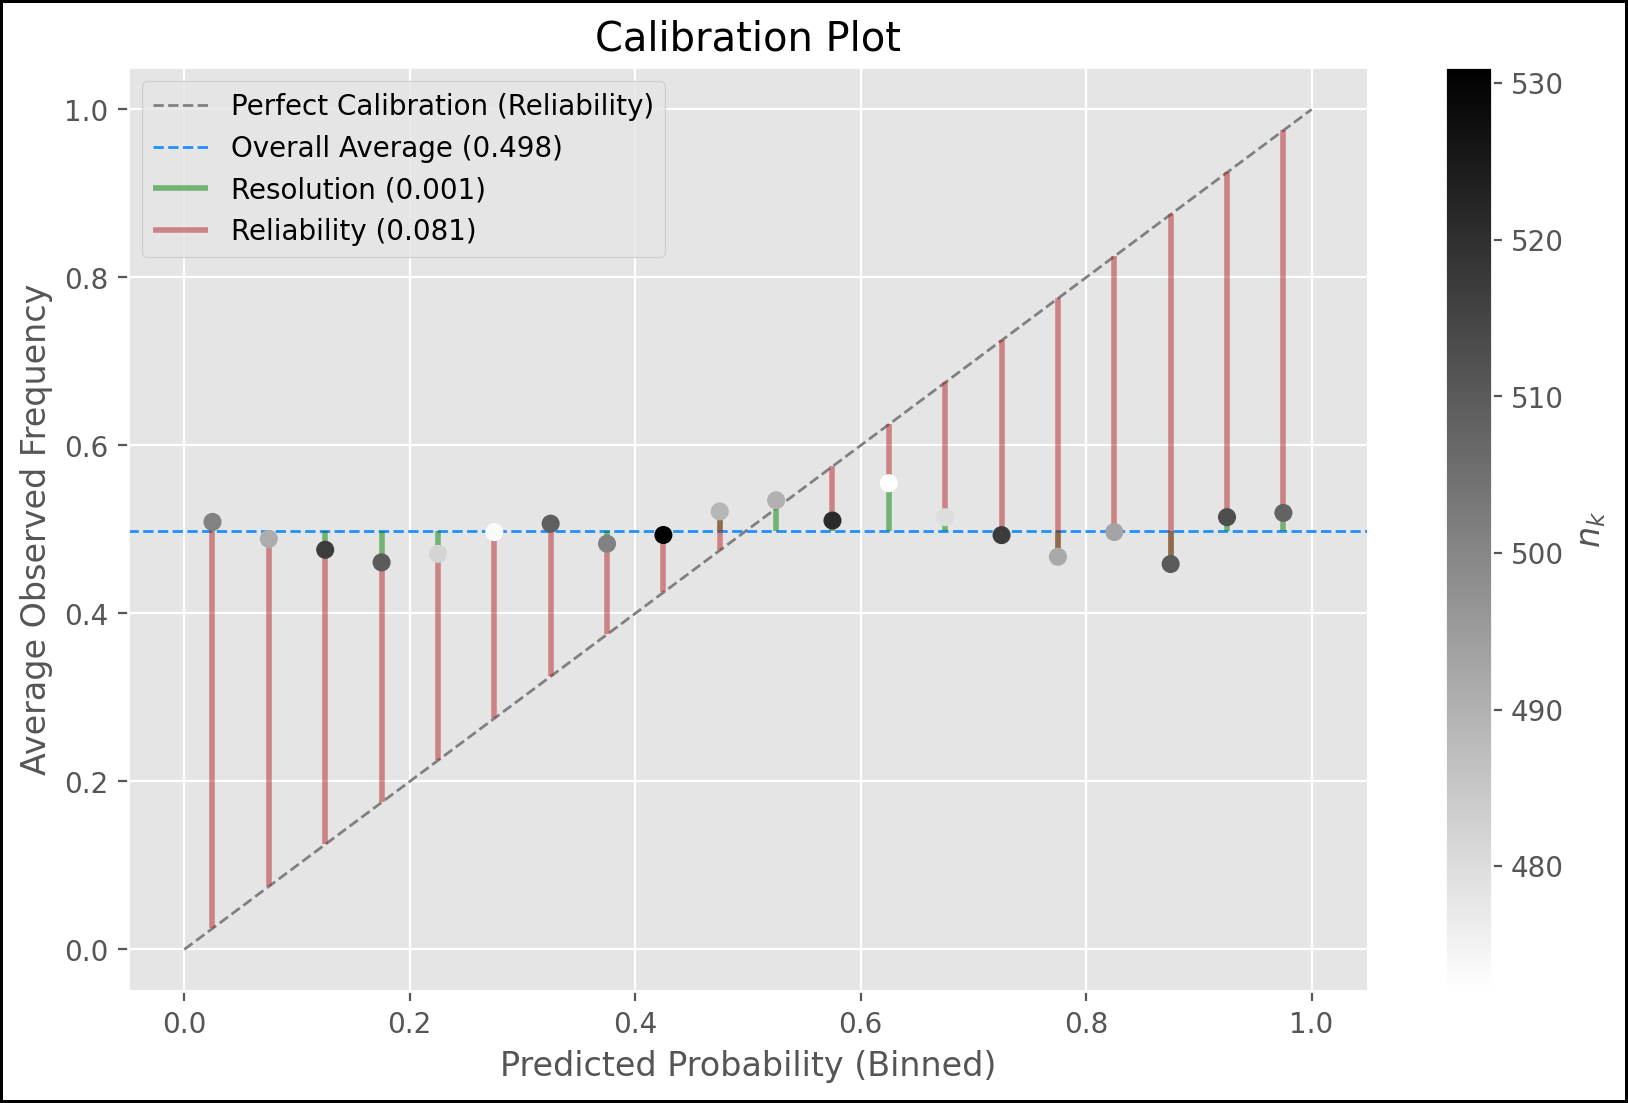

In [202]:

# Generate Data
N = 10_000

observations = []
predicted_probabilities = []
for i in range(0, N):
    # Sample a true probability
    true_prob = np.random.uniform(0, 1)

    # Sample from a bernoulli distribution with true_prob as the parameter
    y = np.random.binomial(1, true_prob, 1)[0]

    # Add noise to the true_prob parameter to simulate our noisy estimate
    predicted_prob = np.random.uniform(0, 1)

    observations.append(y)
    predicted_probabilities.append(predicted_prob)
    
df = pd.DataFrame({
    "observation": observations,
    'predicted_prob': predicted_probabilities
})

step = 0.05
df = df.assign(
    predicted_prob_bin=pd.cut(df.predicted_prob, bins=np.arange(0, 1 + step, step))
)

dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
dfg.columns = ["_".join(x) for x in dfg.columns]
dfg = dfg.reset_index()

plot_calibration(dfg)

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/1774274184.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})


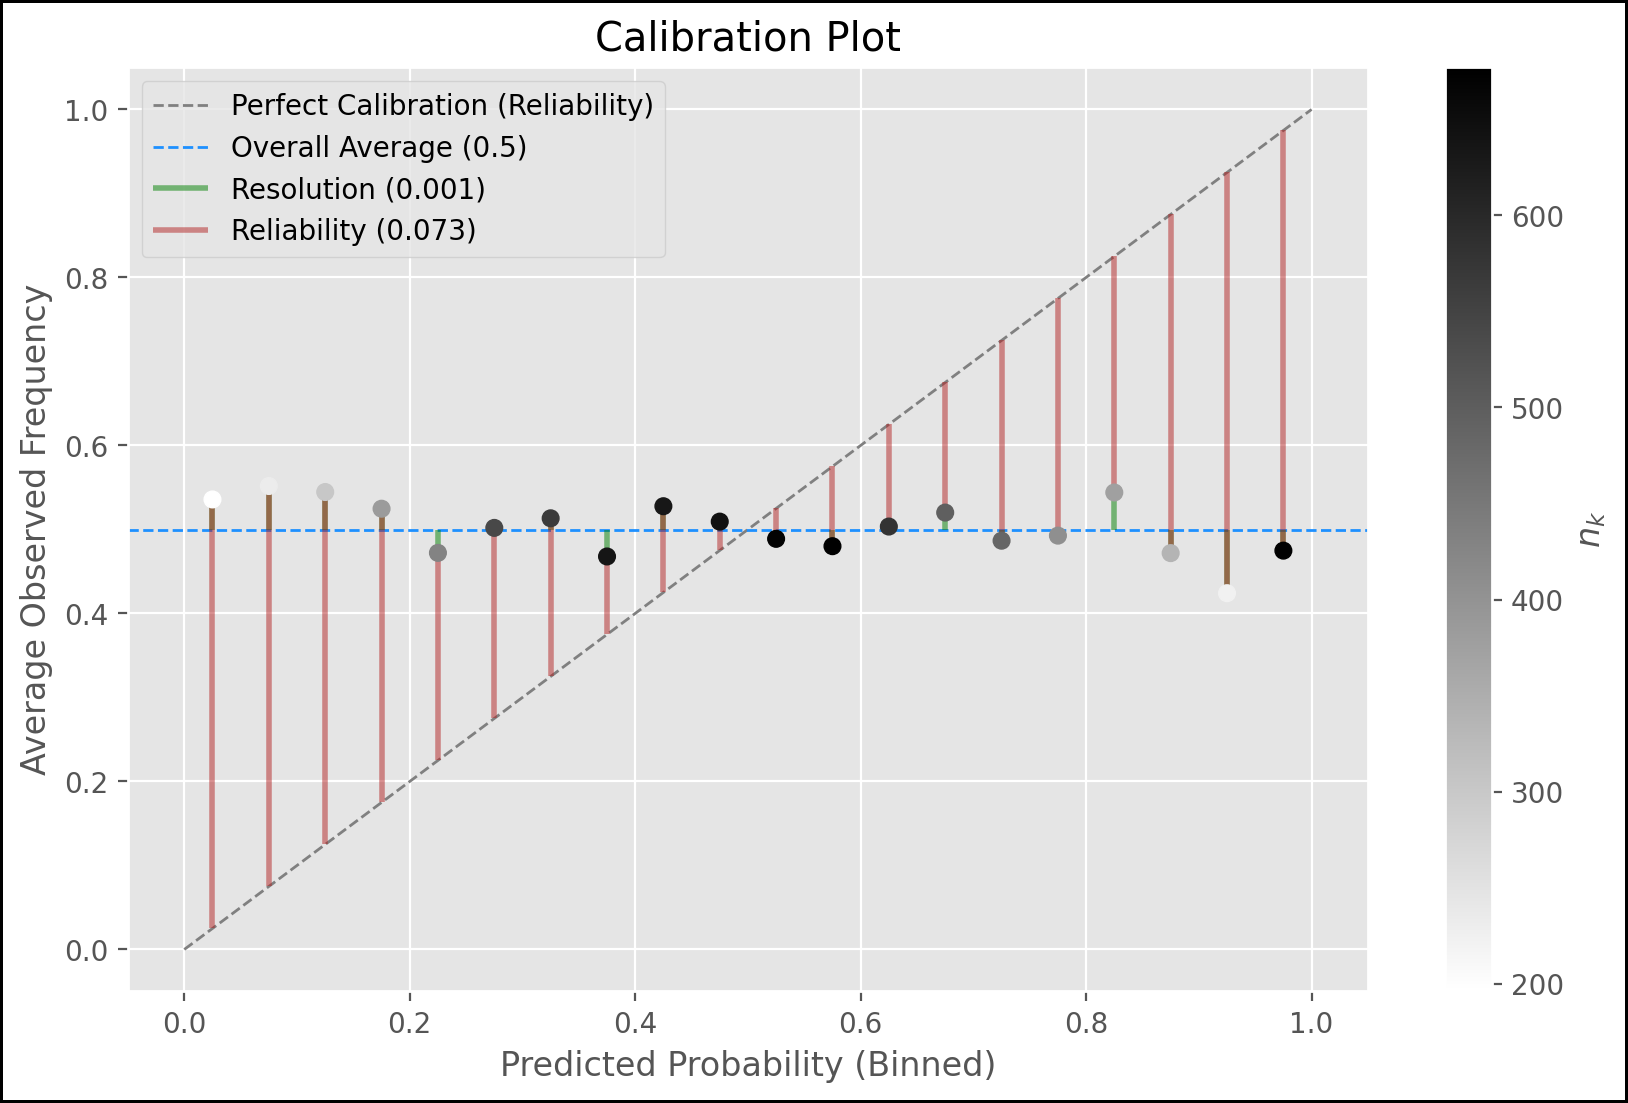

In [6]:

# Generate Data
N = 10_000

observations = []
predicted_probabilities = []
for i in range(0, N):
    # Sample a true probability
    true_prob = np.random.uniform(0, 1)

    # Sample from a bernoulli distribution with true_prob as the parameter
    y = np.random.binomial(1, true_prob, 1)[0]

    # Add noise to the true_prob parameter to simulate our noisy estimate
    predicted_prob = np.clip(np.random.normal(0.5, 0.3), 0, 1)

    observations.append(y)
    predicted_probabilities.append(predicted_prob)
    
df = pd.DataFrame({
    "observation": observations,
    'predicted_prob': predicted_probabilities
})

step = 0.05
df = df.assign(
    predicted_prob_bin=pd.cut(df.predicted_prob, bins=np.arange(0, 1 + step, step))
)

dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
dfg.columns = ["_".join(x) for x in dfg.columns]
dfg = dfg.reset_index()

plot_calibration(dfg)

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/2184068560.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/2184068560.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})


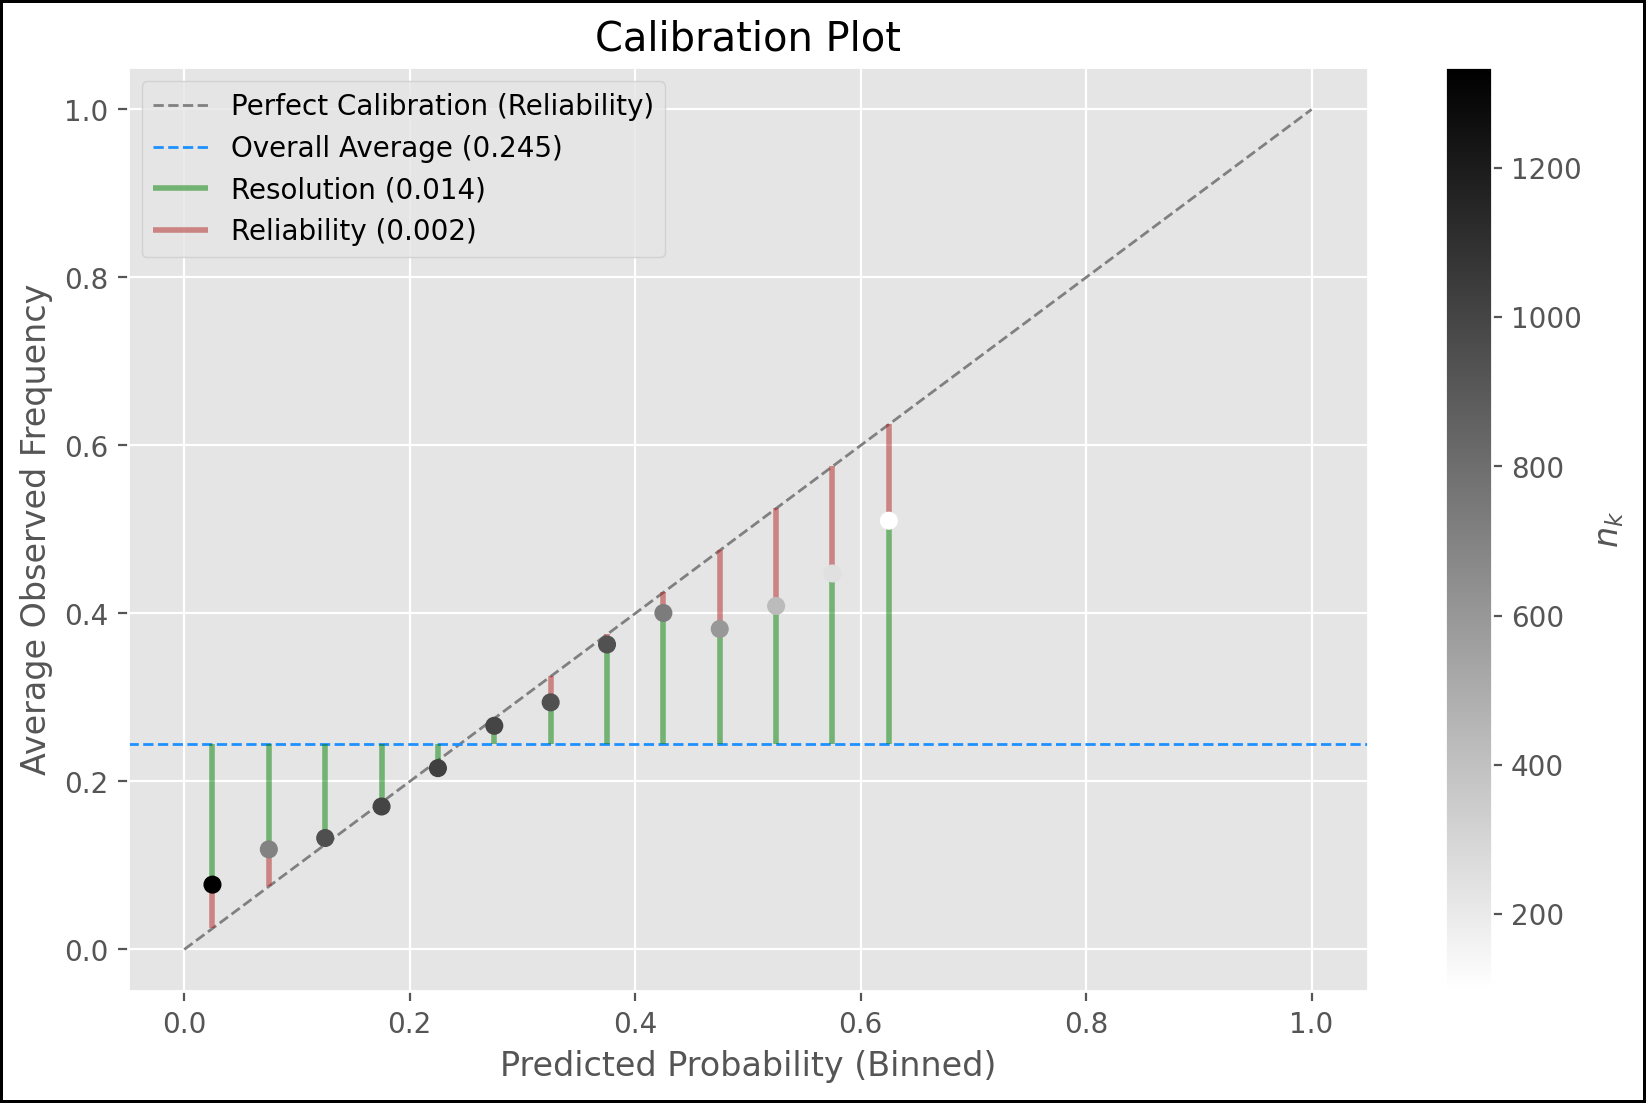

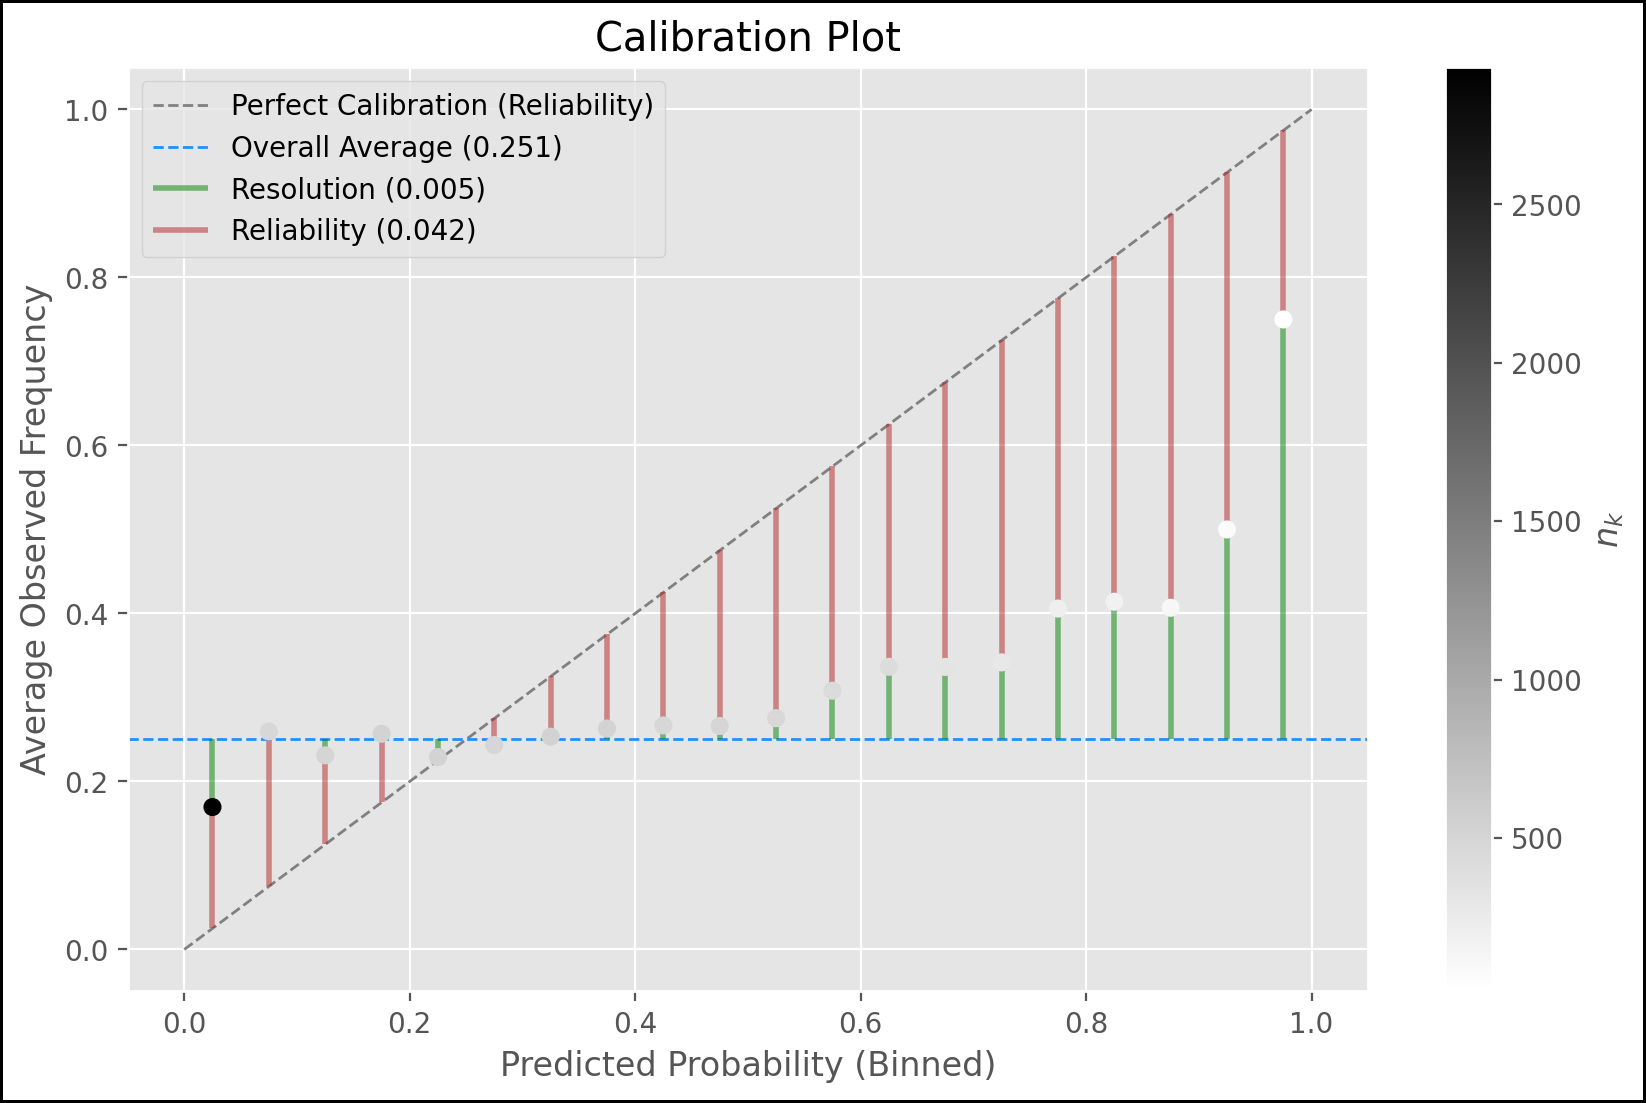

In [7]:
for max_noise in [0.15, 0.5]:
    # Generate Data
    N = 10_000

    observations = []
    predicted_probabilities = []
    for i in range(0, N):
        # Sample a true probability
        true_prob = np.random.uniform(0, 0.5)

        # Sample from a bernoulli distribution with true_prob as the parameter
        y = np.random.binomial(1, true_prob, 1)[0]

        # Add noise to the true_prob parameter to simulate our noisy estimate
        predicted_prob = np.clip(true_prob + np.random.uniform(-max_noise, max_noise), 0.00001, 0.99999)

        observations.append(y)
        predicted_probabilities.append(predicted_prob)
        
    df = pd.DataFrame({
        "observation": observations,
        'predicted_prob': predicted_probabilities
    })

    step = 0.05
    df = df.assign(
        predicted_prob_bin=pd.cut(df.predicted_prob, bins=np.arange(0, 1 + step, step))
    )

    dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
    dfg.columns = ["_".join(x) for x in dfg.columns]
    dfg = dfg.reset_index()
    dfg = dfg.dropna()
    plot_calibration(dfg)

In [8]:
df = df.assign(predicted_prob = df.observation.mean())

step = 0.05
df = df.assign(
    predicted_prob_bin=pd.cut(df.predicted_prob, bins=np.arange(0, 1 + step, step))
)

dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
dfg.columns = ["_".join(x) for x in dfg.columns]
dfg = dfg.reset_index()
dfg = dfg.dropna()

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/3572036196.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})


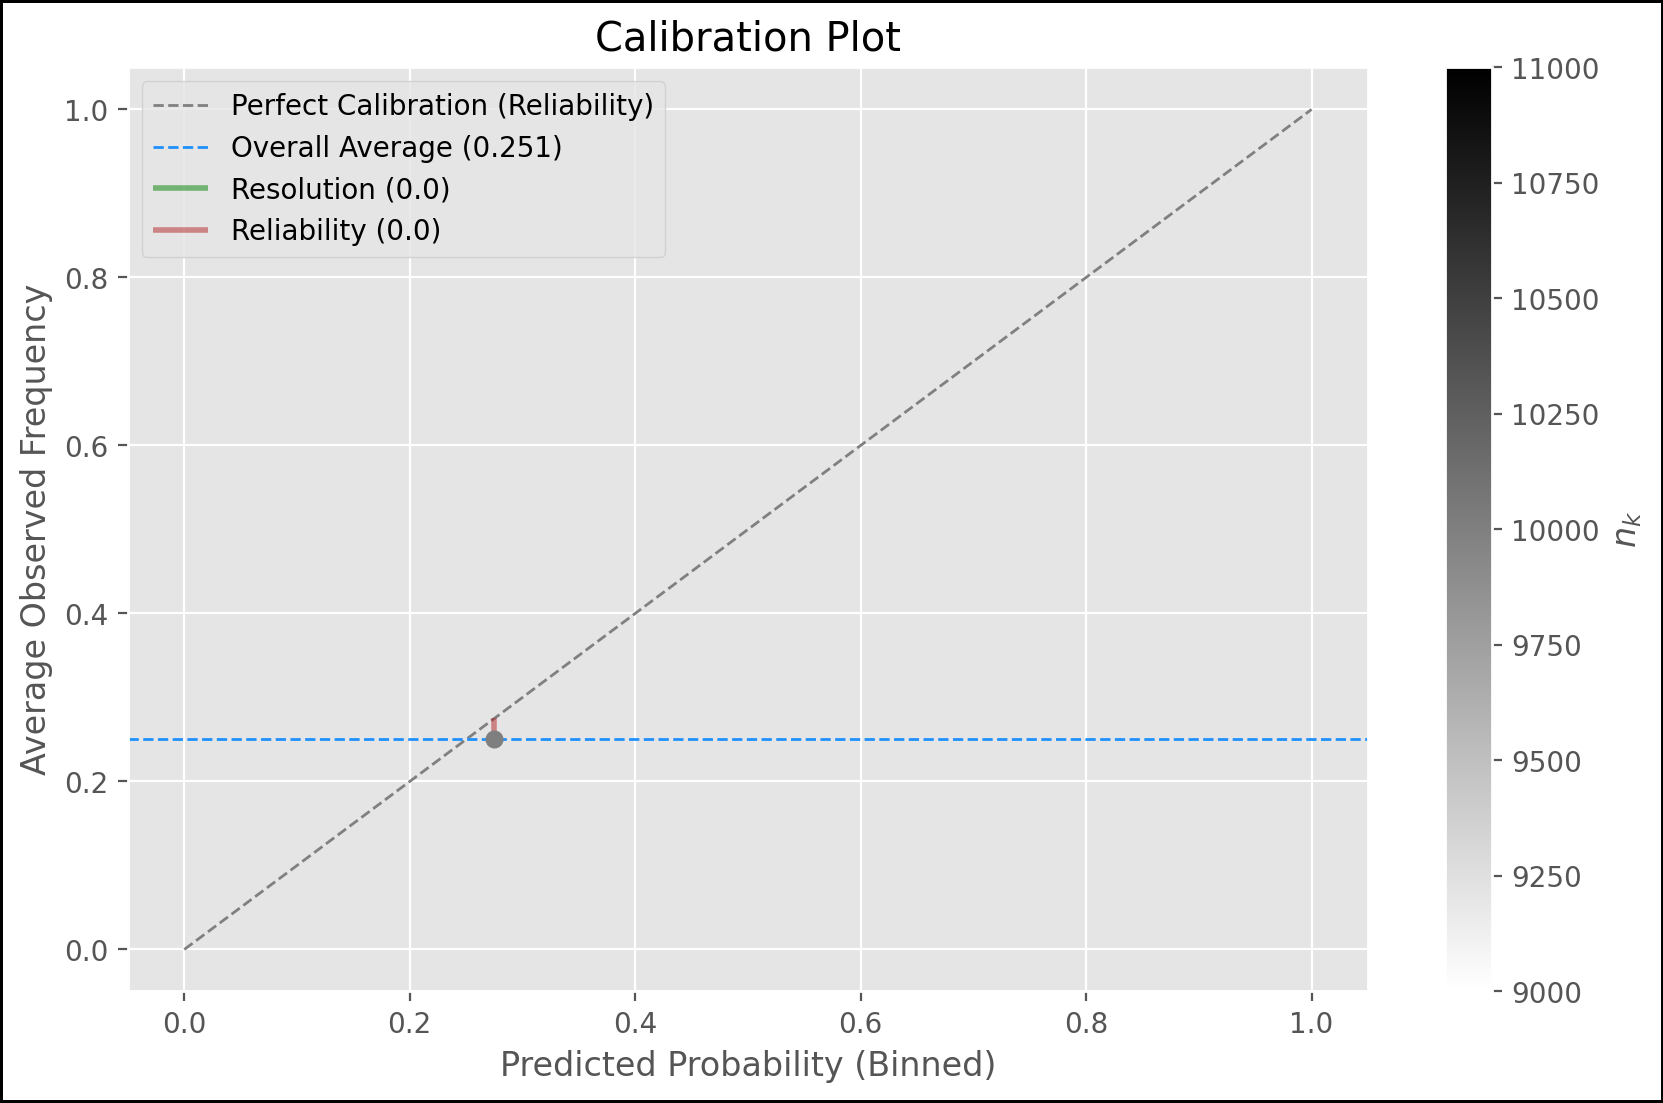

In [9]:
plot_calibration(dfg)

# CRPS Decomposition (as a function of brier score)

In [10]:
df

observation  predicted_prob predicted_prob_bin
0               0          0.2506        (0.25, 0.3]
1               1          0.2506        (0.25, 0.3]
2               0          0.2506        (0.25, 0.3]
3               0          0.2506        (0.25, 0.3]
4               0          0.2506        (0.25, 0.3]
...           ...             ...                ...
9995            0          0.2506        (0.25, 0.3]
9996            1          0.2506        (0.25, 0.3]
9997            0          0.2506        (0.25, 0.3]
9998            0          0.2506        (0.25, 0.3]
9999            0          0.2506        (0.25, 0.3]

[10000 rows x 3 columns]

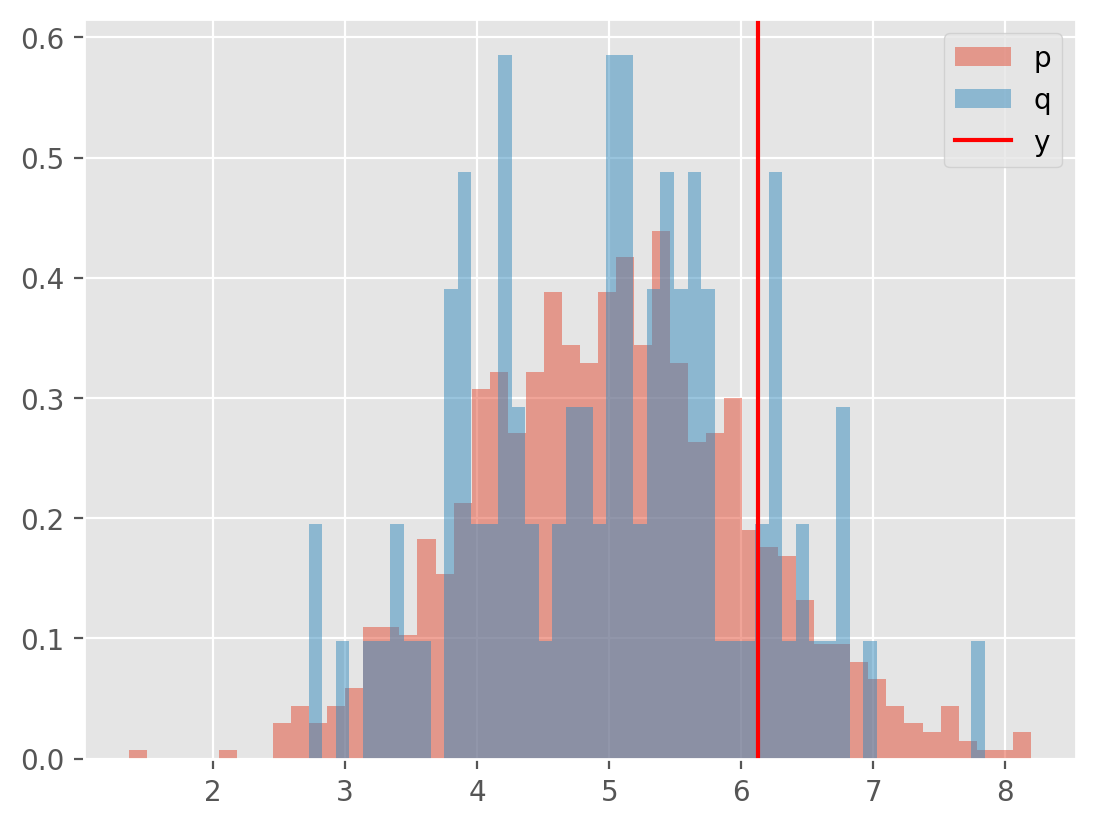

In [311]:
N = 250

p = np.random.normal(5, 1, size=1000)
q = np.random.normal(5, 1, size=(250, 100))

# q = np.stack([q]*N)
y = np.random.choice(p, size=(N, 1))

plt.hist(p, bins=50, alpha=0.5, label='p', density=True)
plt.hist(q[0], bins=50, alpha=0.5, label='q', density=True)

plt.axvline(y[0], 0, 1, label='y', color='red')

plt.legend()
plt.show()

In [312]:
y[:, 0].shape, q.shape

((250,), (250, 100))

In [263]:
ps.crps_ensemble(y[:, 0], q).mean(), crps(y, q).mean()

(0.5995203807784508, 0.5995203807784508)

In [262]:
res = crps_decomposition(y, q).aggregate()
res.crps, res.reliability, res.resolution, res.uncertainty

(0.5995203807784507, 0.016730979816814942, 0.008301431038364337, 0.591090832)

In [275]:
def apply_condition(arr, lower, upper):
    return ((arr >= lower) & (arr < upper))


def crps_integration_of_brier(y, q):
    # WORKING
    bs_list = []
    LOWER = -10
    step = 0.01
    axis = np.arange(LOWER, 20, step)
    for i in axis:
        y_event = apply_condition(y, LOWER, i + step).mean(axis=1)
        q_event = apply_condition(q, LOWER, i + step).mean(axis=1)
        bs = brier_score_loss(y_event, q_event)
        bs_list.append(bs * step)

    return sum(bs_list), bs_list, axis

In [276]:
res, bs_list, axis = crps_integration_of_brier(y, q)
res

0.5995520319999996

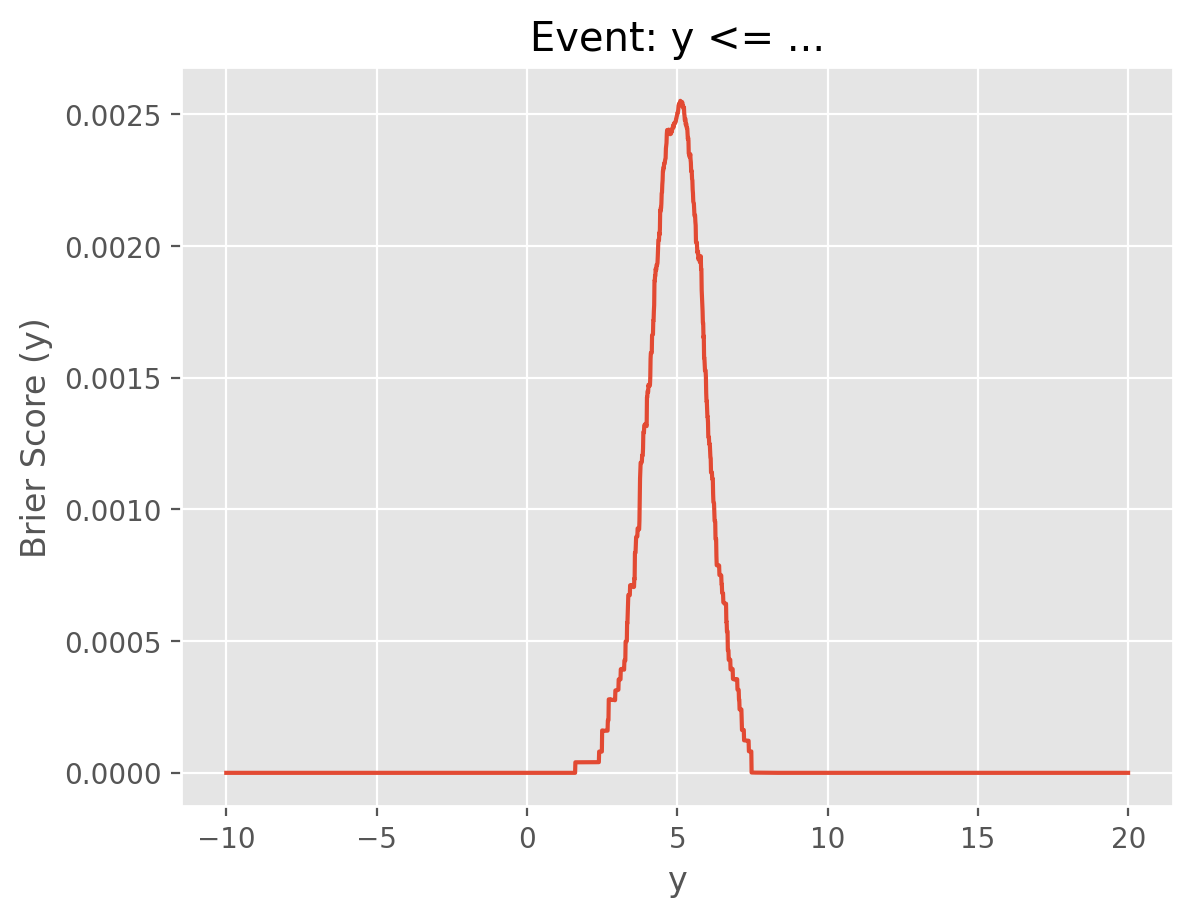

In [277]:
plt.plot(axis, bs_list)
plt.xlabel('y')
plt.ylabel('Brier Score (y)')
plt.title('Event: y <= ...')
plt.show()

In [302]:
def crps_integration_of_brier(y, q):
    # WORKING
    bs_list = []
    LOWER = -10
    step = 1
    axis = np.arange(LOWER, 20, step)
    for i in axis:
        y_event_mean = apply_condition(y, LOWER, i + step).mean(axis=1)
        q_event_mean = apply_condition(q, LOWER, i + step).mean(axis=1)
        bs = brier_score_loss(y_event_mean, q_event_mean)
        bs_list.append(bs * step)




        df = pd.DataFrame({'observation': y_event_mean, 'predicted_prob': q_event_mean})
        step = 0.05
        df = df.assign(predicted_prob_bin=pd.cut(df.predicted_prob, bins=np.arange(0, 1 + step, step)))
        df = df.dropna()
        if len(df) == 0:
            continue

        dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
        dfg.columns = ["_".join(x) for x in dfg.columns]
        dfg = dfg.reset_index()


        bs = brier_score_loss(y_event_mean, q_event_mean) 
        bs_list.append(bs)

        plot_calibration(dfg.dropna(), title=f'Event: y <= {i}')



    return sum(bs_list), bs_list, axis

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/3319075963.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/3319075963.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/3319075963.py:23: FutureWarning: The default of observed=False is deprecated an

0.6250234200000001

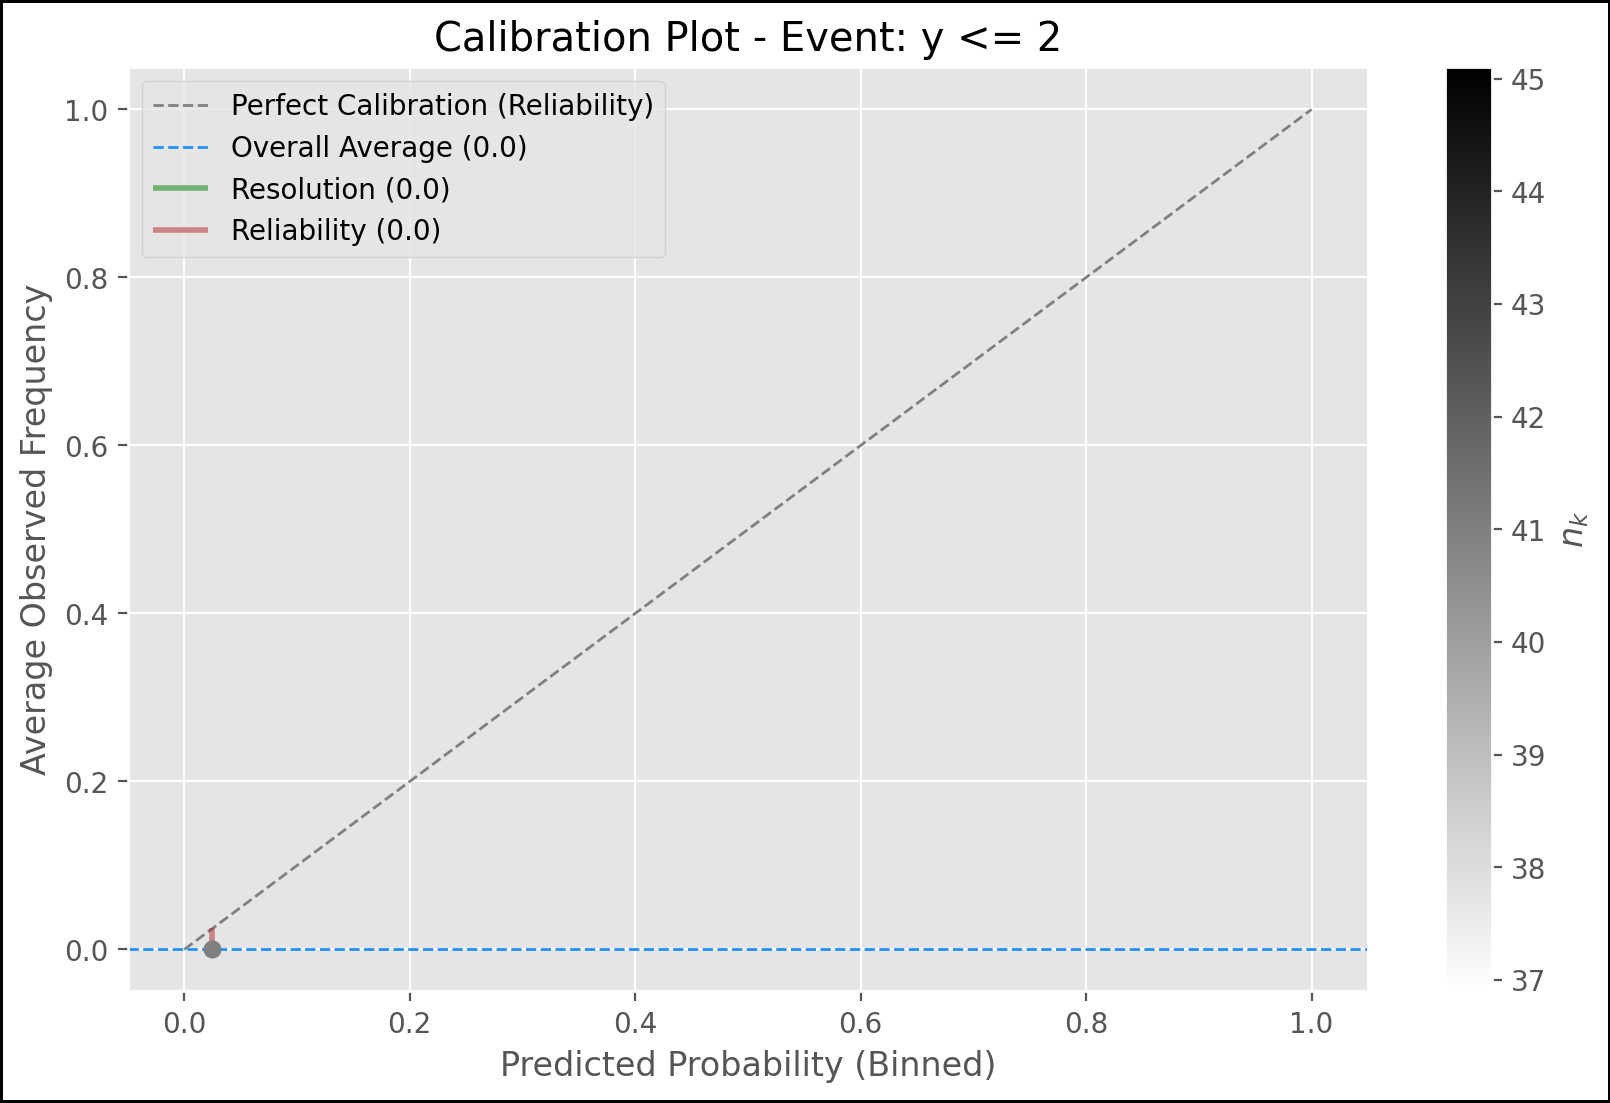

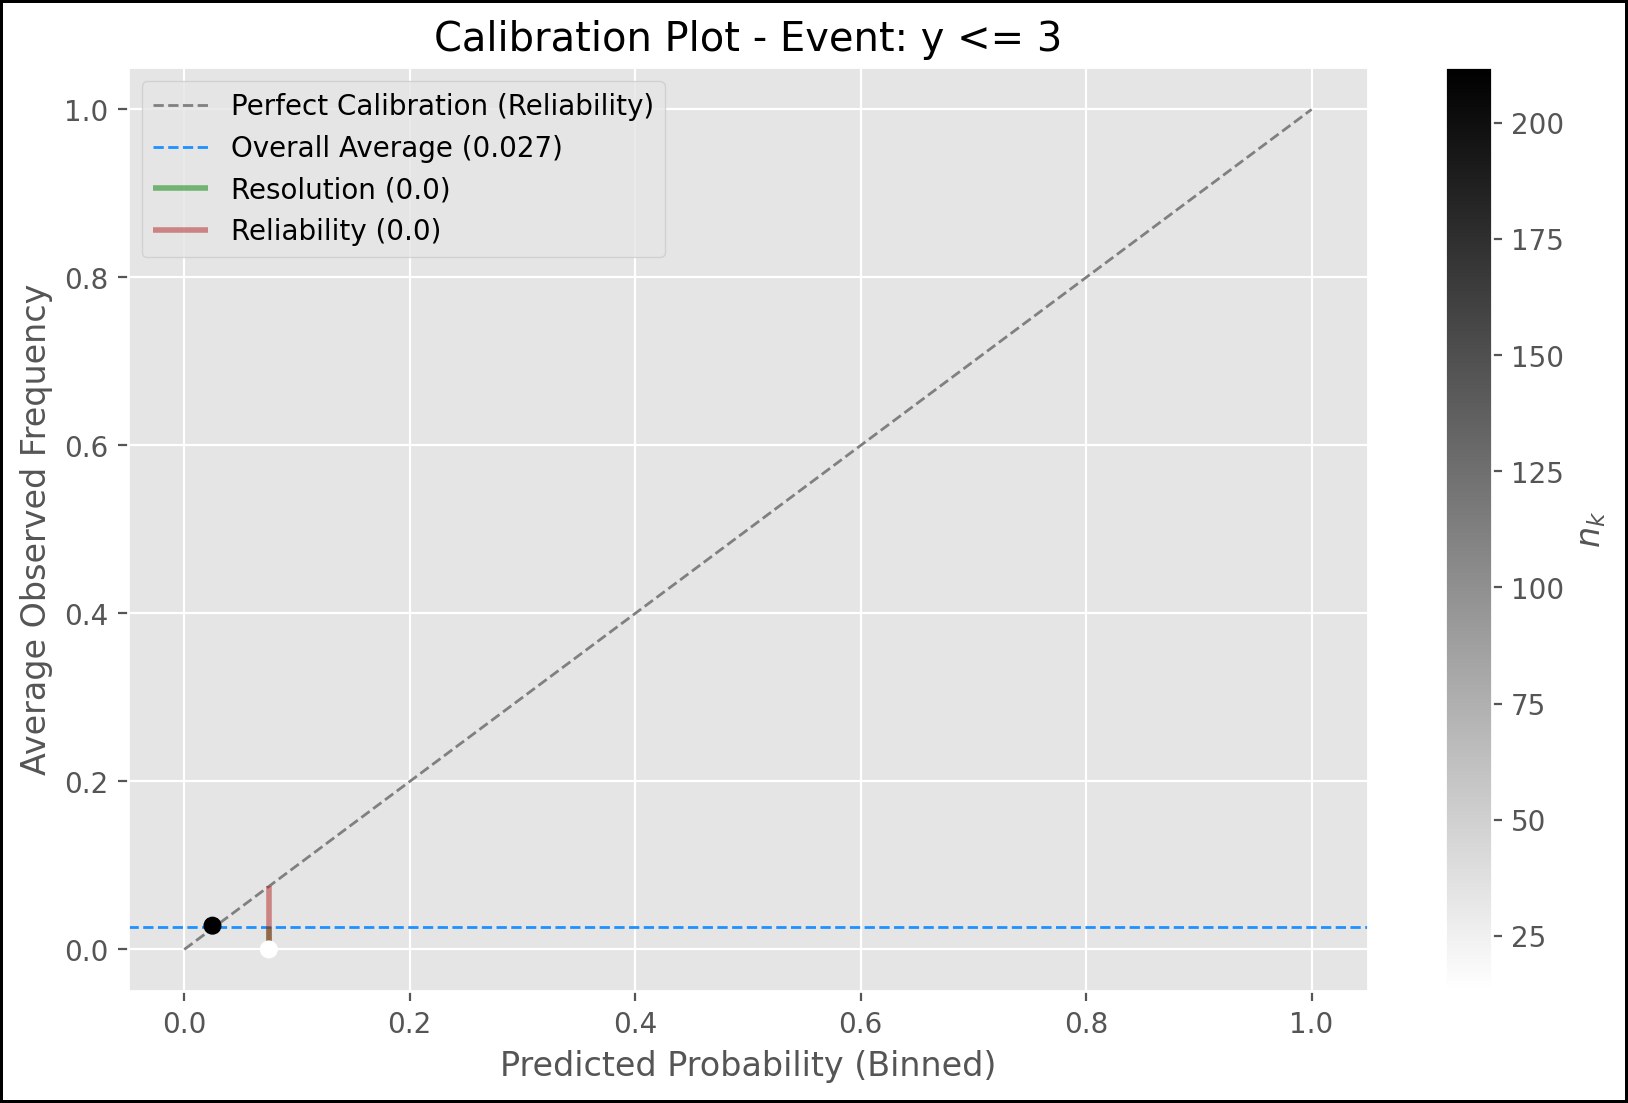

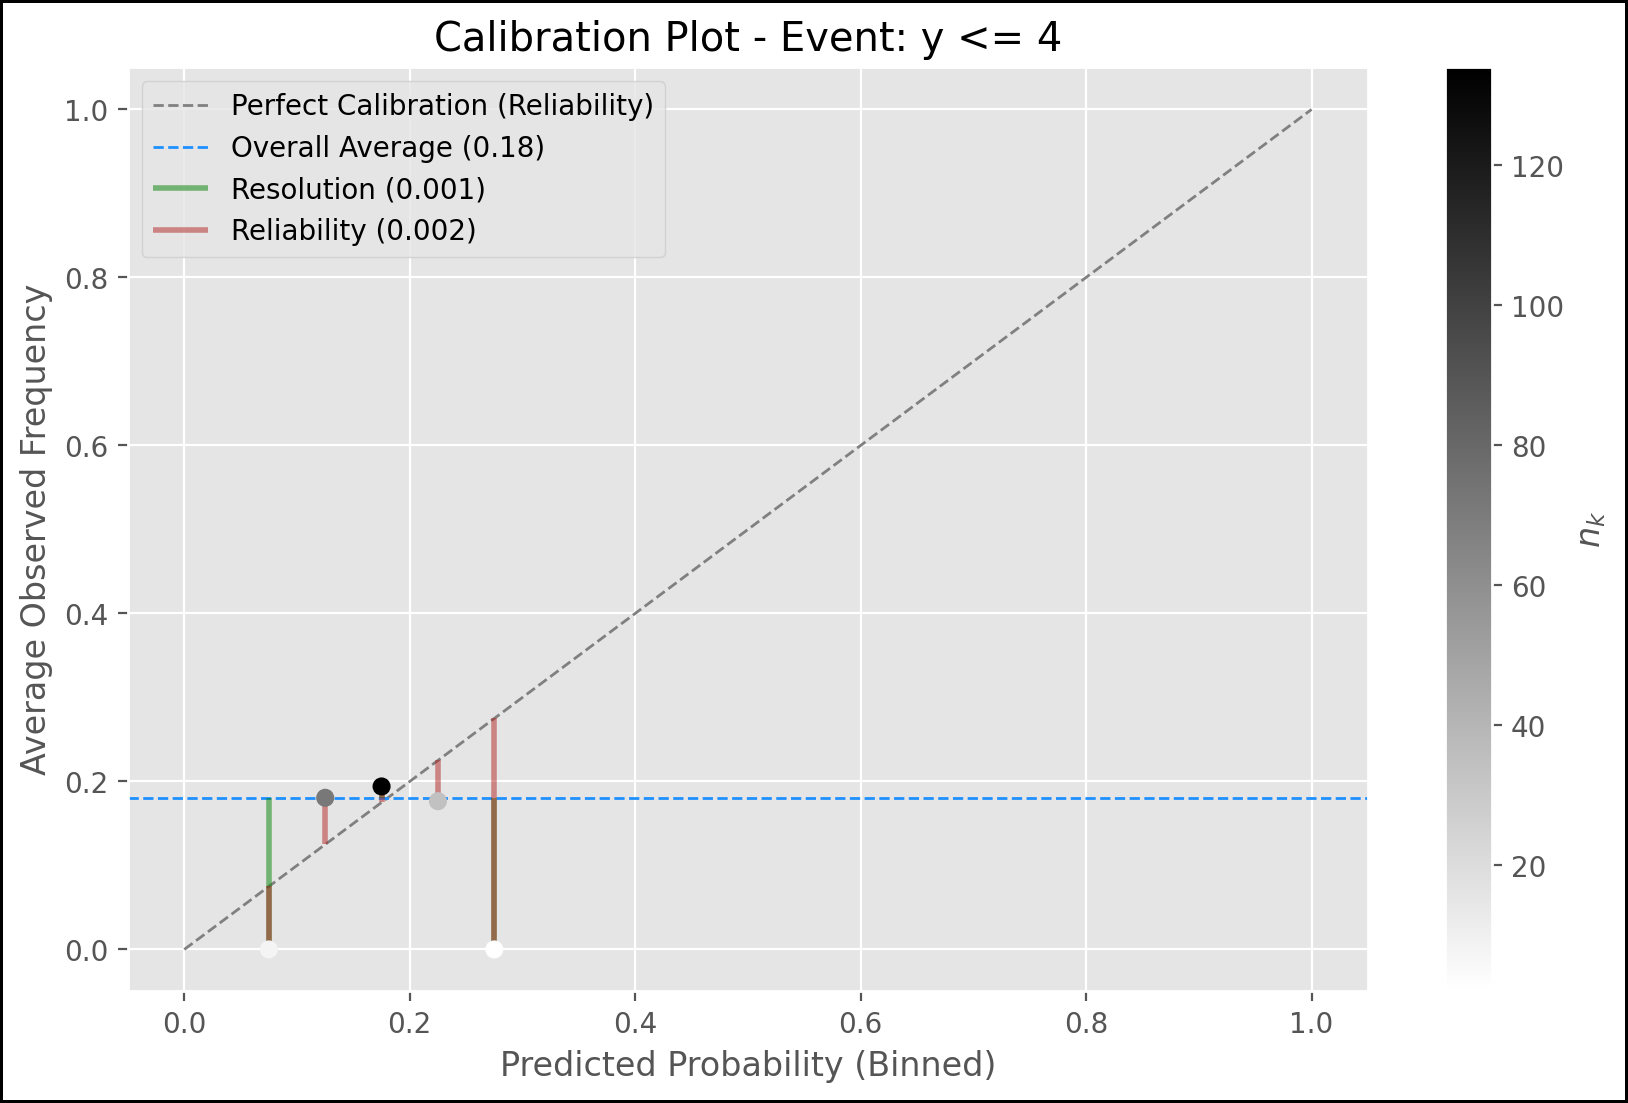

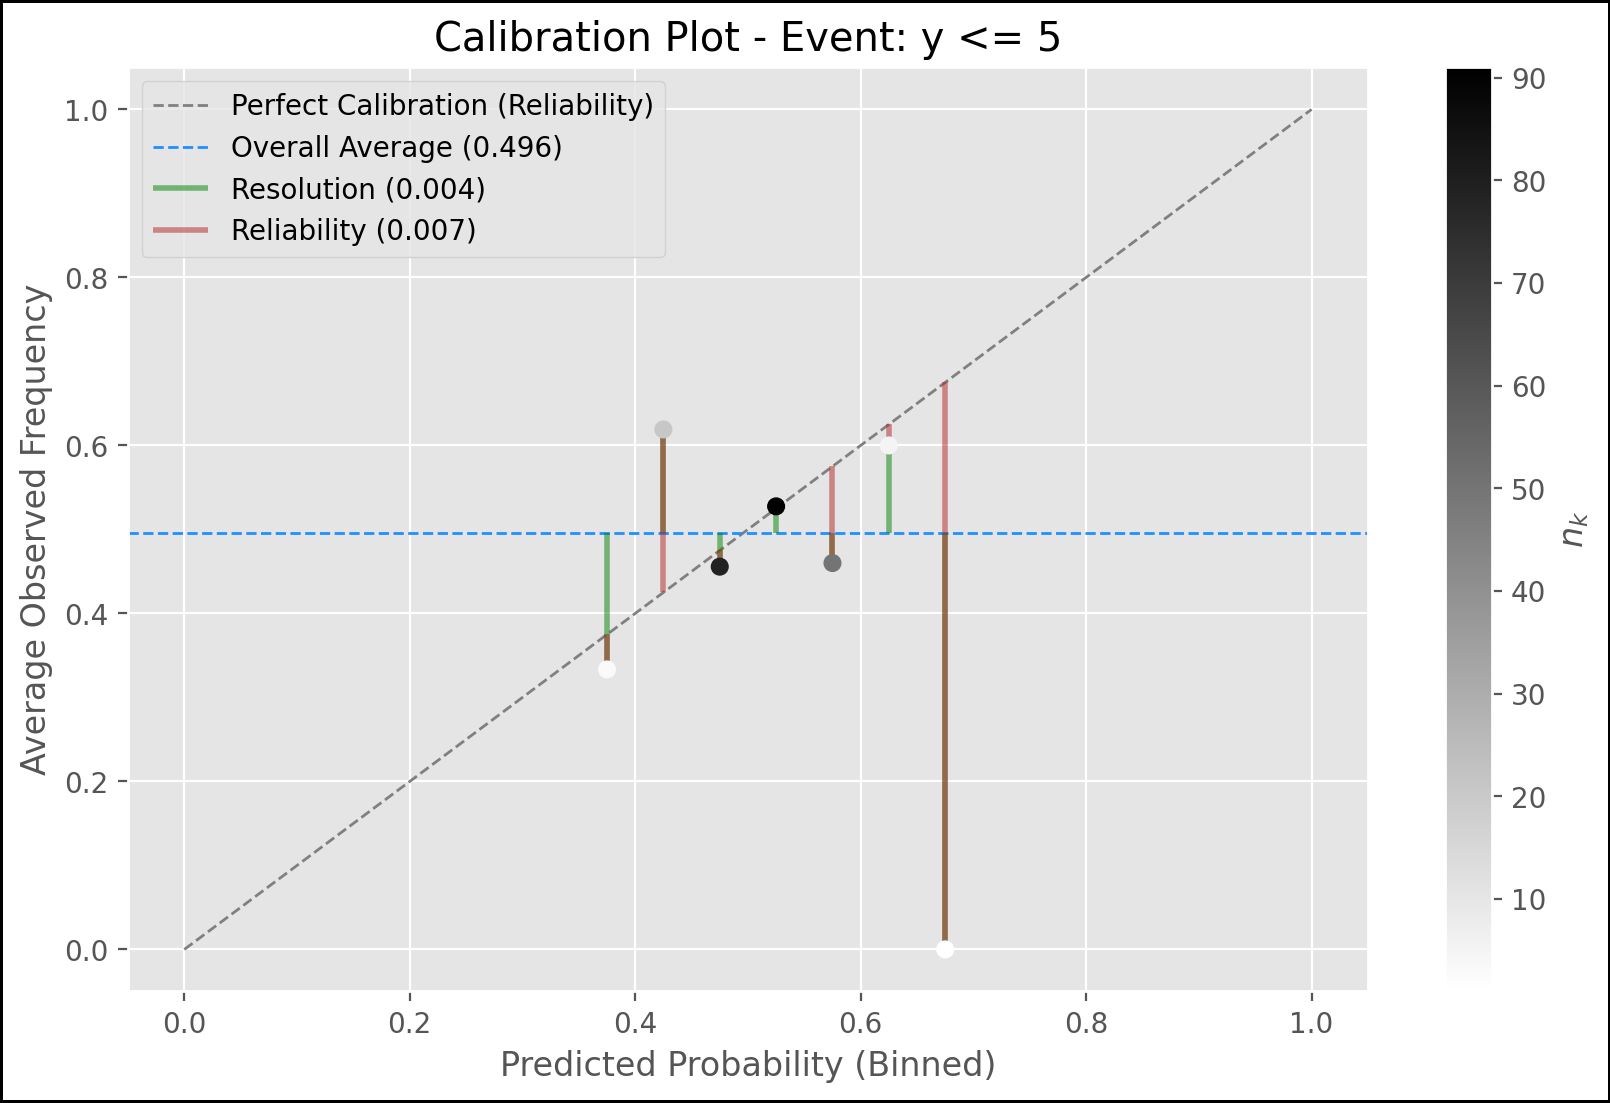

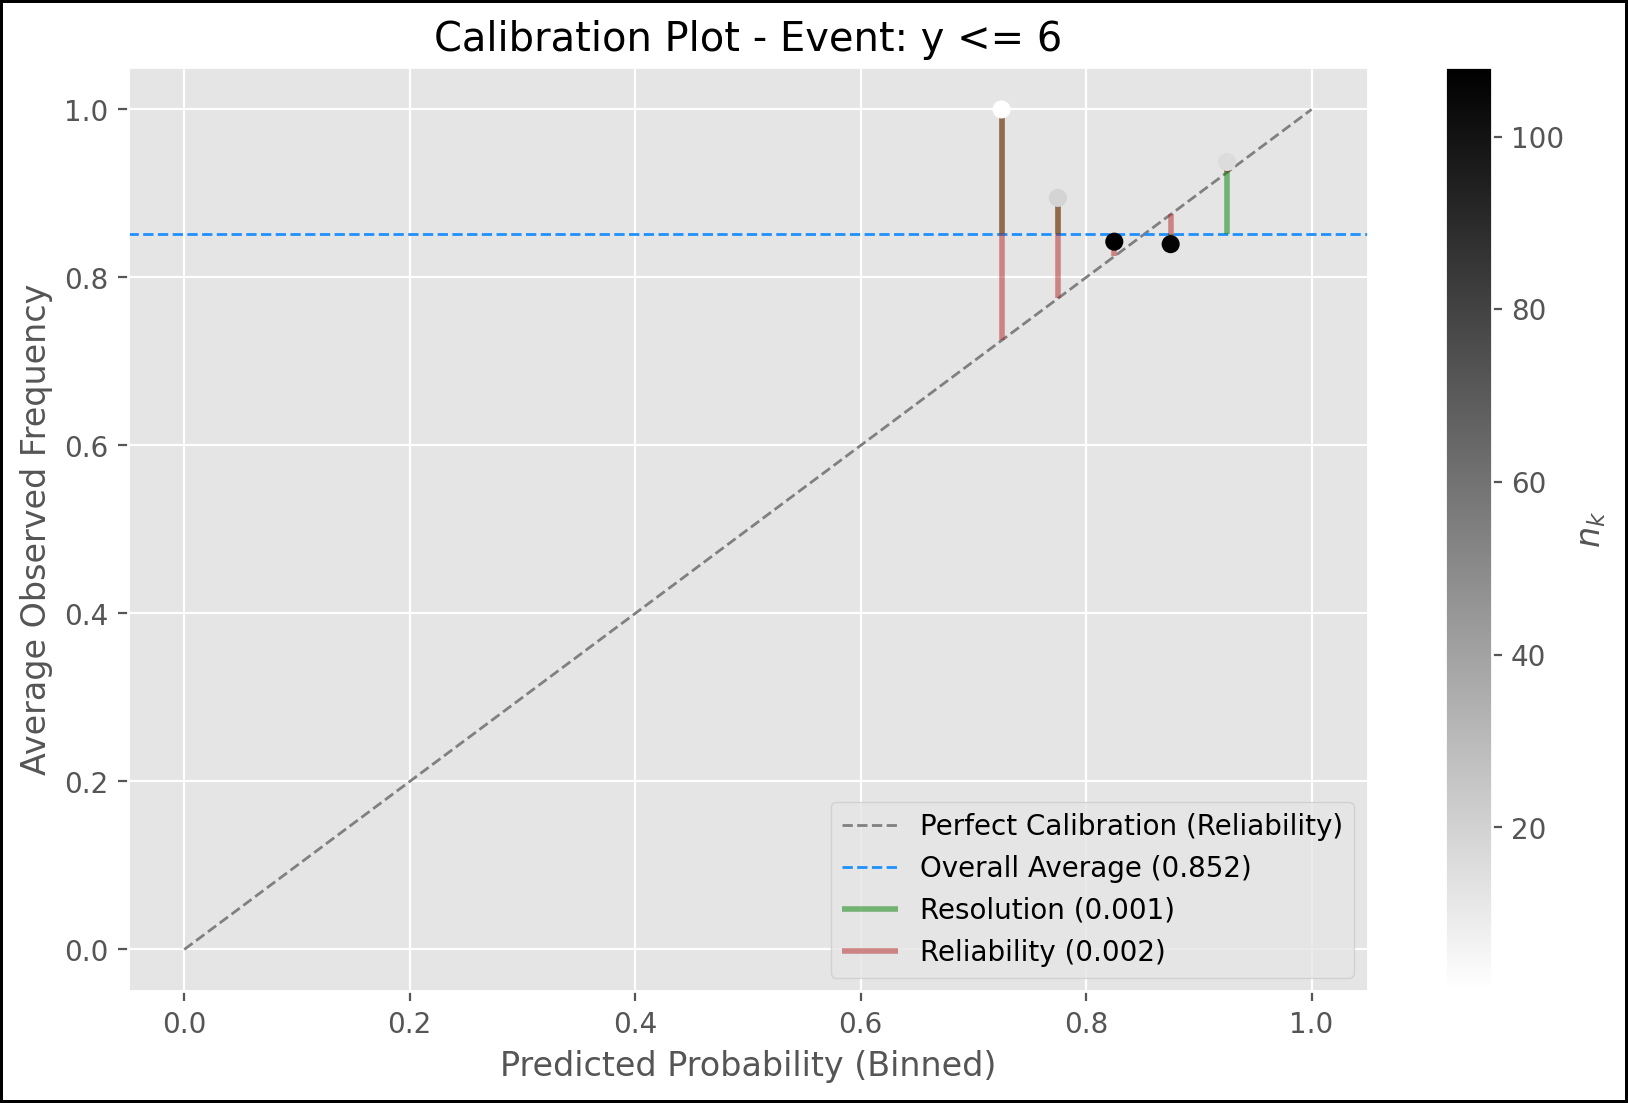

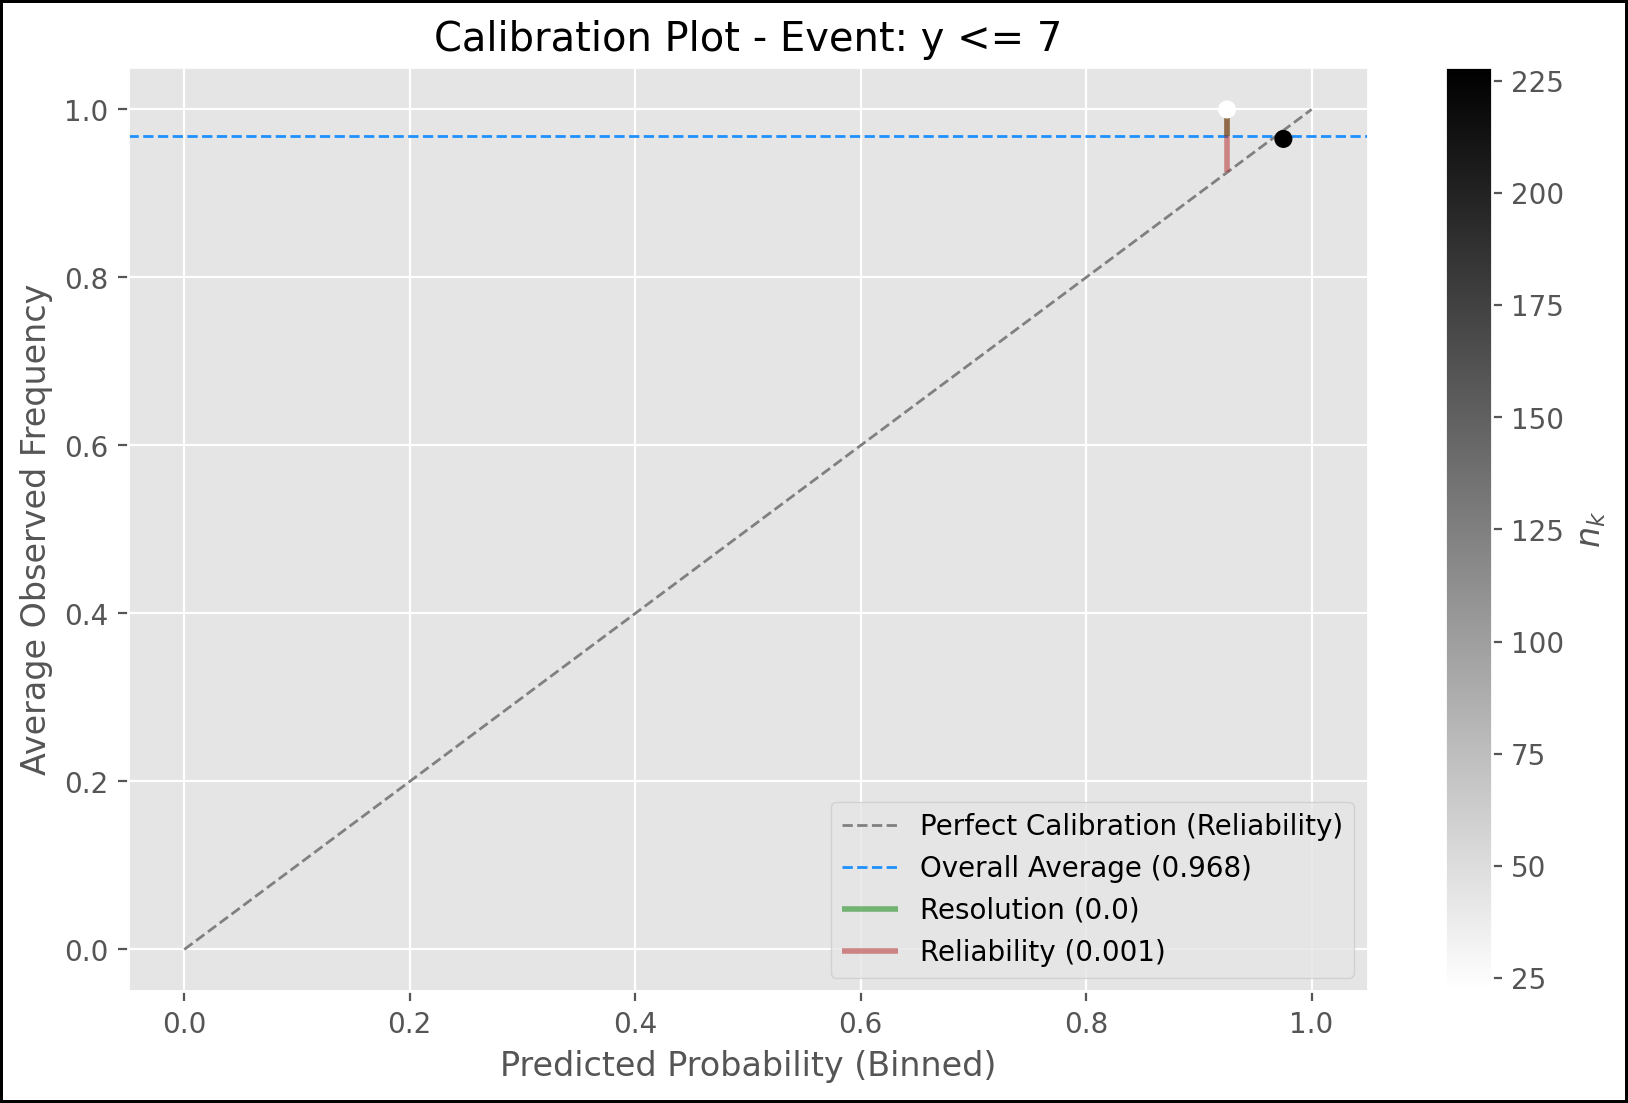

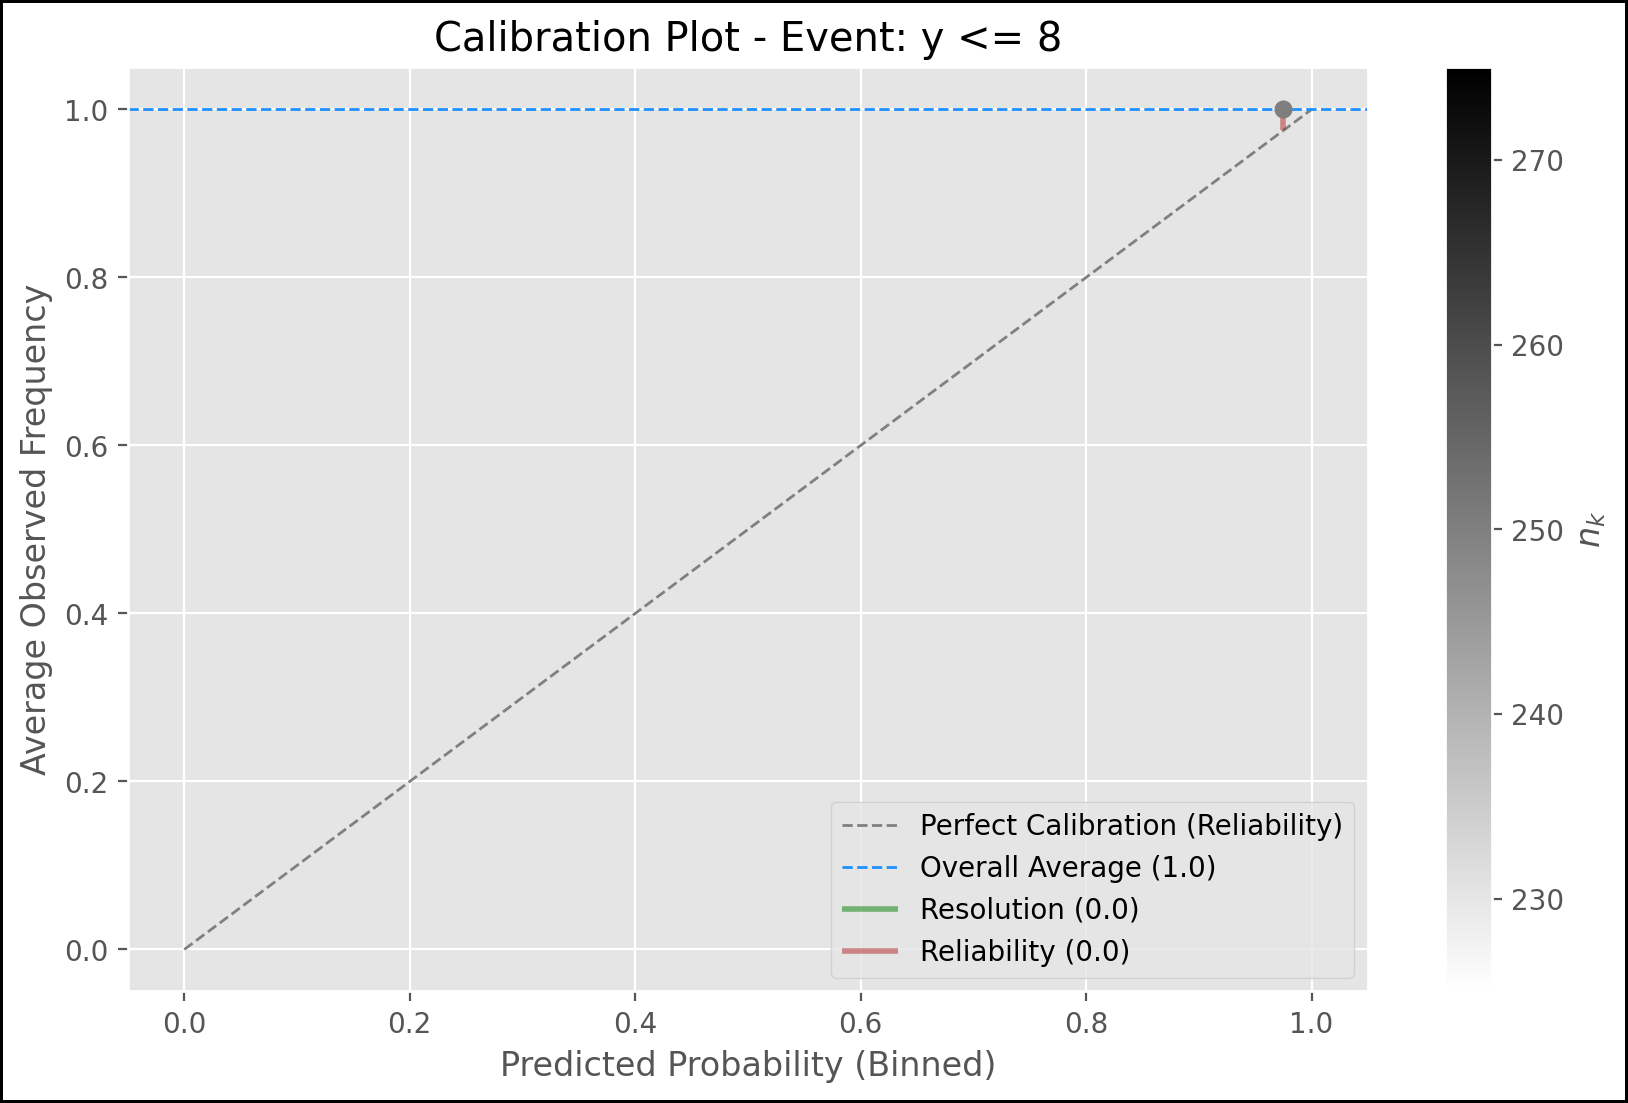

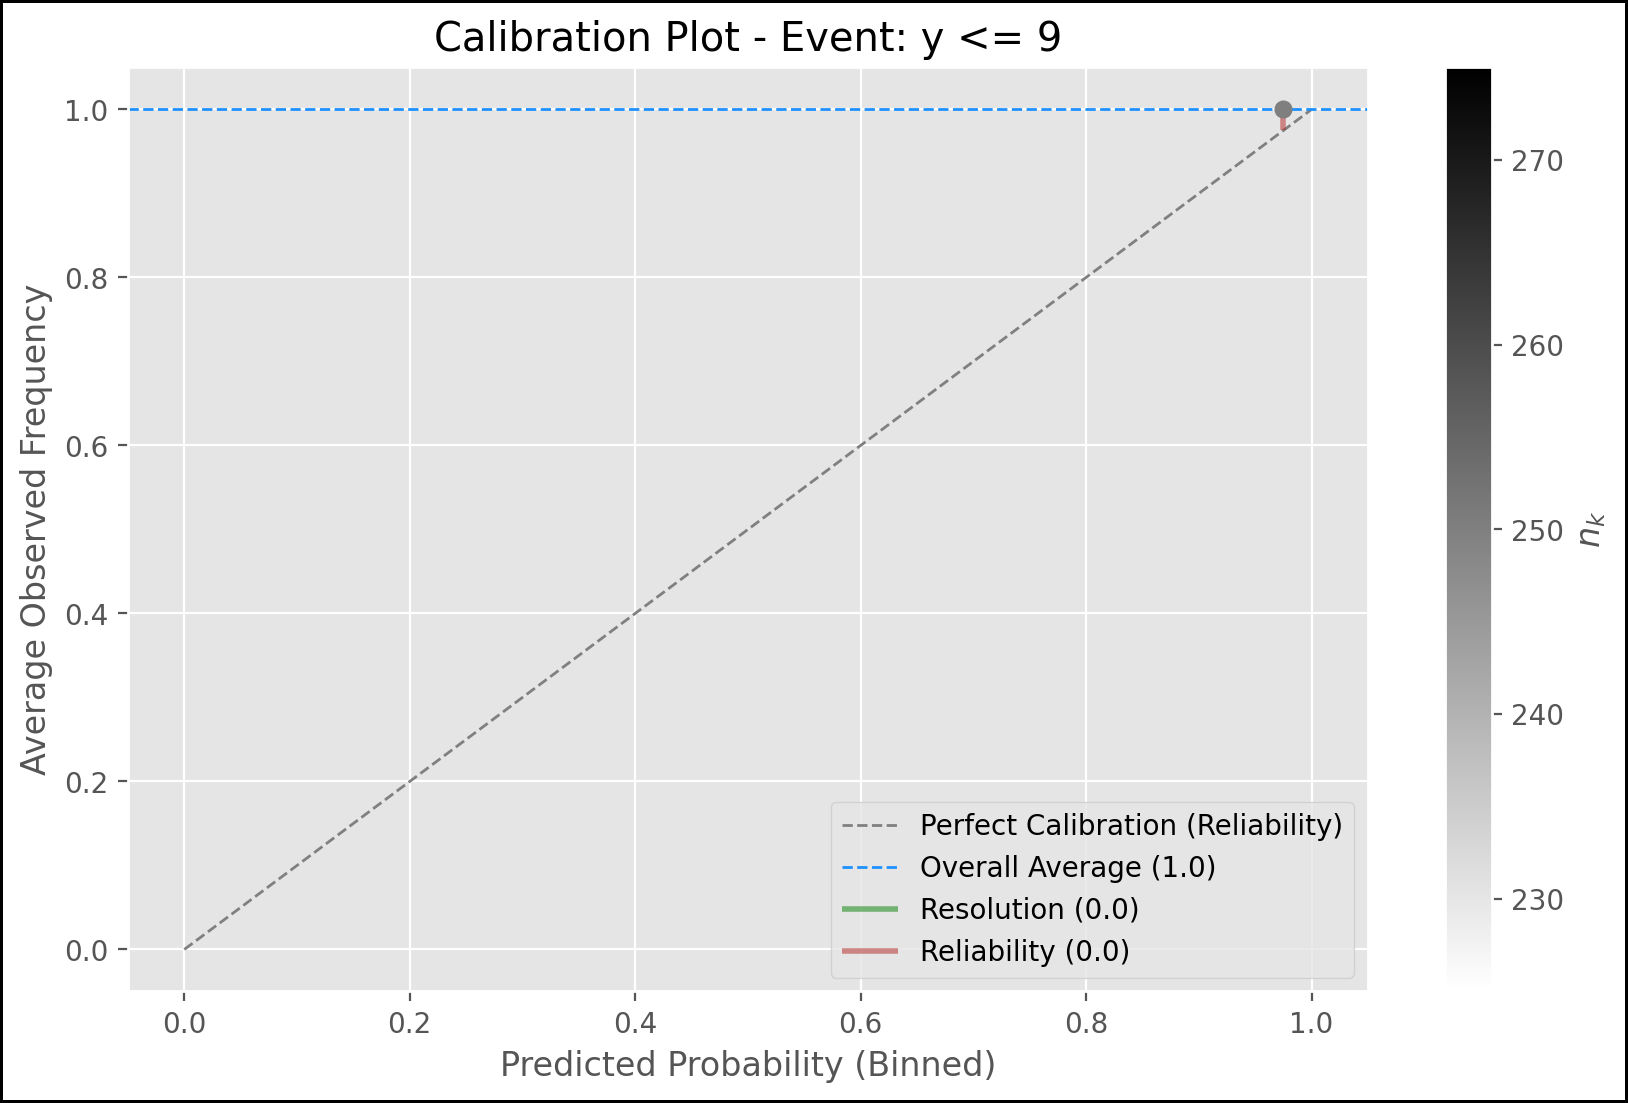

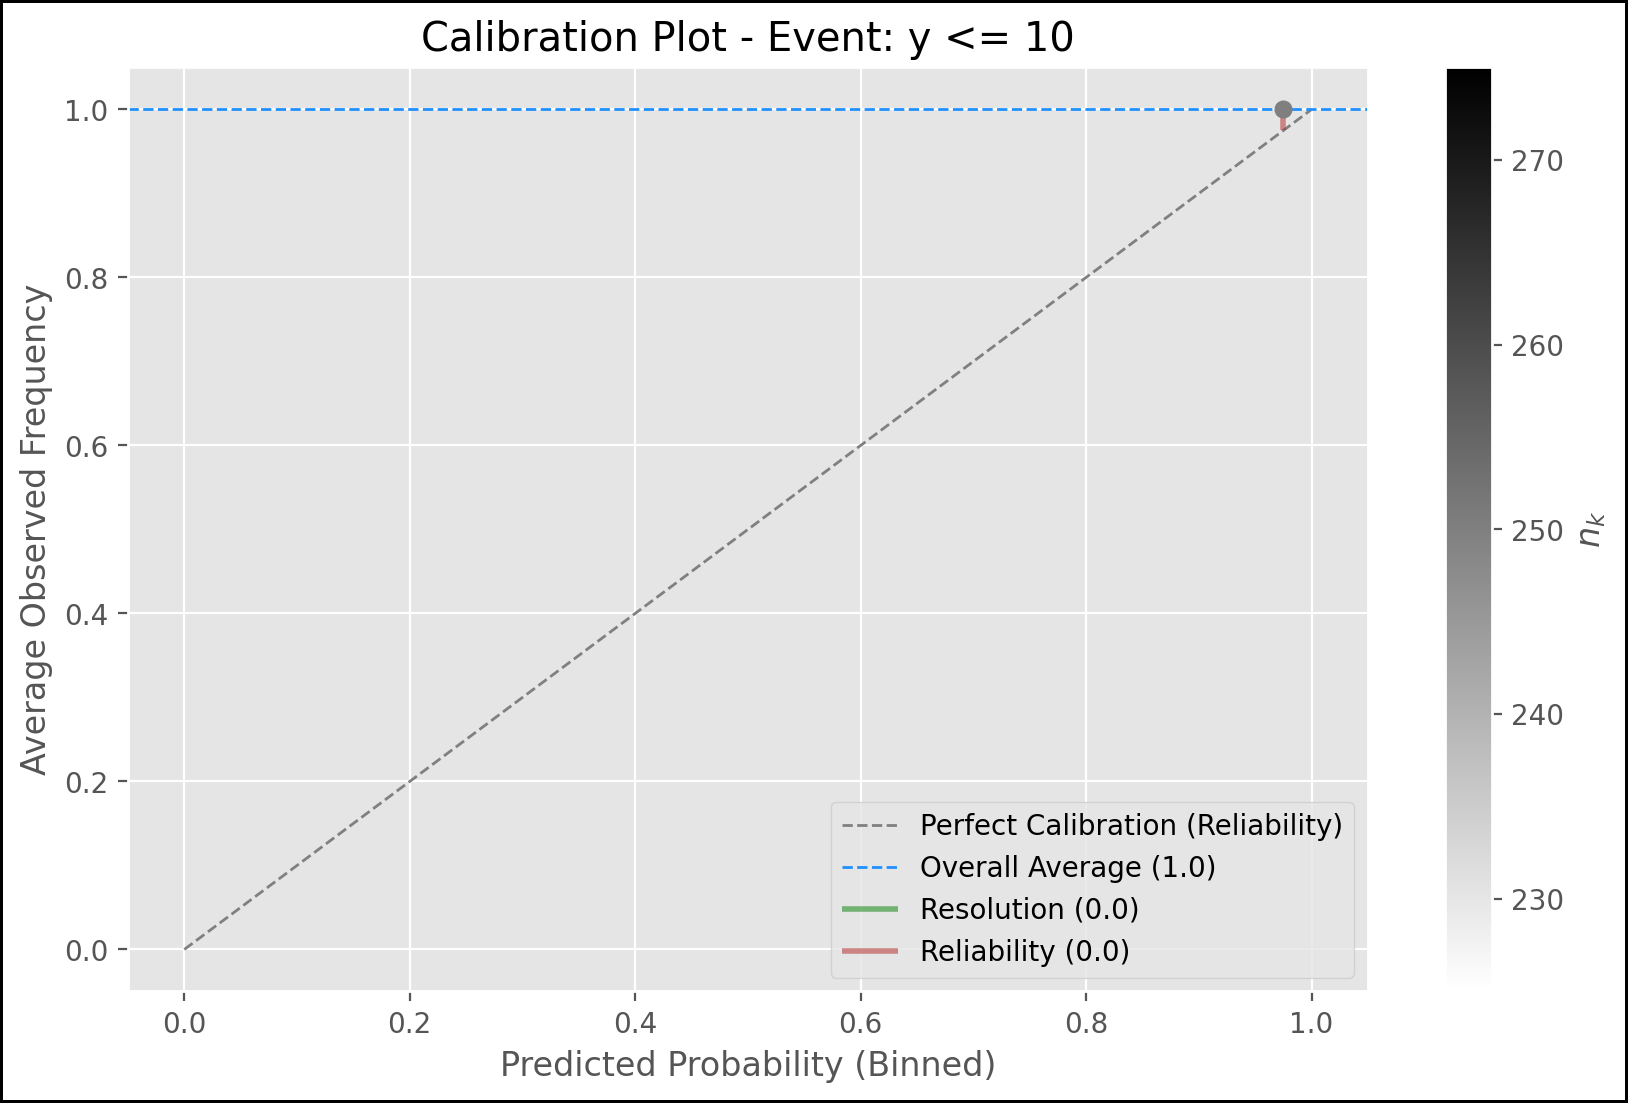

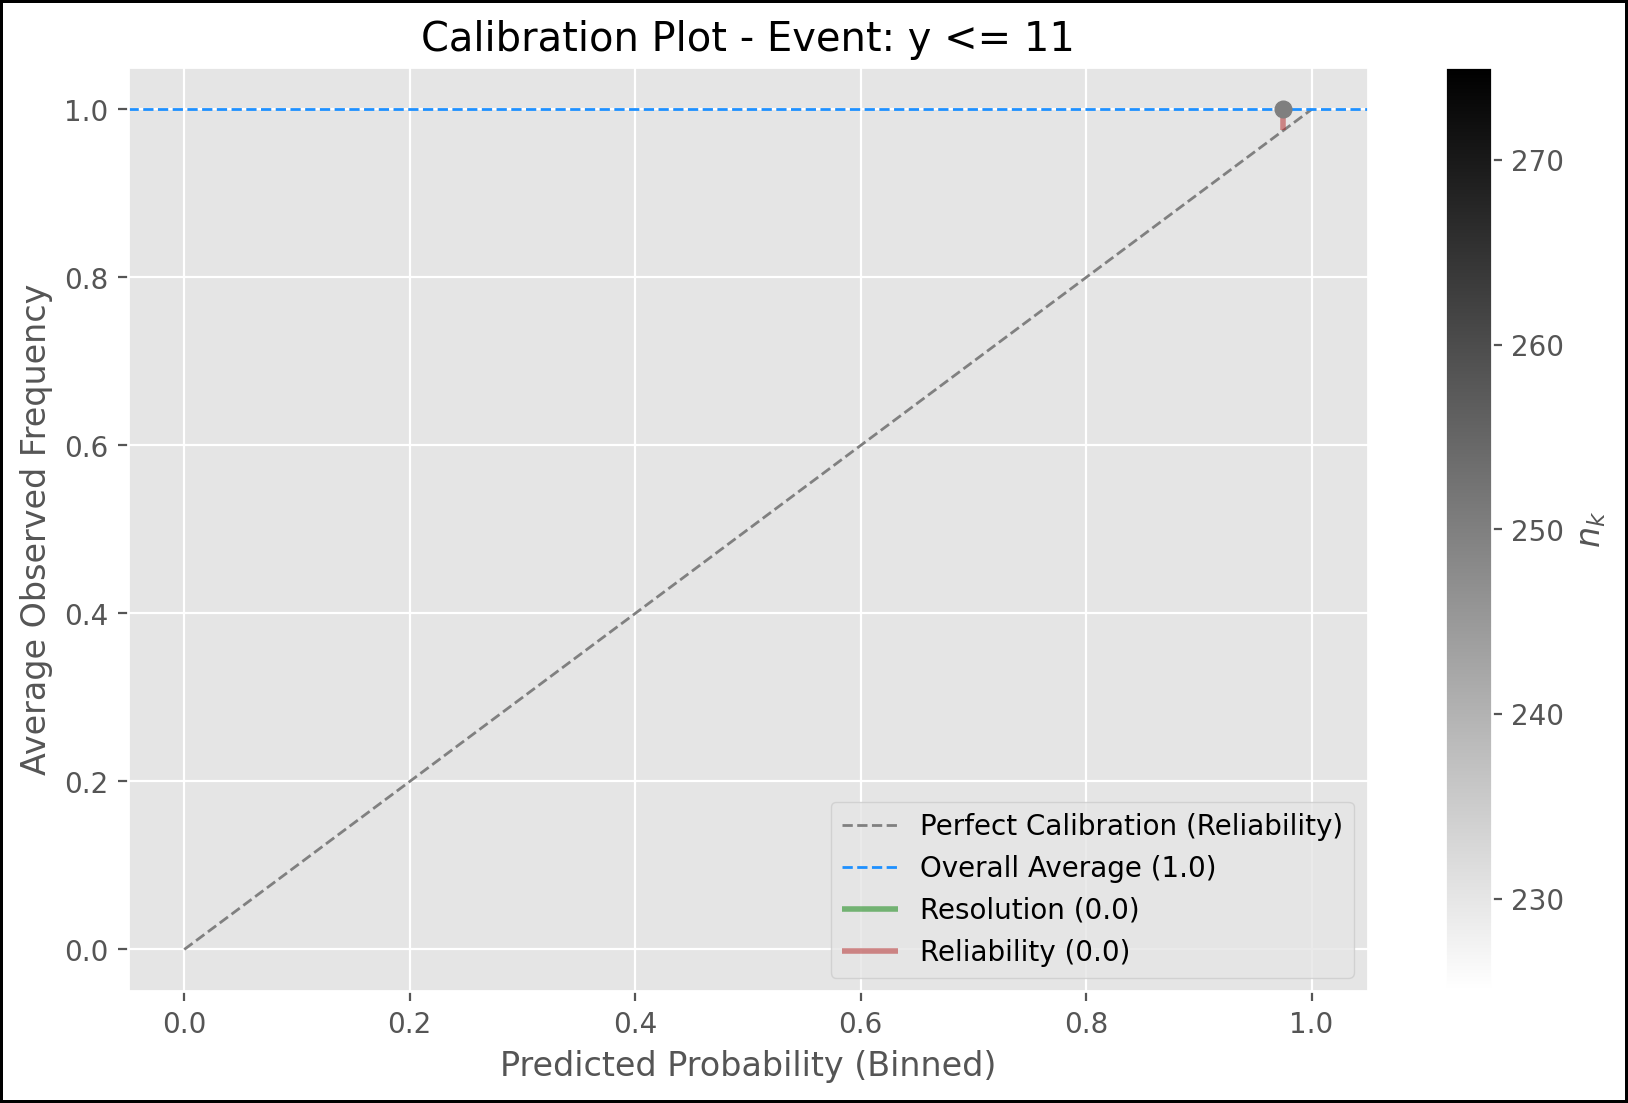

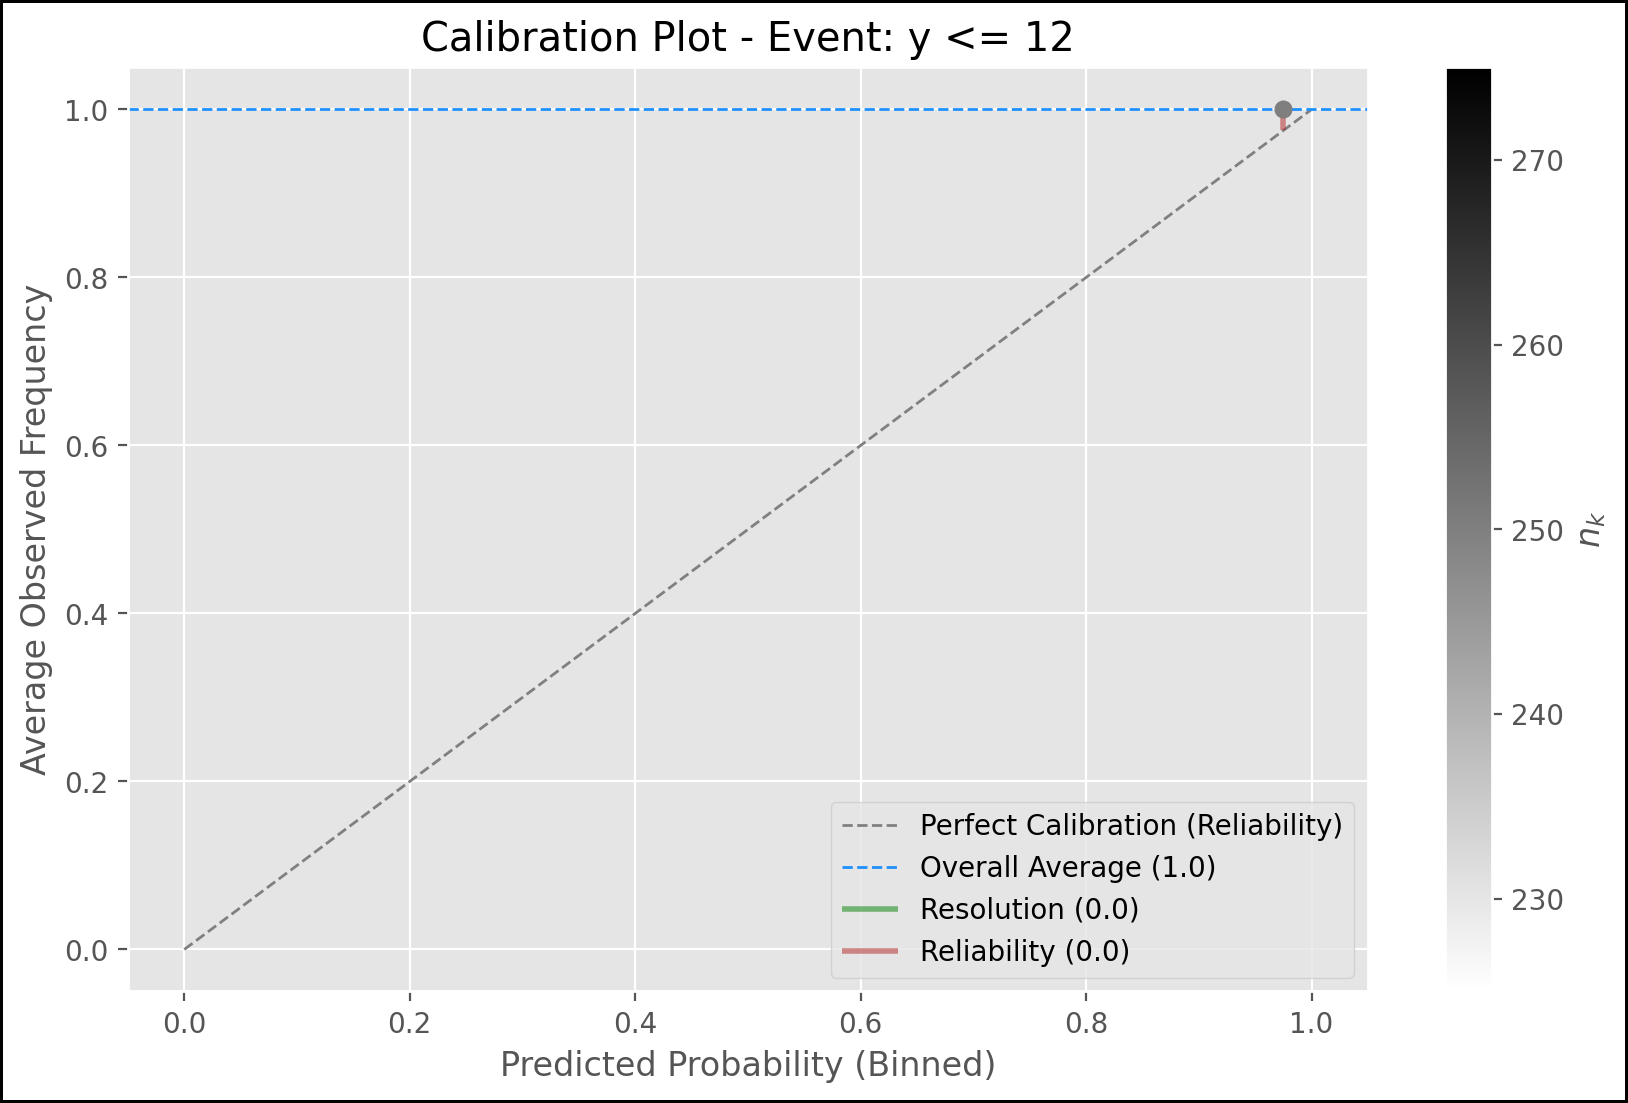

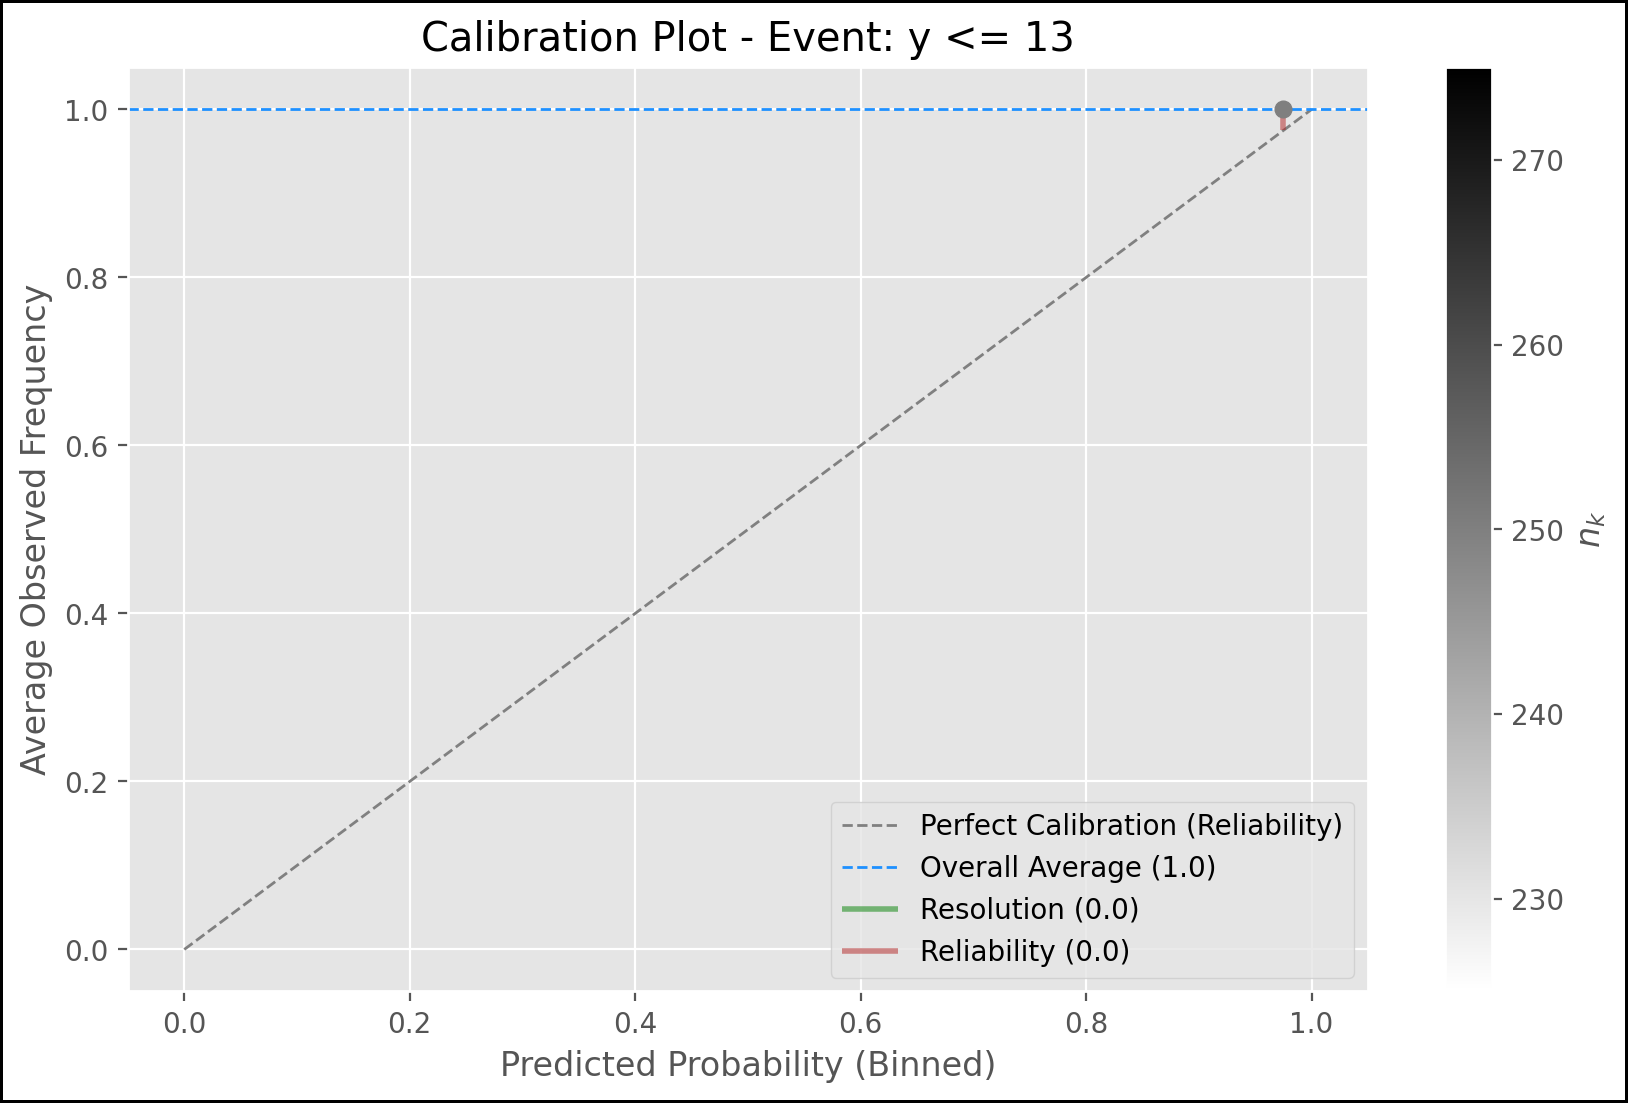

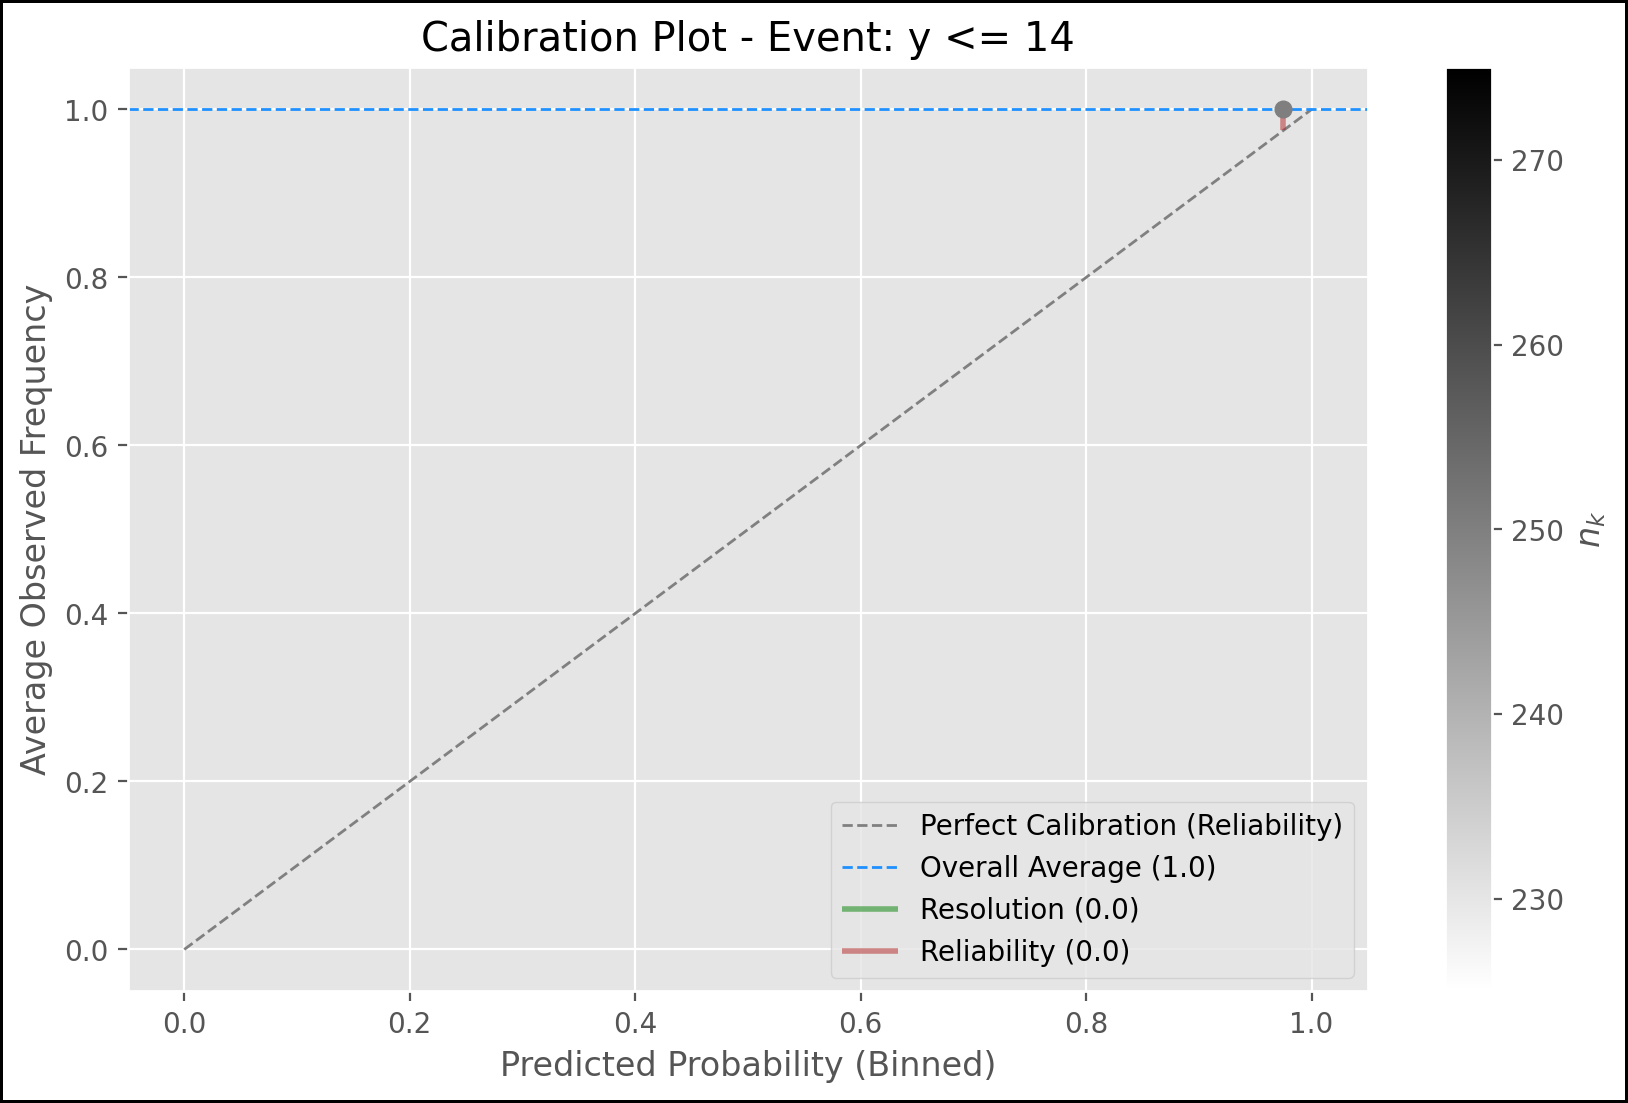

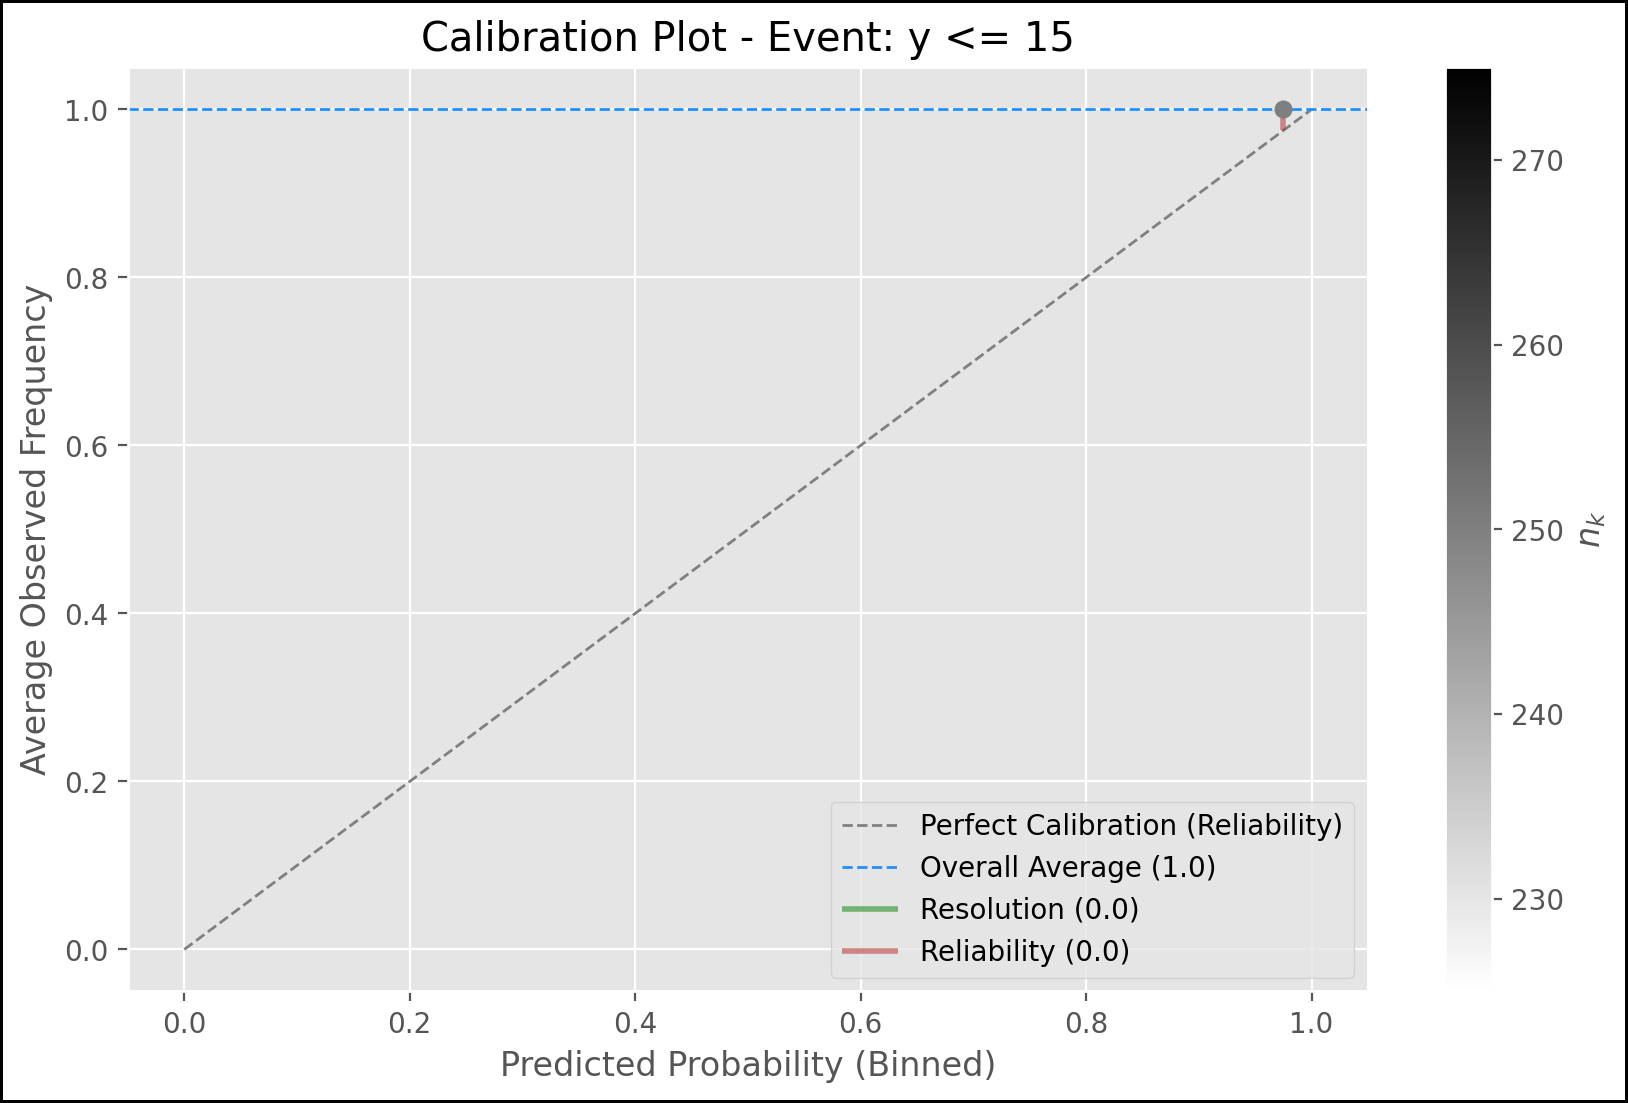

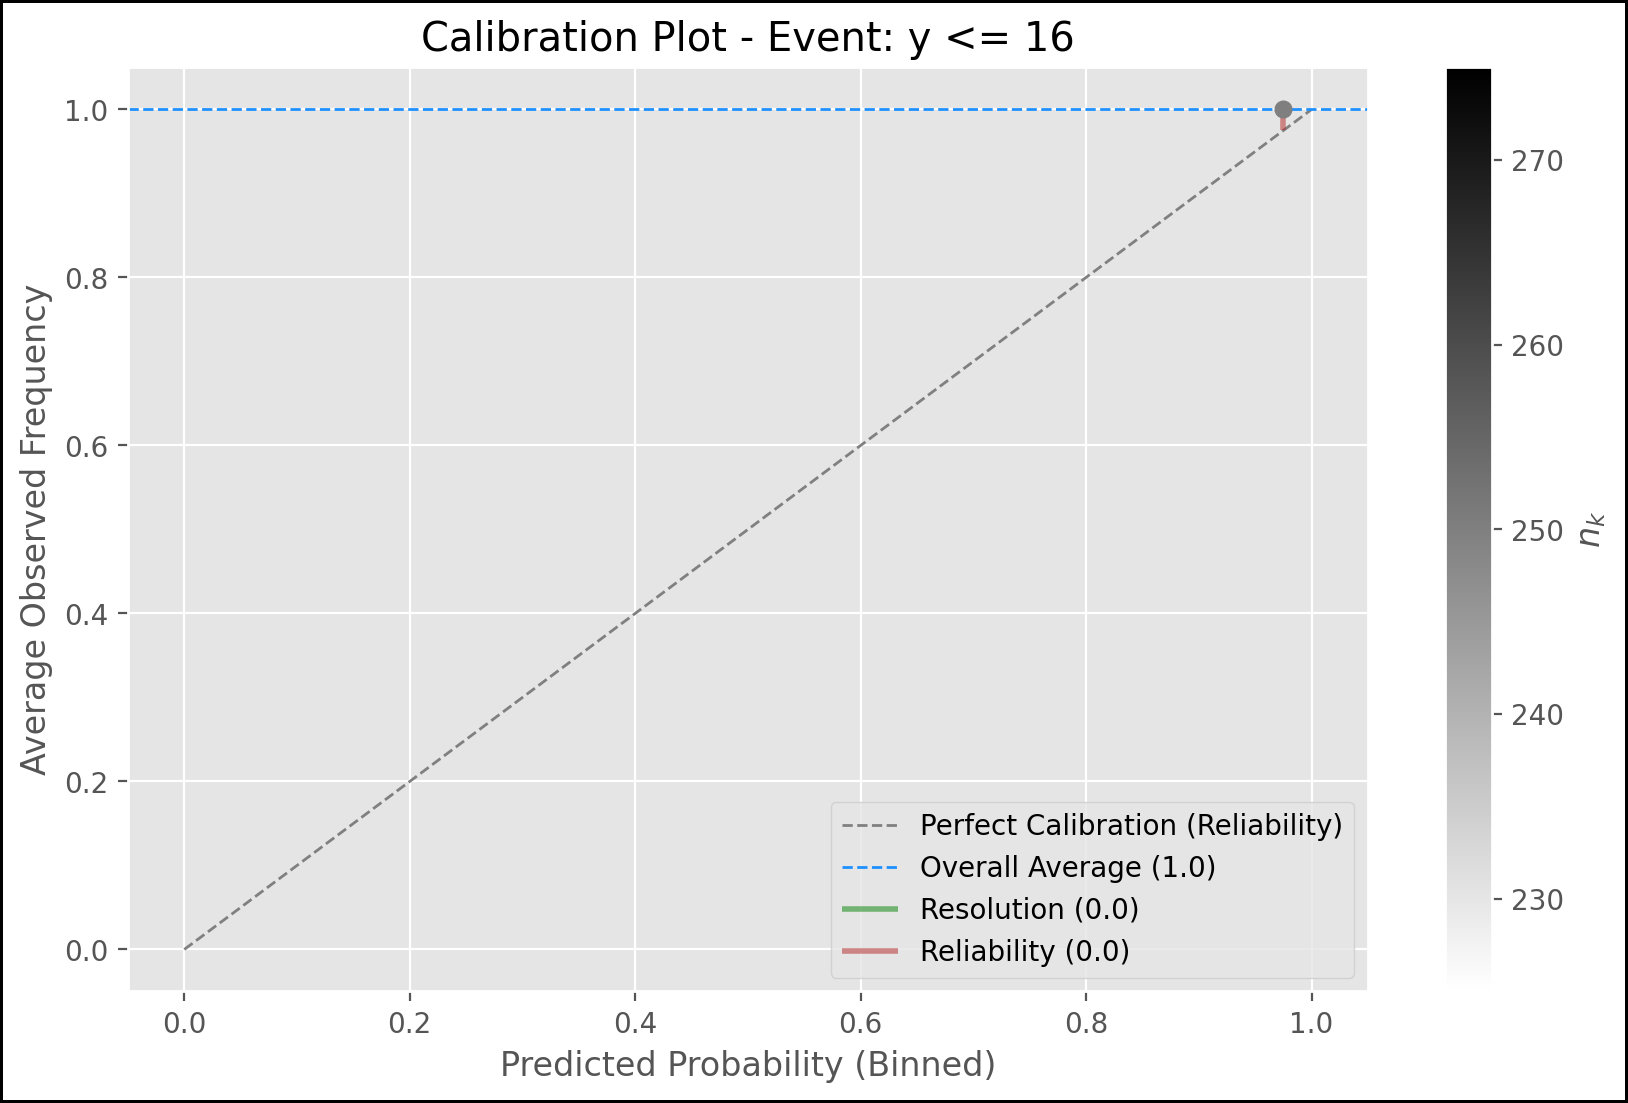

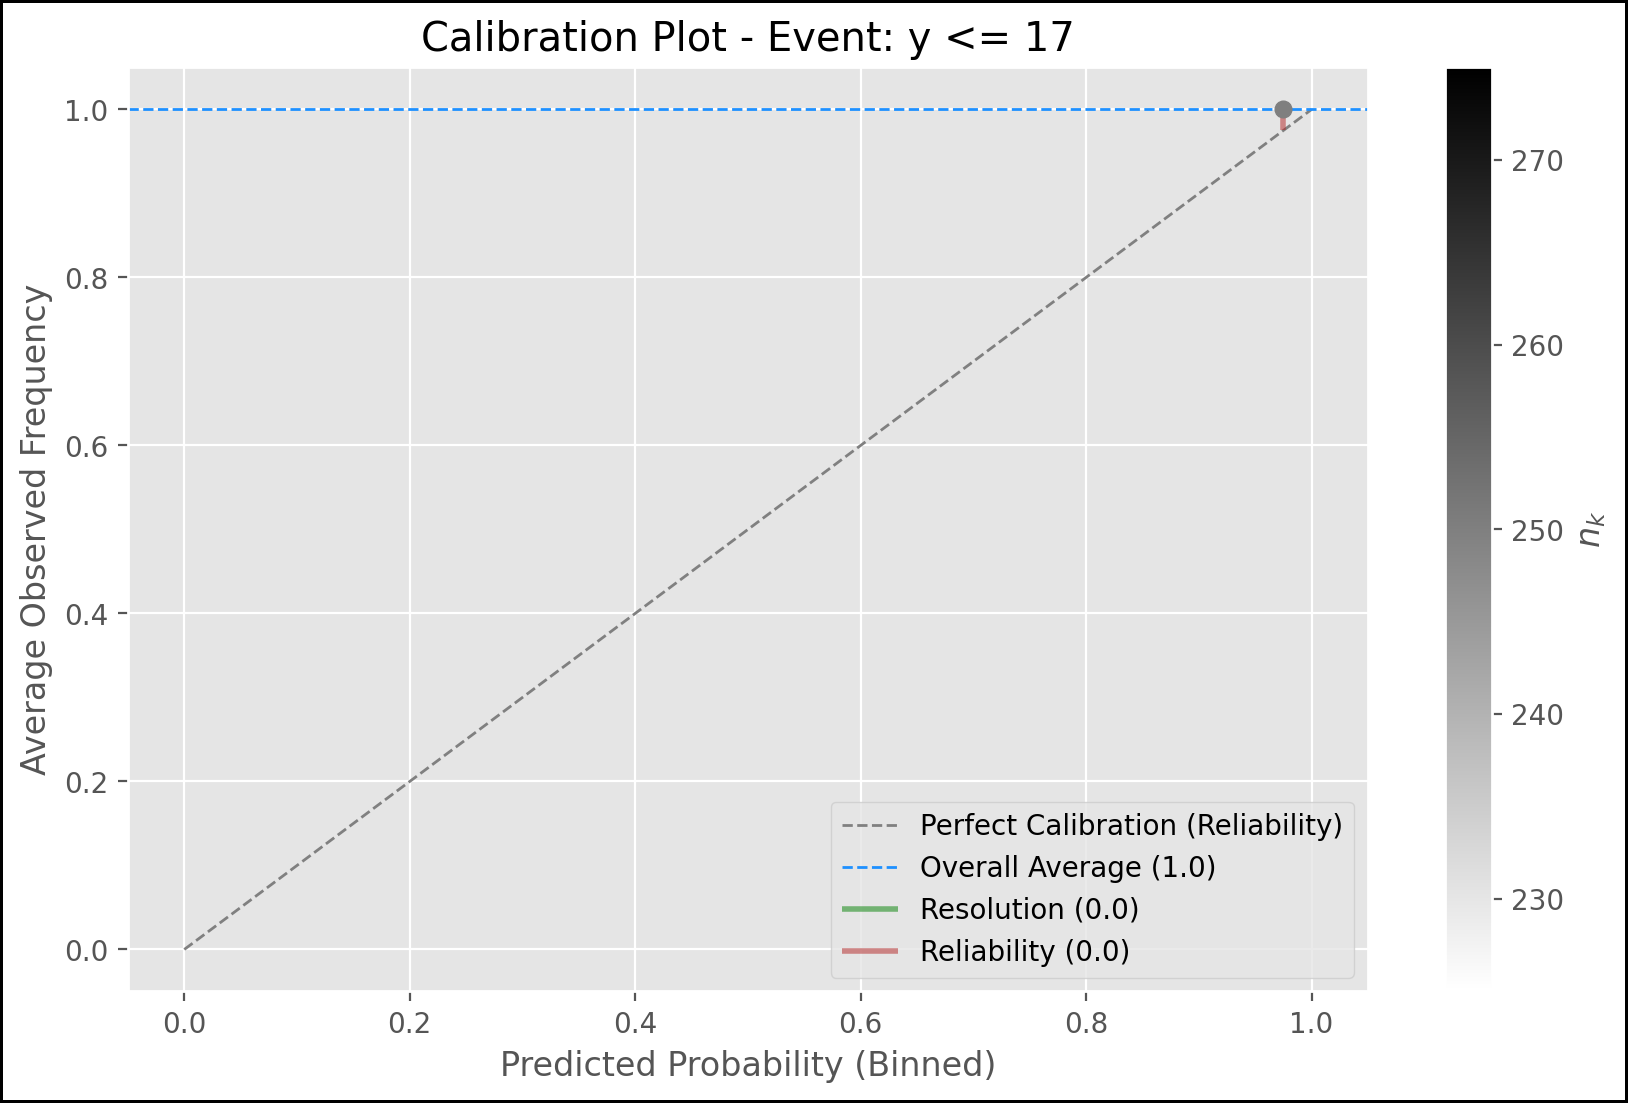

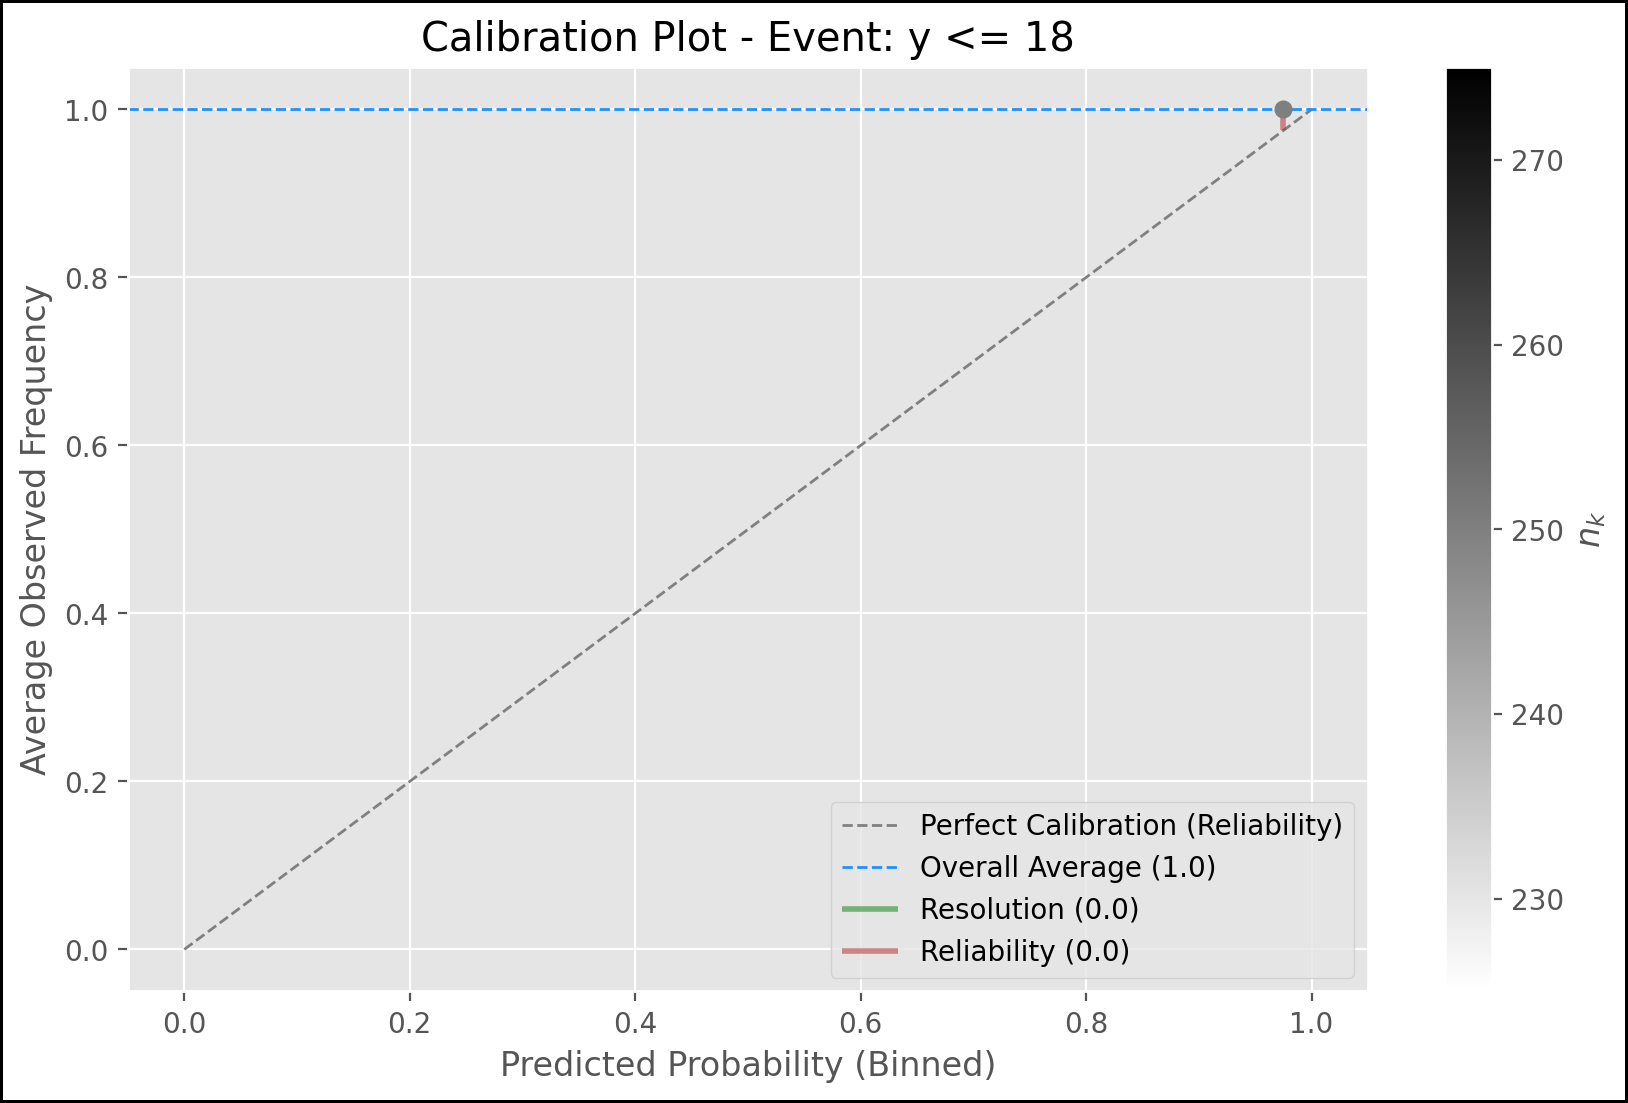

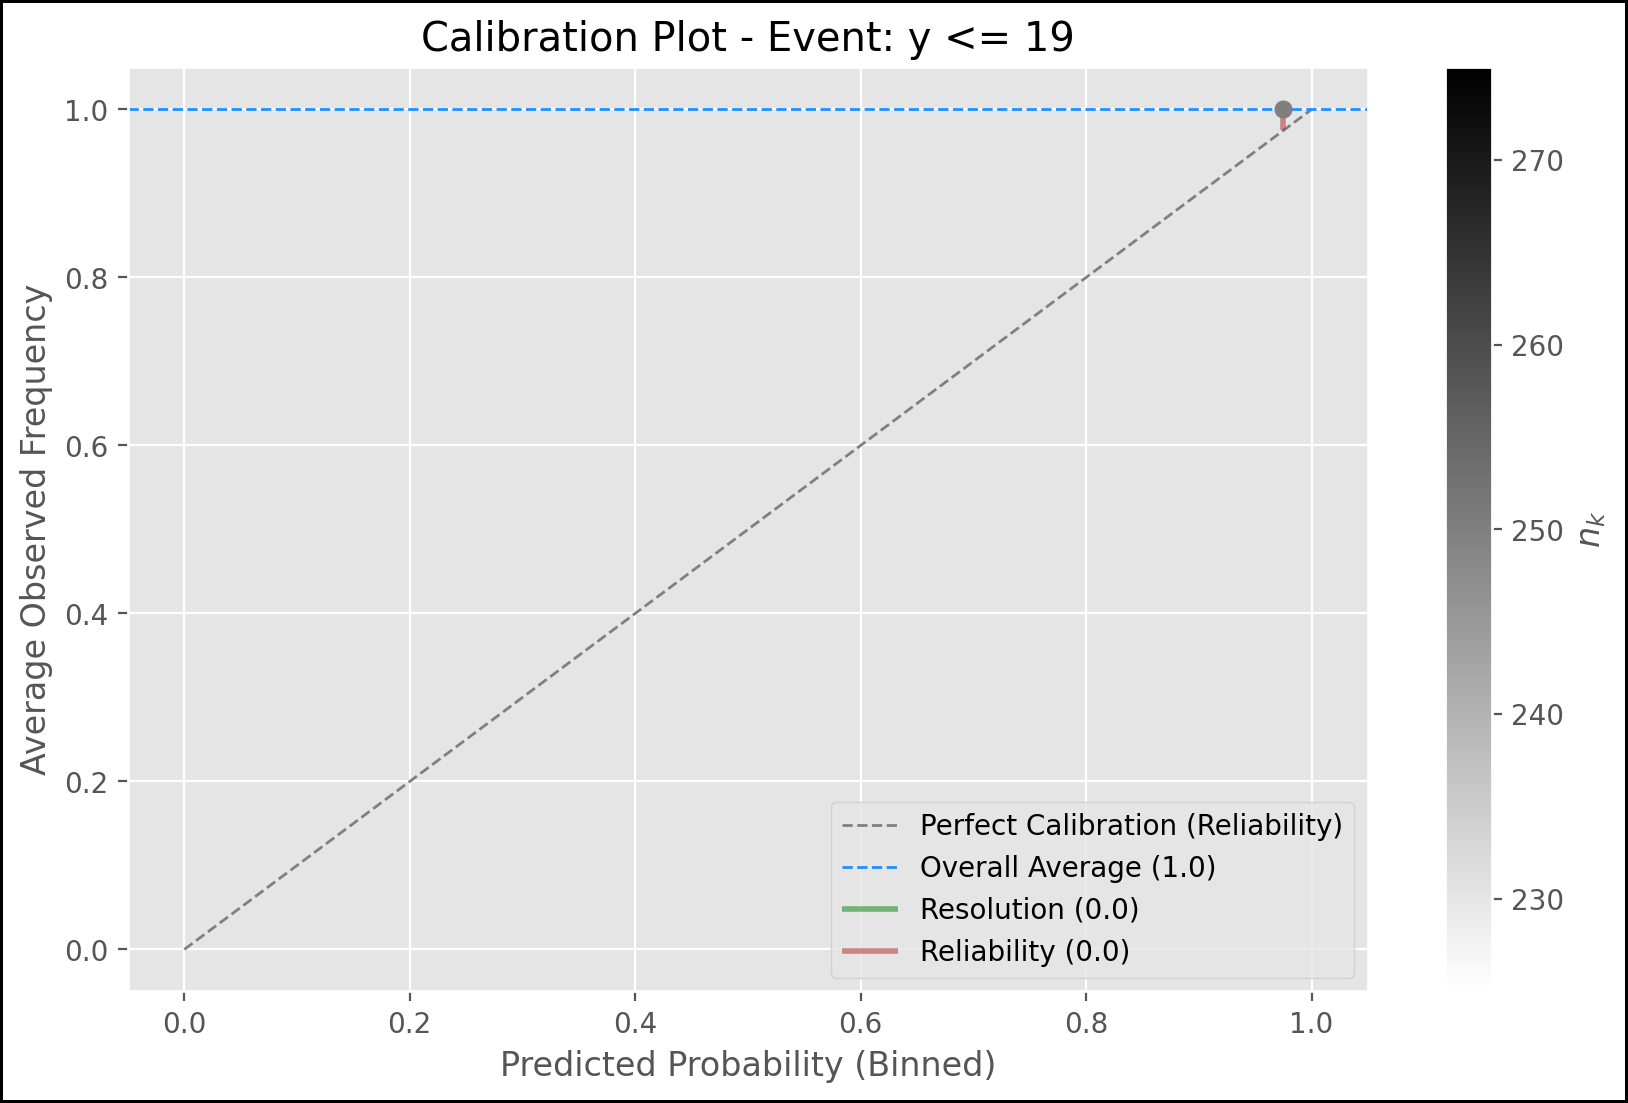

In [303]:
res, bs_list, axis = crps_integration_of_brier(y, q)
res

# New attempt

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/2794090235.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/2794090235.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/2794090235.py:28: FutureWarning: The default of observed=False is deprecated an

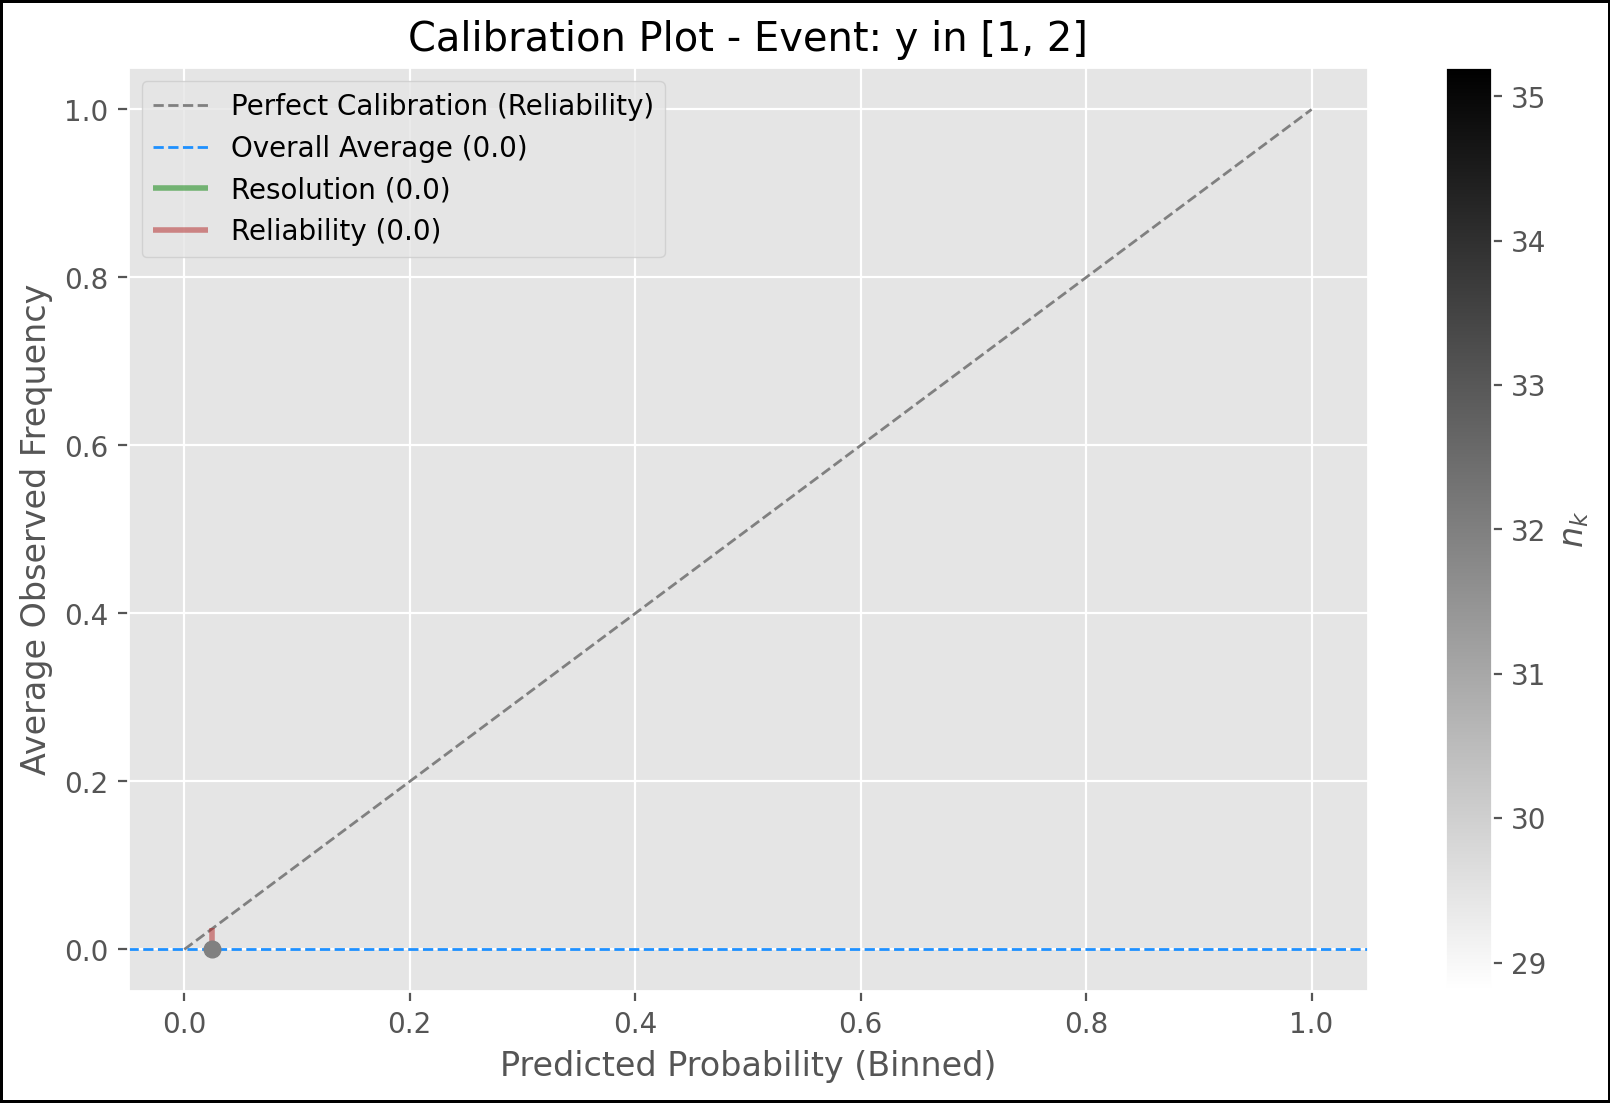

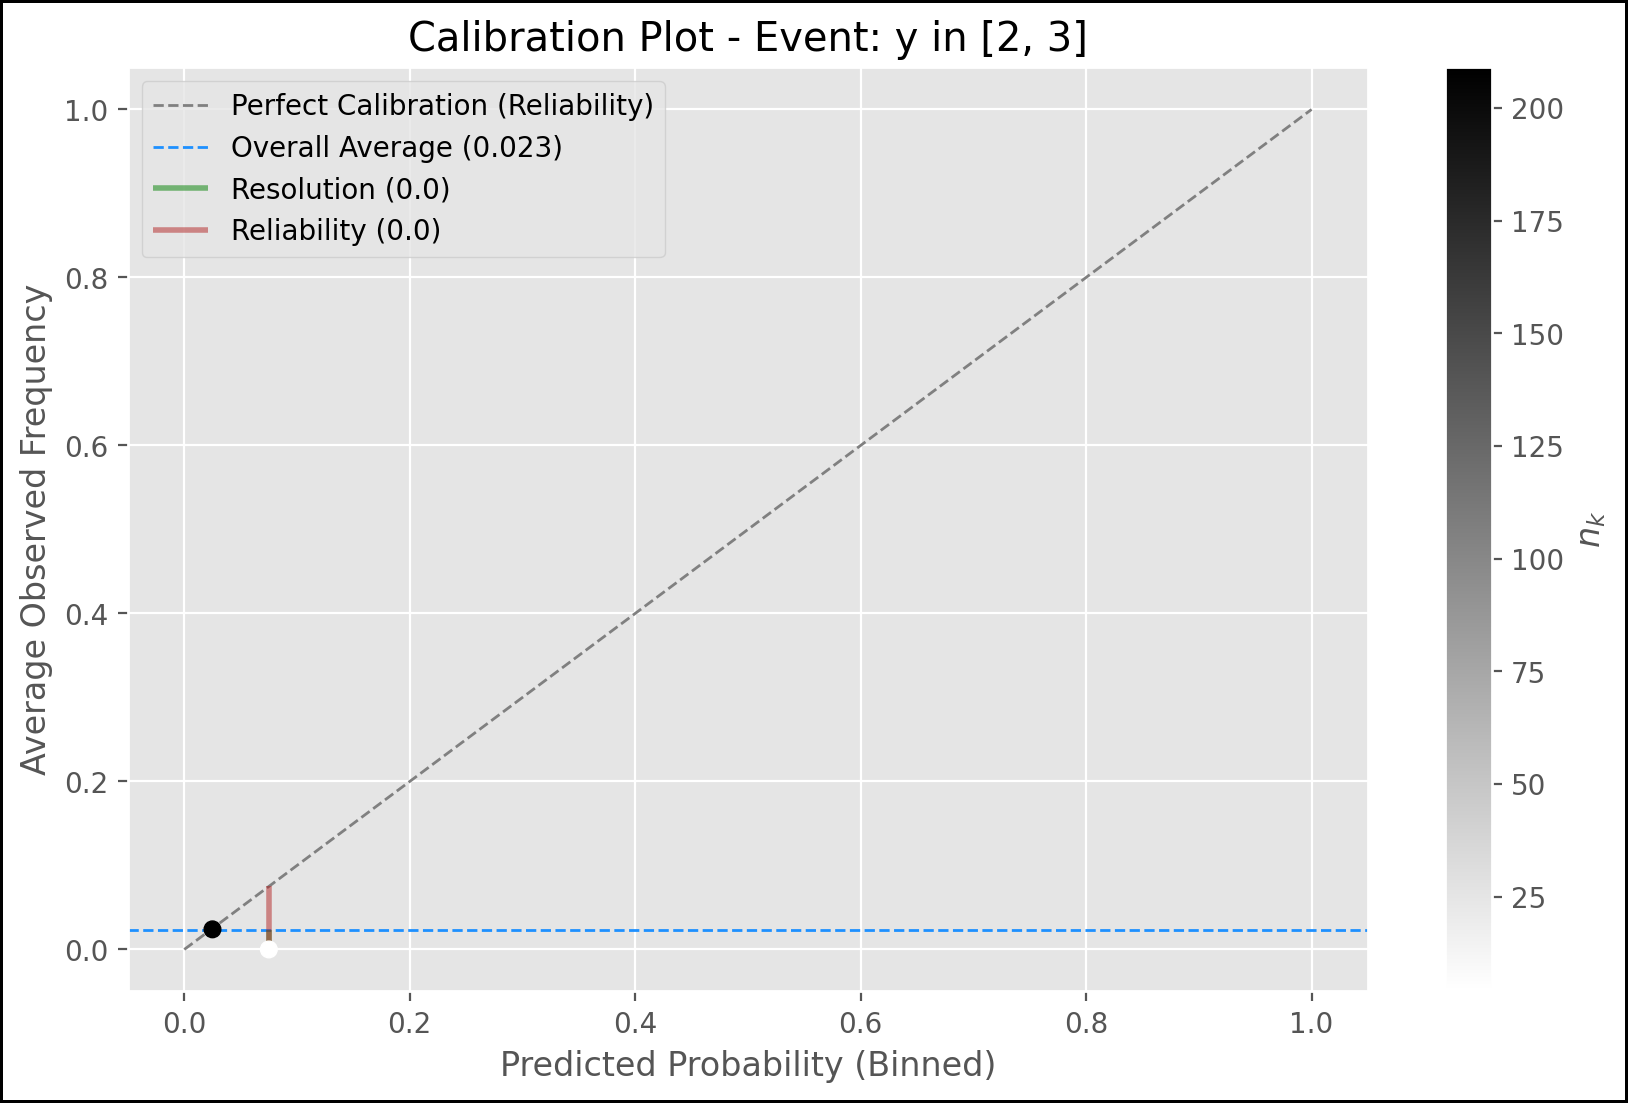

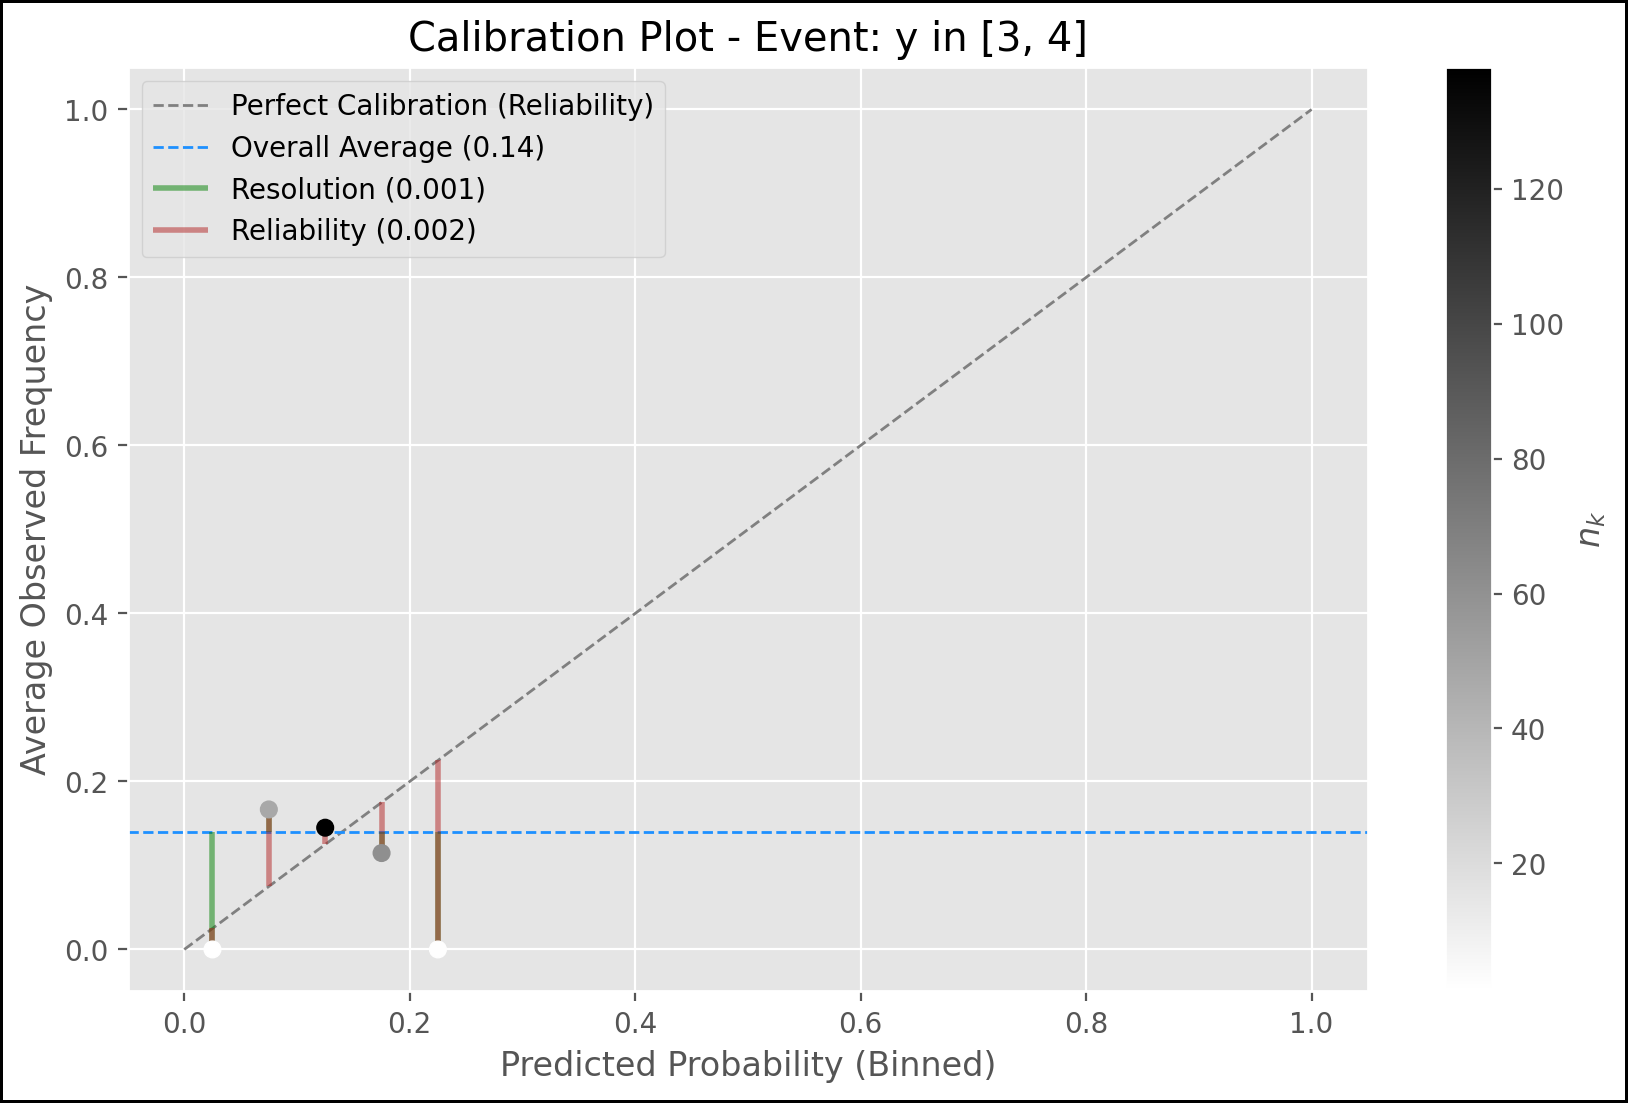

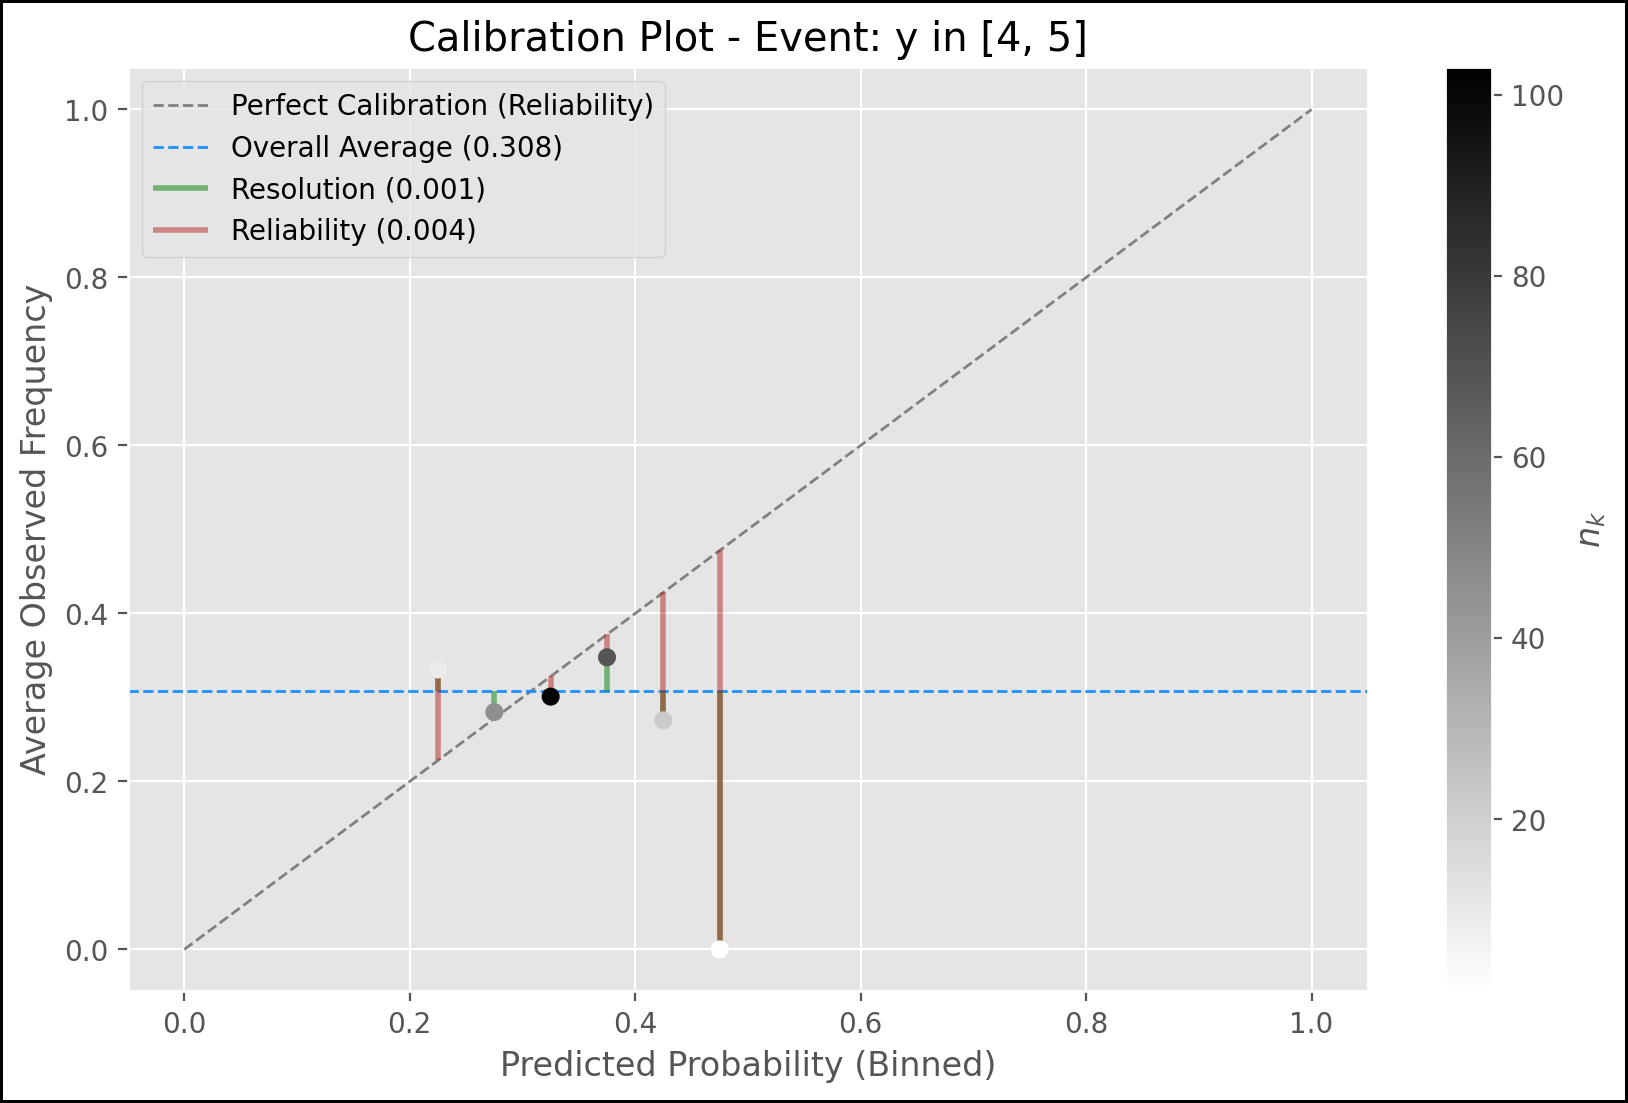

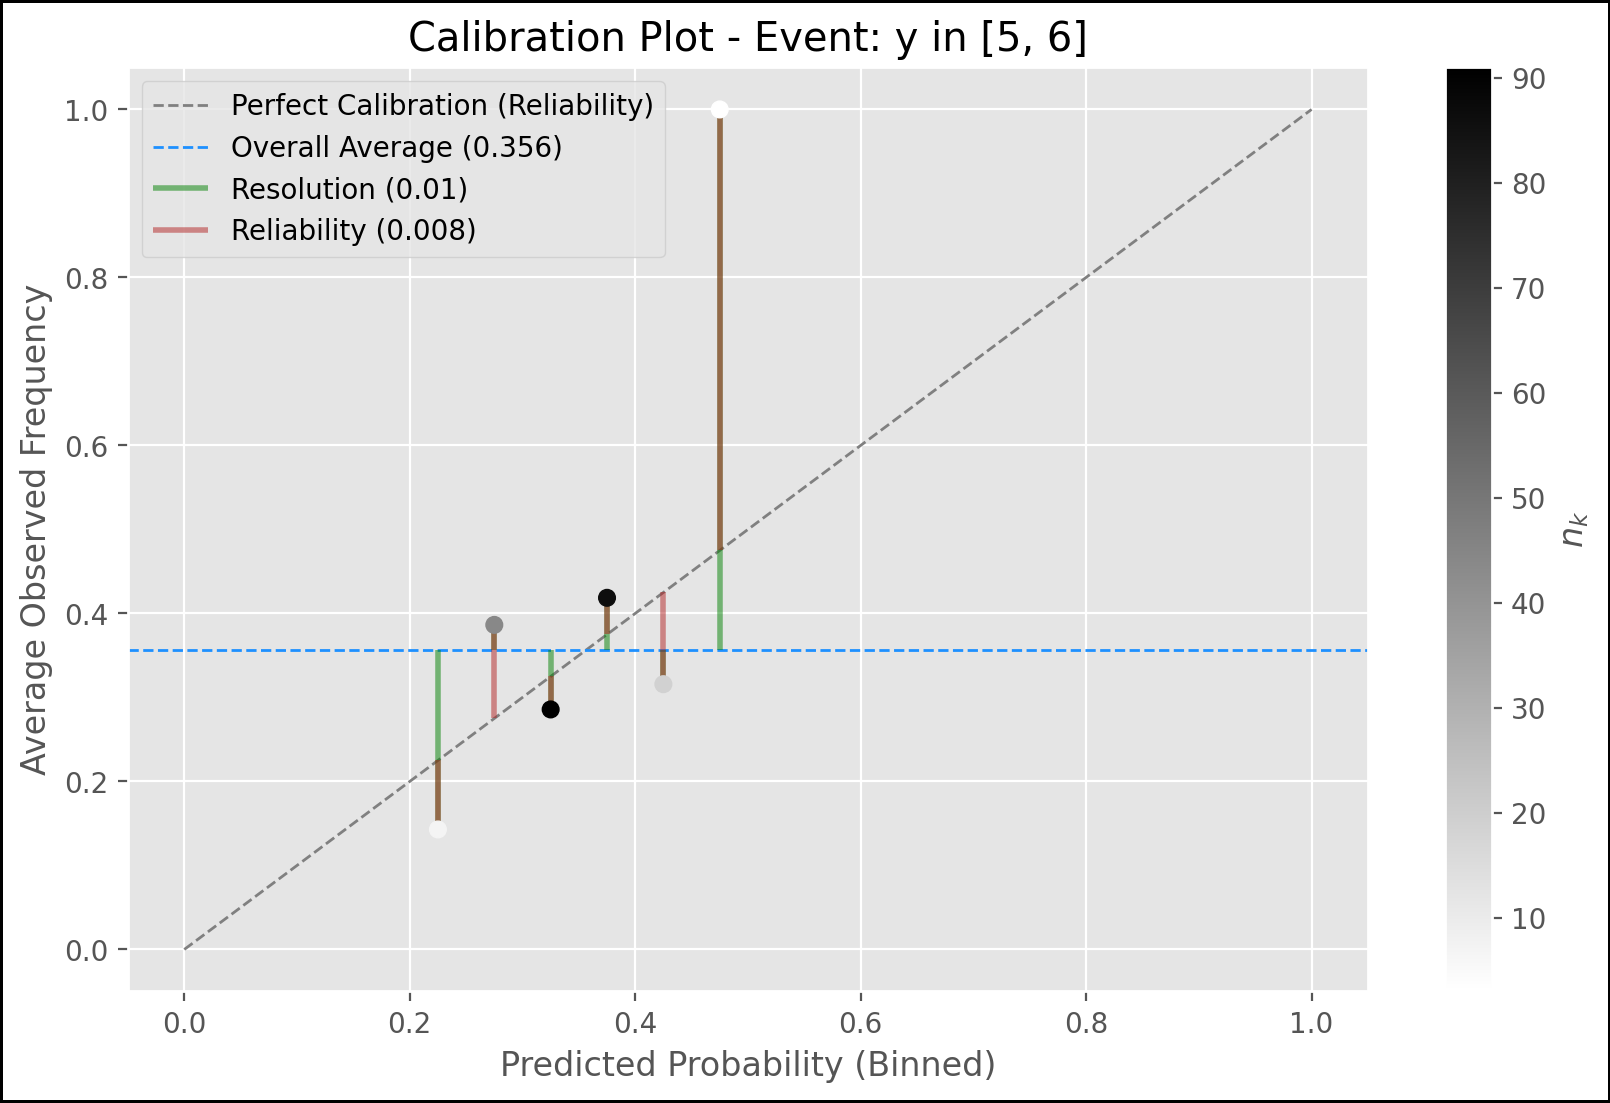

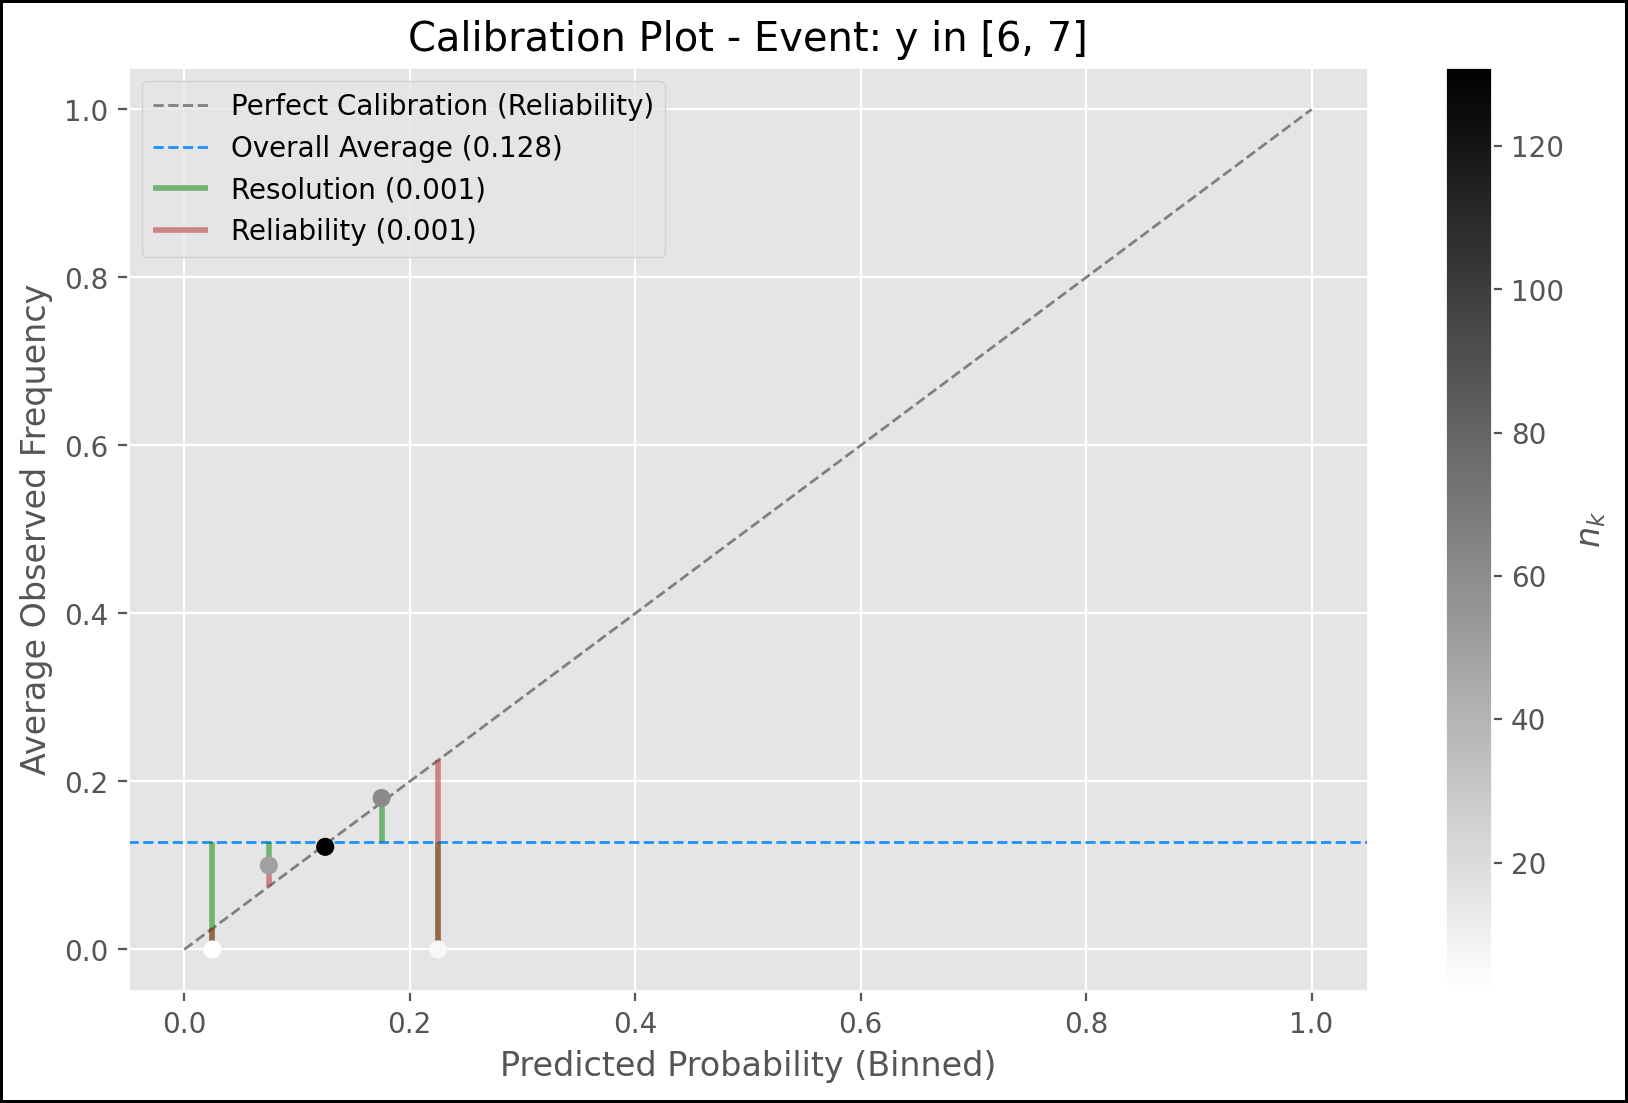

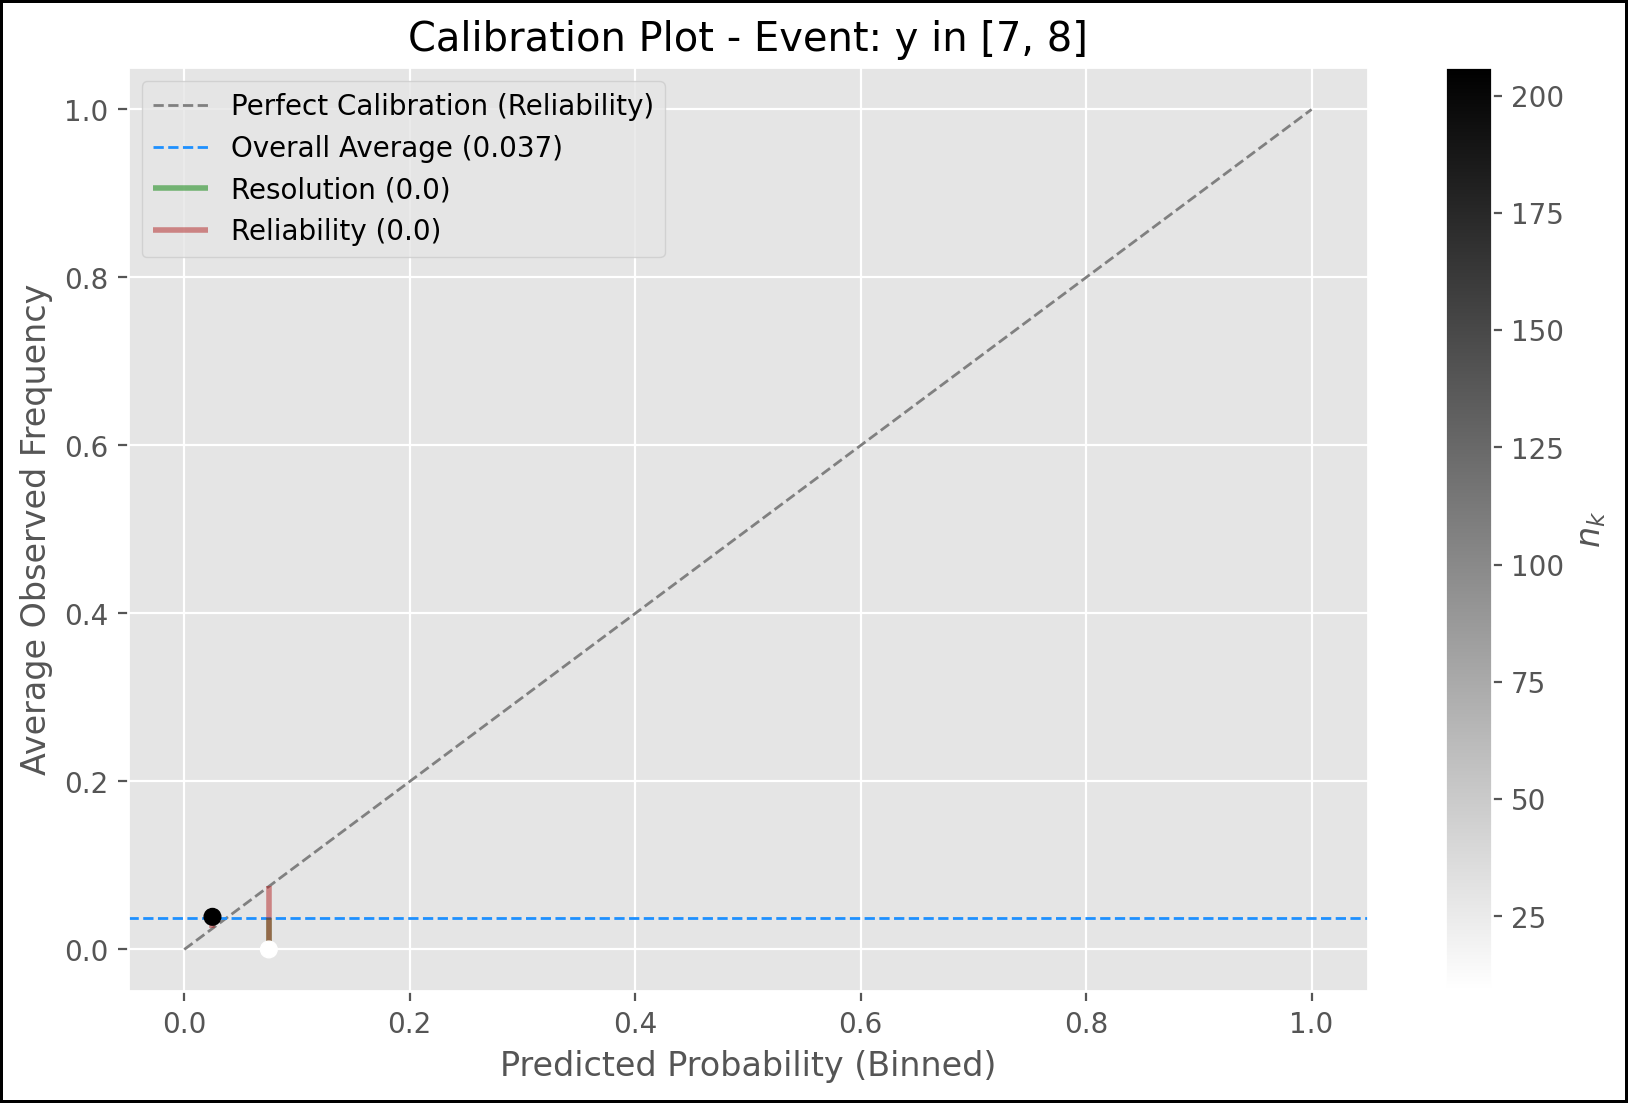

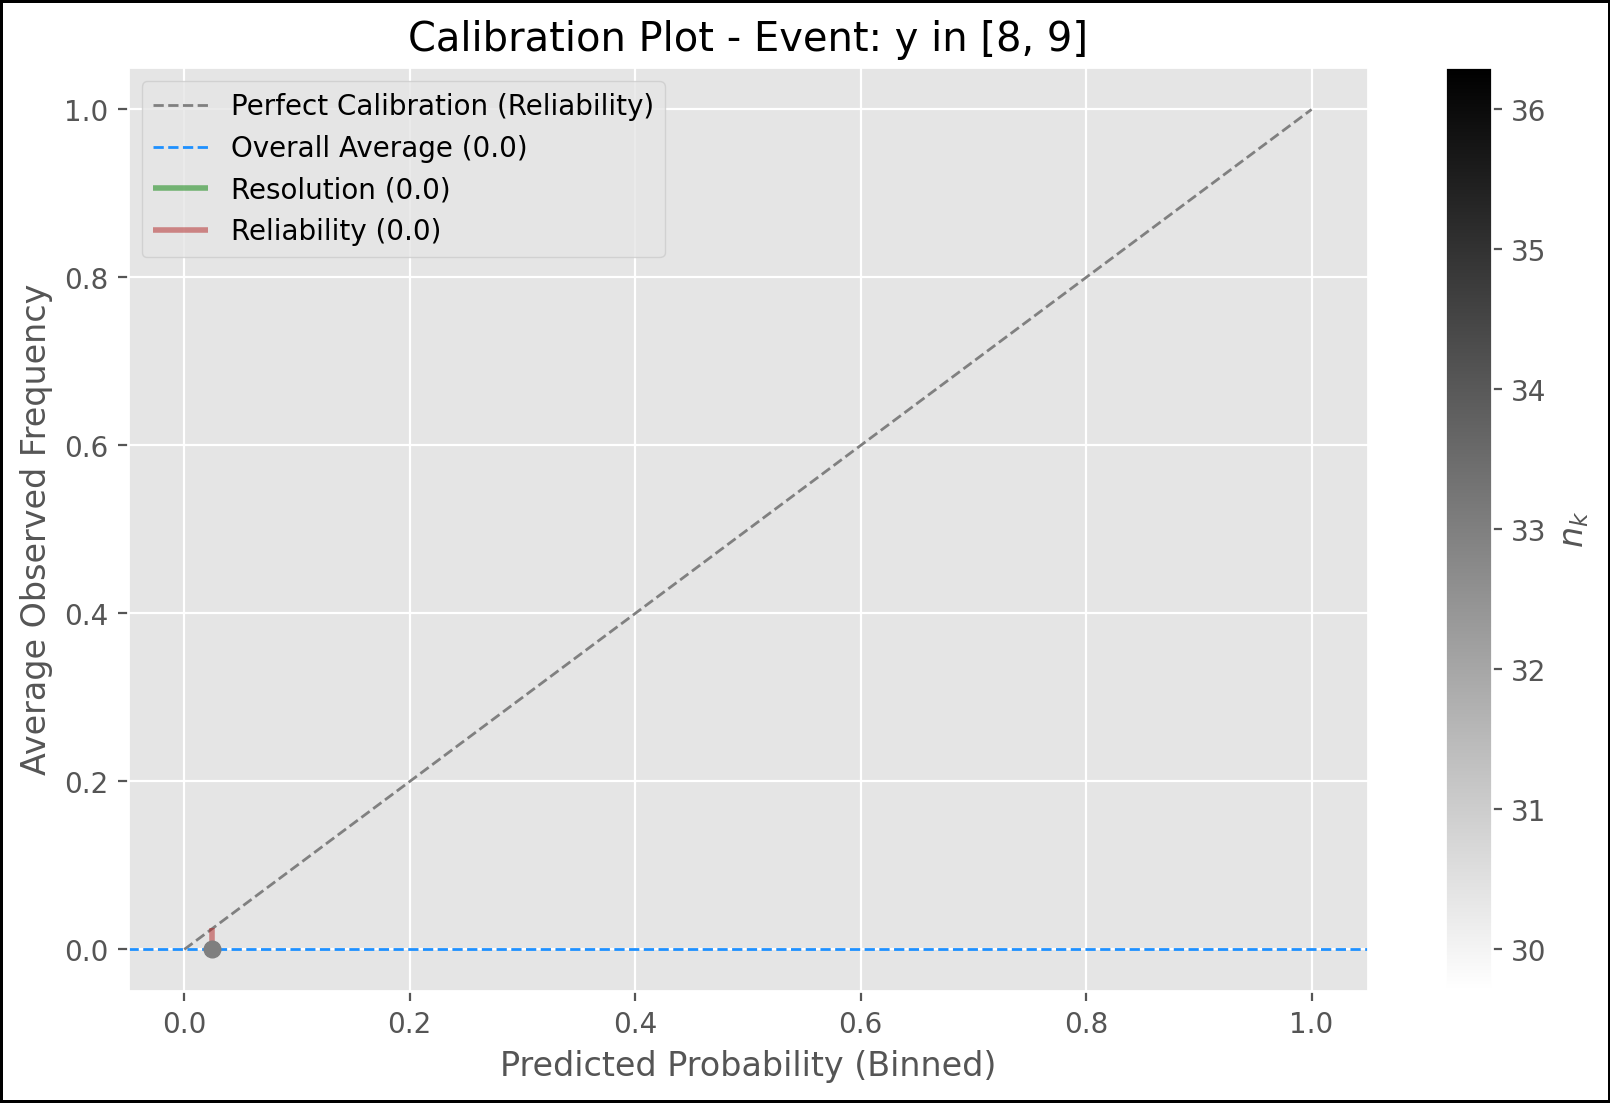

In [310]:
# Every prediction must have all ranges accounted for
bs_list = []
q_event_count_list = []
STEP = 1
LOWER = -20
N_PREDS = q.shape[0] * q.shape[1]

axis = np.arange(LOWER, 20, STEP)
for i in axis:
    y_event = apply_condition(y, i, i + STEP)
    q_event = apply_condition(q, i, i + STEP)

    y_event_count = y_event.sum(axis=1)
    y_event_mean = y_event.mean(axis=1)
    q_event_count = q_event.sum(axis=1)
    q_event_mean = q_event.mean(axis=1)



    
    df = pd.DataFrame({'observation': y_event_mean, 'predicted_prob': q_event_mean})
    step = 0.05
    df = df.assign(predicted_prob_bin=pd.cut(df.predicted_prob, bins=np.arange(0, 1 + step, step)))
    df = df.dropna()
    if len(df) == 0:
        continue

    dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
    dfg.columns = ["_".join(x) for x in dfg.columns]
    dfg = dfg.reset_index()


    bs = brier_score_loss(y_event_mean, q_event_mean) 
    bs_list.append(bs)

    plot_calibration(dfg.dropna(), title=f'Event: y in [{i}, {i + STEP}]')



In [296]:
dfg

predicted_prob_bin  observation_mean  observation_count  \
0         (0.0, 0.05]               0.0                  4   
1         (0.05, 0.1]               NaN                  0   
2         (0.1, 0.15]               NaN                  0   
3         (0.15, 0.2]               NaN                  0   
4         (0.2, 0.25]               NaN                  0   
5         (0.25, 0.3]               NaN                  0   
6         (0.3, 0.35]               NaN                  0   
7         (0.35, 0.4]               NaN                  0   
8         (0.4, 0.45]               NaN                  0   
9         (0.45, 0.5]               NaN                  0   
10        (0.5, 0.55]               NaN                  0   
11        (0.55, 0.6]               NaN                  0   
12        (0.6, 0.65]               NaN                  0   
13        (0.65, 0.7]               NaN                  0   
14        (0.7, 0.75]               NaN                  0   
15        (0.75, 0.8]               NaN                  0   
16        (0.8, 0.85]               NaN                  0   
17        (0.85, 0.9]               NaN                  0   
18        (0.9, 0.95]               NaN                  0   
19        (0.95, 1.0]               NaN                  0   

    predicted_prob_mean  
0                  0.01  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
5                   NaN  
6                   NaN  
7                   NaN  
8                   NaN  
9                   NaN  
10                  NaN  
11                  NaN  
12                  NaN  
13                  NaN  
14                  NaN  
15                  NaN  
16                  NaN  
17                  NaN  
18                  NaN  
19                  NaN

In [289]:
dfg

predicted_prob_bin  observation_mean  observation_count  \
0         (0.0, 0.05]               NaN                  0   
1         (0.05, 0.1]               NaN                  0   
2         (0.1, 0.15]               NaN                  0   
3         (0.15, 0.2]               NaN                  0   
4         (0.2, 0.25]               NaN                  0   
5         (0.25, 0.3]               NaN                  0   
6         (0.3, 0.35]               NaN                  0   
7         (0.35, 0.4]               NaN                  0   
8         (0.4, 0.45]               NaN                  0   
9         (0.45, 0.5]               NaN                  0   
10        (0.5, 0.55]               NaN                  0   
11        (0.55, 0.6]               NaN                  0   
12        (0.6, 0.65]               NaN                  0   
13        (0.65, 0.7]               NaN                  0   
14        (0.7, 0.75]               NaN                  0   
15        (0.75, 0.8]               NaN                  0   
16        (0.8, 0.85]               NaN                  0   
17        (0.85, 0.9]               NaN                  0   
18        (0.9, 0.95]               NaN                  0   
19        (0.95, 1.0]               NaN                  0   

    predicted_prob_mean  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
5                   NaN  
6                   NaN  
7                   NaN  
8                   NaN  
9                   NaN  
10                  NaN  
11                  NaN  
12                  NaN  
13                  NaN  
14                  NaN  
15                  NaN  
16                  NaN  
17                  NaN  
18                  NaN  
19                  NaN

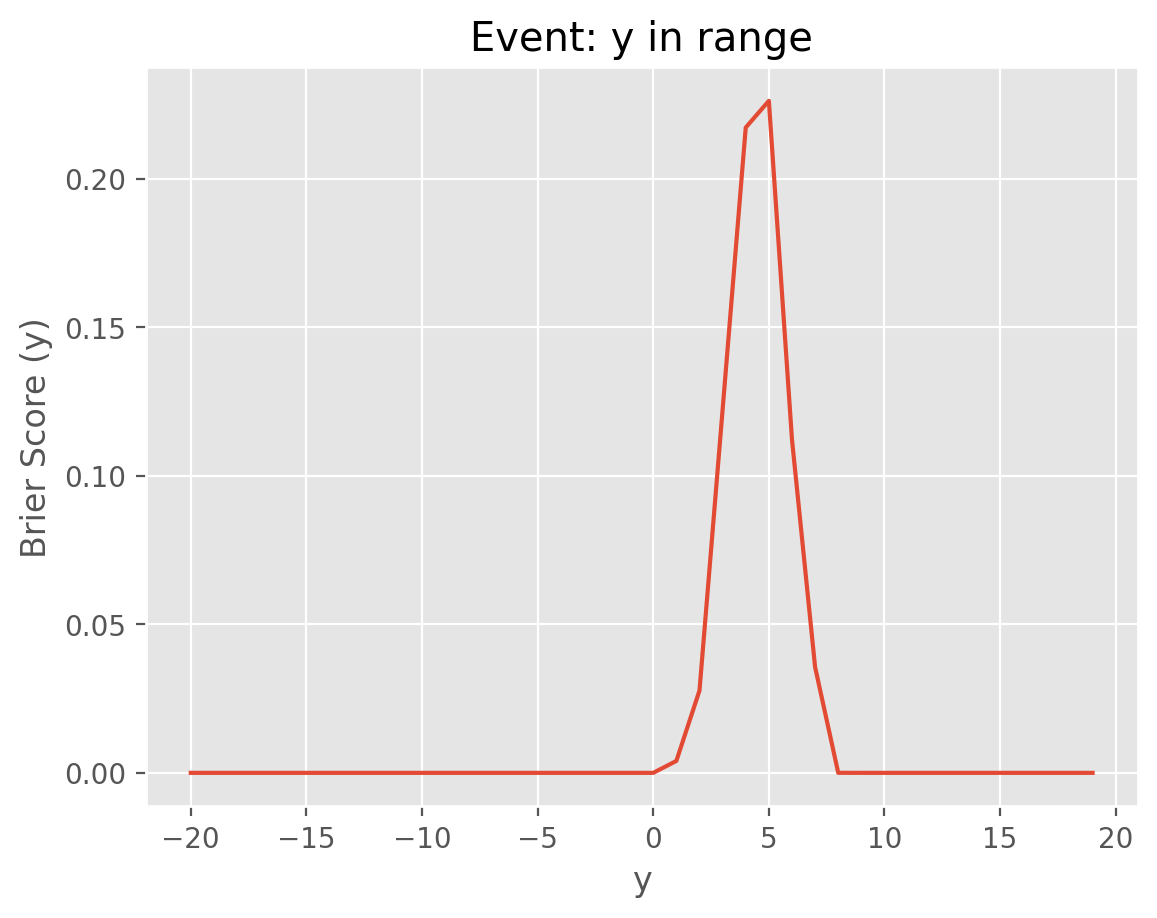

In [279]:
plt.plot(axis, bs_list)
plt.xlabel('y')
plt.ylabel('Brier Score (y)')
plt.title('Event: y in range')
plt.show()

In [197]:
dfg

predicted_prob_bin  observation_mean  observation_count  predicted_prob_mean
5        (0.25, 0.3]            0.2506              10000               0.2506

In [204]:
df

observation  predicted_prob predicted_prob_bin
0               0        0.286574        (0.25, 0.3]
1               1        0.320160        (0.3, 0.35]
2               0        0.111275        (0.1, 0.15]
3               0        0.185064        (0.15, 0.2]
4               0        0.109010        (0.1, 0.15]
...           ...             ...                ...
9995            1        0.774248        (0.75, 0.8]
9996            1        0.891813        (0.85, 0.9]
9997            1        0.047315        (0.0, 0.05]
9998            0        0.179848        (0.15, 0.2]
9999            1        0.999990        (0.95, 1.0]

[10000 rows x 3 columns]

In [ ]:

df = pd.DataFrame({
    "observation": observations,
    'predicted_prob': predicted_probabilities
})

step = 0.05
df = df.assign(
    predicted_prob_bin=pd.cut(df.predicted_prob, bins=np.arange(0, 1 + step, step))
)

dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
dfg.columns = ["_".join(x) for x in dfg.columns]
dfg = dfg.reset_index()

plot_calibration(dfg)

In [216]:
y.shape, q.shape

((250, 1), (250, 100))

In [217]:
# Select an event - in range [5, 6]
y_event = apply_condition(y, 5, 6)
q_event = apply_condition(q, 5, 6)

In [219]:
df = pd.DataFrame({
    'observation': y_event.mean(axis=1),
    'predicted_prob': q_event.mean(axis=1)
})
step = 0.05
df = df.assign(
    predicted_prob_bin=pd.cut(df.predicted_prob, bins=np.arange(0, 1 + step, step))
)

dfg = df.groupby('predicted_prob_bin').agg({'observation': ['mean', 'count'], 'predicted_prob': ['mean']})
dfg.columns = ["_".join(x) for x in dfg.columns]
dfg = dfg.reset_index()


observation  predicted_prob predicted_prob_bin
0               0        0.286574        (0.25, 0.3]
1               1        0.320160        (0.3, 0.35]
2               0        0.111275        (0.1, 0.15]
3               0        0.185064        (0.15, 0.2]
4               0        0.109010        (0.1, 0.15]
...           ...             ...                ...
9995            1        0.774248        (0.75, 0.8]
9996            1        0.891813        (0.85, 0.9]
9997            1        0.047315        (0.0, 0.05]
9998            0        0.179848        (0.15, 0.2]
9999            1        0.999990        (0.95, 1.0]

[10000 rows x 3 columns]

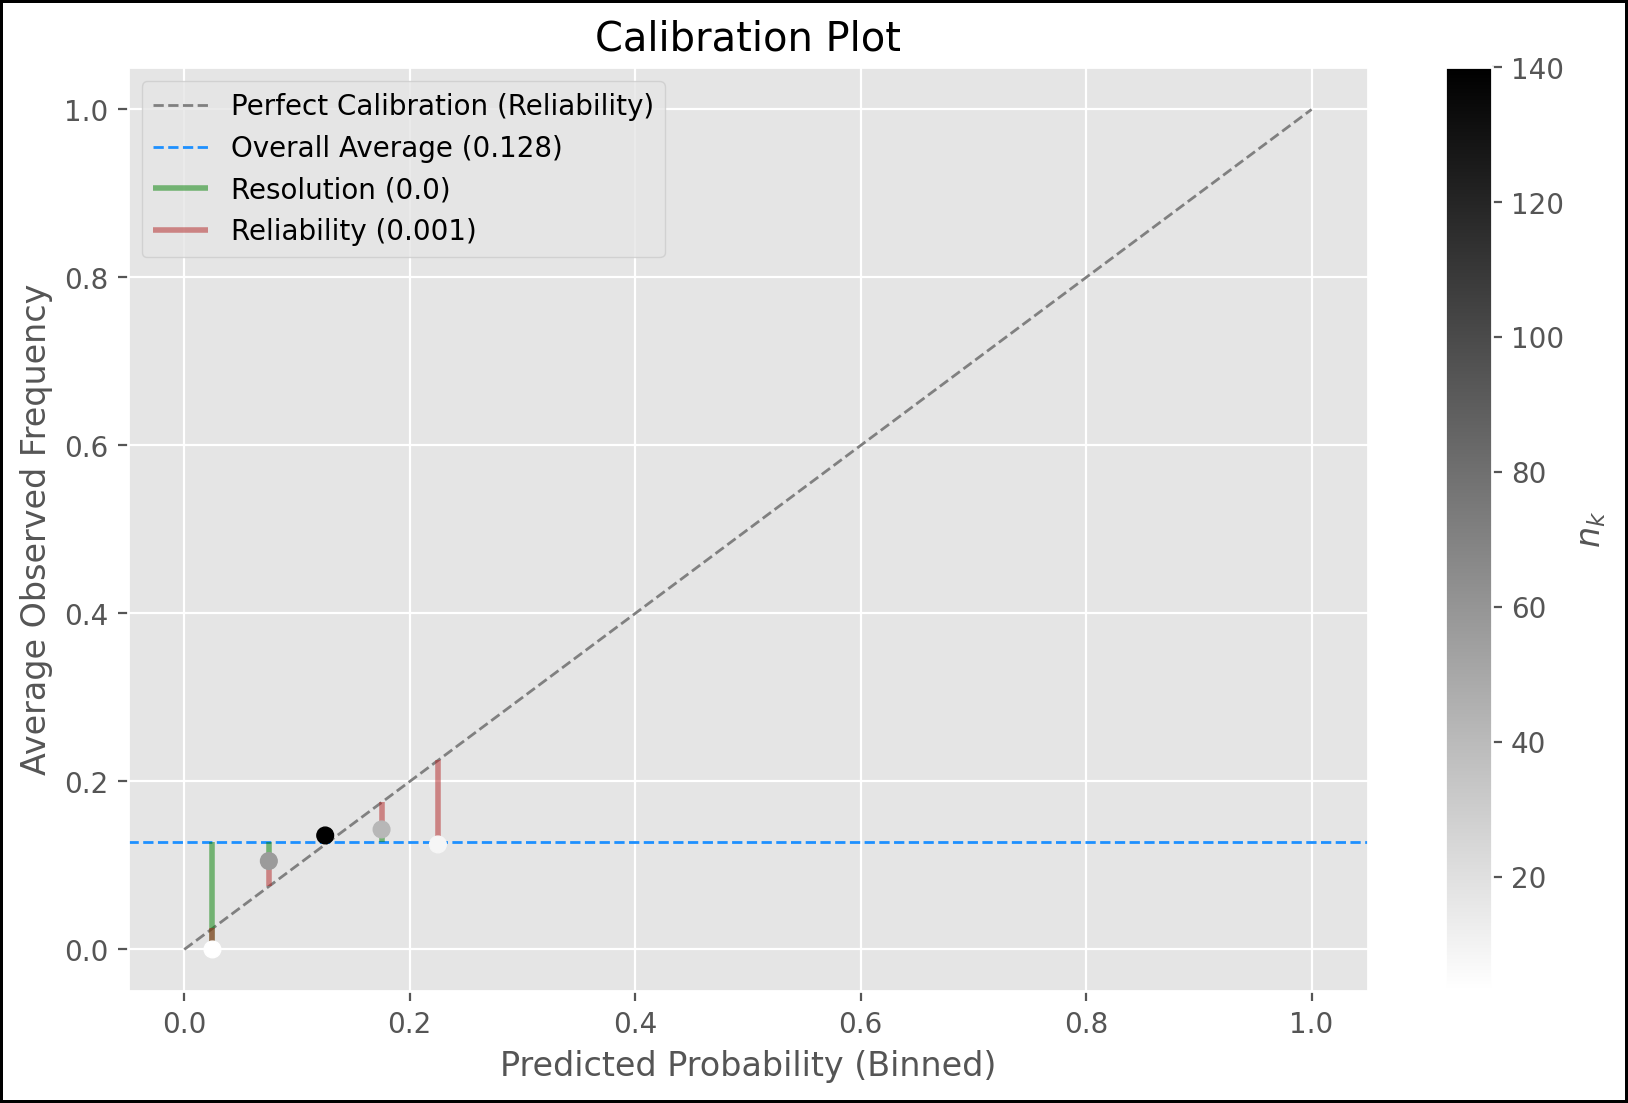

In [226]:
plot_calibration(dfg.dropna())

predicted_prob_bin  observation_mean  observation_count  predicted_prob_mean
0        (0.0, 0.05]          0.000000                  3             0.050000
1        (0.05, 0.1]          0.105263                 57             0.089298
2        (0.1, 0.15]          0.135714                140             0.130071
3        (0.15, 0.2]          0.142857                 42             0.175238
4        (0.2, 0.25]          0.125000                  8             0.218750

In [333]:
from scipy.stats import binom 
import math
from scipy import integrate
plt.style.use('seaborn-white')

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_81087/2021204282.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [345]:
def binomial(theta, n=5, w=3):

    term1 = math.factorial(n) / (math.factorial(w) * math.factorial(n - w))
    term2 = theta**w * (1 - theta)**(n-w)

    return term1 * term2

In [399]:
n = 10

In [428]:
theta_step = 0.01
thetas = np.arange(0, 1.01, theta_step)
likelihoods = [binomial(theta, n=n, w=3) for theta in thetas]
likelihoods = pd.Series(likelihoods)

ws = np.arange(0, 11, 1)
probabilities = [binomial(0.4, n=n, w=w) for w in ws]

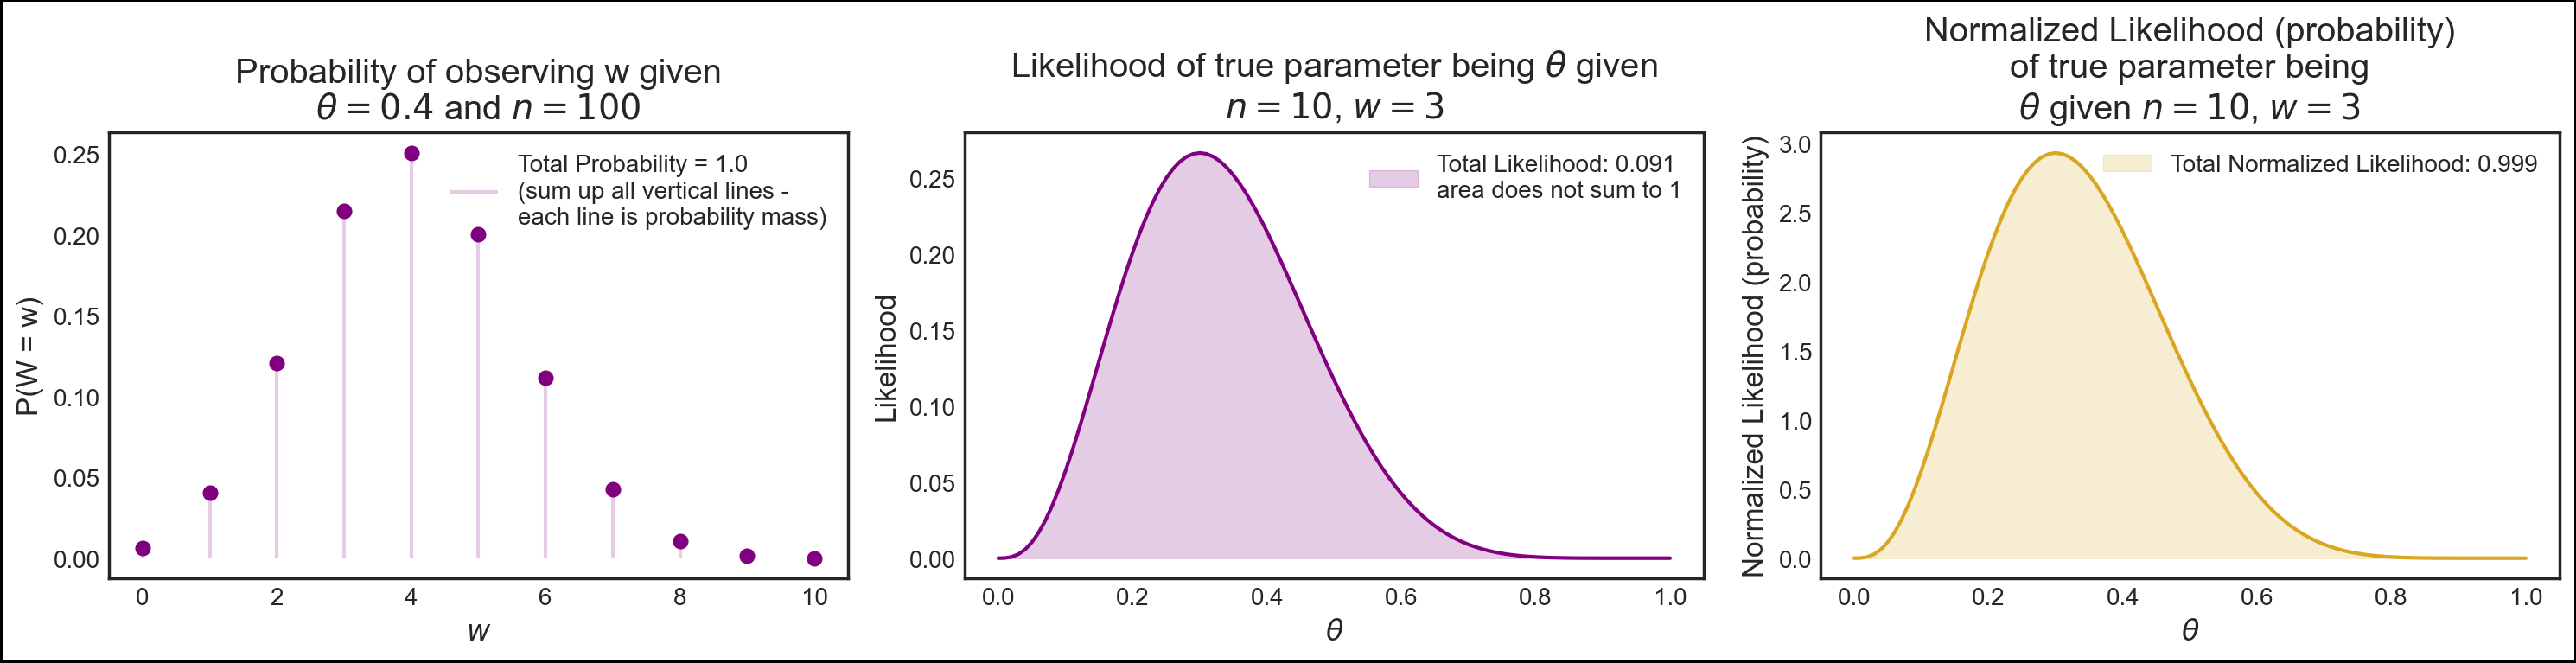

In [466]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.scatter(ws, probabilities, color='purple')
ax1.set_xlabel(r'$w$')
ax1.set_ylabel('P(W = w)')
ax1.set_title(f'Probability of observing w given\n' + r'$\theta = 0.4$ and $n=100$')
for i, (w, prob) in enumerate(zip(ws, probabilities)):
    label = f'Total Probability = {round(sum(probabilities), 2)} \n(sum up all vertical lines - \neach line is probability mass)'
    if i != 0:
        label = None
    ax1.vlines(w, 0, prob, color='purple', alpha=0.2, label=label)
ax1.legend()

total_likelihood = round(integrate.simps(likelihoods, thetas), 3)
ax2.plot(thetas, likelihoods, color='purple')
ax2.fill_between(thetas, likelihoods, np.zeros(likelihoods.values.shape), color='purple', alpha=0.2, label=f'Total Likelihood: {total_likelihood}\narea does not sum to 1')
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel('Likelihood')
ax2.set_title(r'Likelihood of true parameter being $\theta$ given' + f'\n' + r'$n=10$, $w=3$')
ax2.legend()

normalized_likelihood = likelihoods / total_likelihood
total_normalized_likelihood = round(integrate.simps(normalized_likelihood, thetas), 3)
ax3.plot(thetas, normalized_likelihood, color='goldenrod')
ax3.fill_between(thetas, normalized_likelihood, np.zeros(normalized_likelihood.values.shape), color='goldenrod', alpha=0.2, label=f'Total Normalized Likelihood: {total_normalized_likelihood}')
ax3.set_xlabel(r'$\theta$')
ax3.set_ylabel('Normalized Likelihood (probability)')
ax3.set_title(f'Normalized Likelihood (probability)\nof true parameter being\n' + r'$\theta$ given $n=10$, $w=3$')
ax3.legend()

plt.tight_layout()

fig.patch.set_edgecolor('black')  # Set border color
fig.patch.set_linewidth(2)    

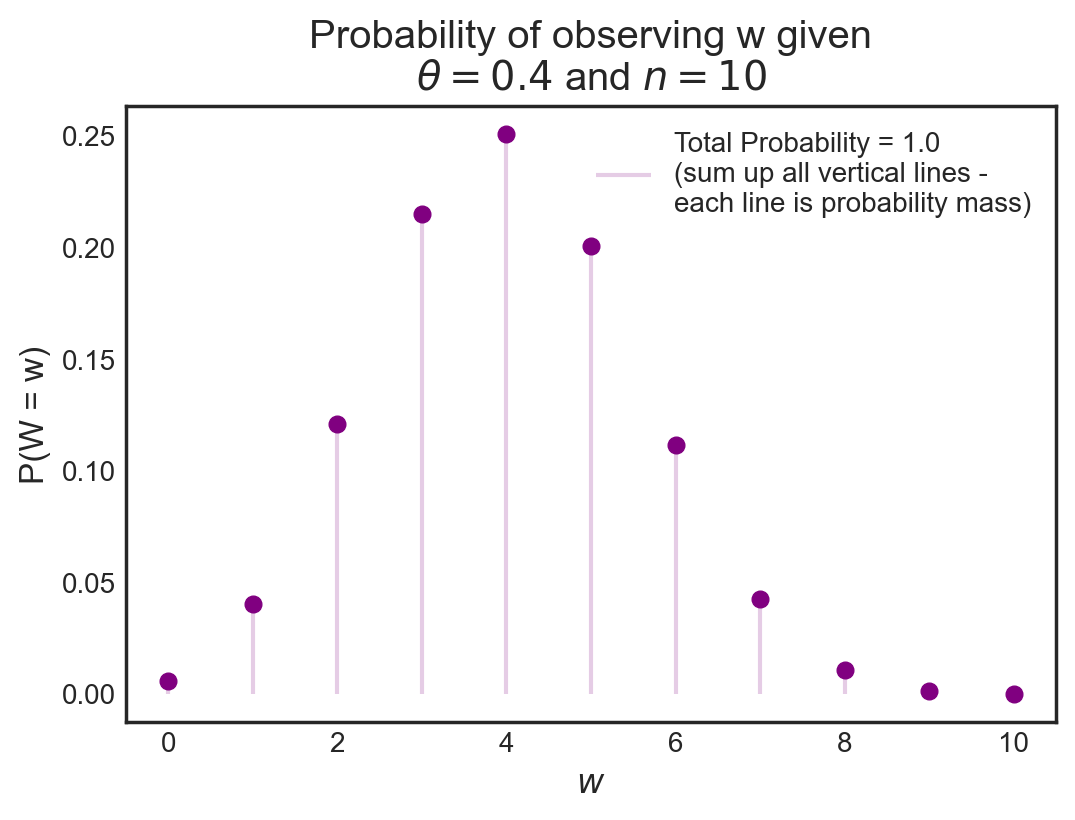

In [478]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
ax1.scatter(ws, probabilities, color='purple')
ax1.set_xlabel(r'$w$')
ax1.set_ylabel('P(W = w)')
ax1.set_title(f'Probability of observing w given\n' + r'$\theta = 0.4$ and $n=10$')
for i, (w, prob) in enumerate(zip(ws, probabilities)):
    label = f'Total Probability = {round(sum(probabilities), 2)} \n(sum up all vertical lines - \neach line is probability mass)'
    if i != 0:
        label = None
    ax1.vlines(w, 0, prob, color='purple', alpha=0.2, label=label)
ax1.legend()


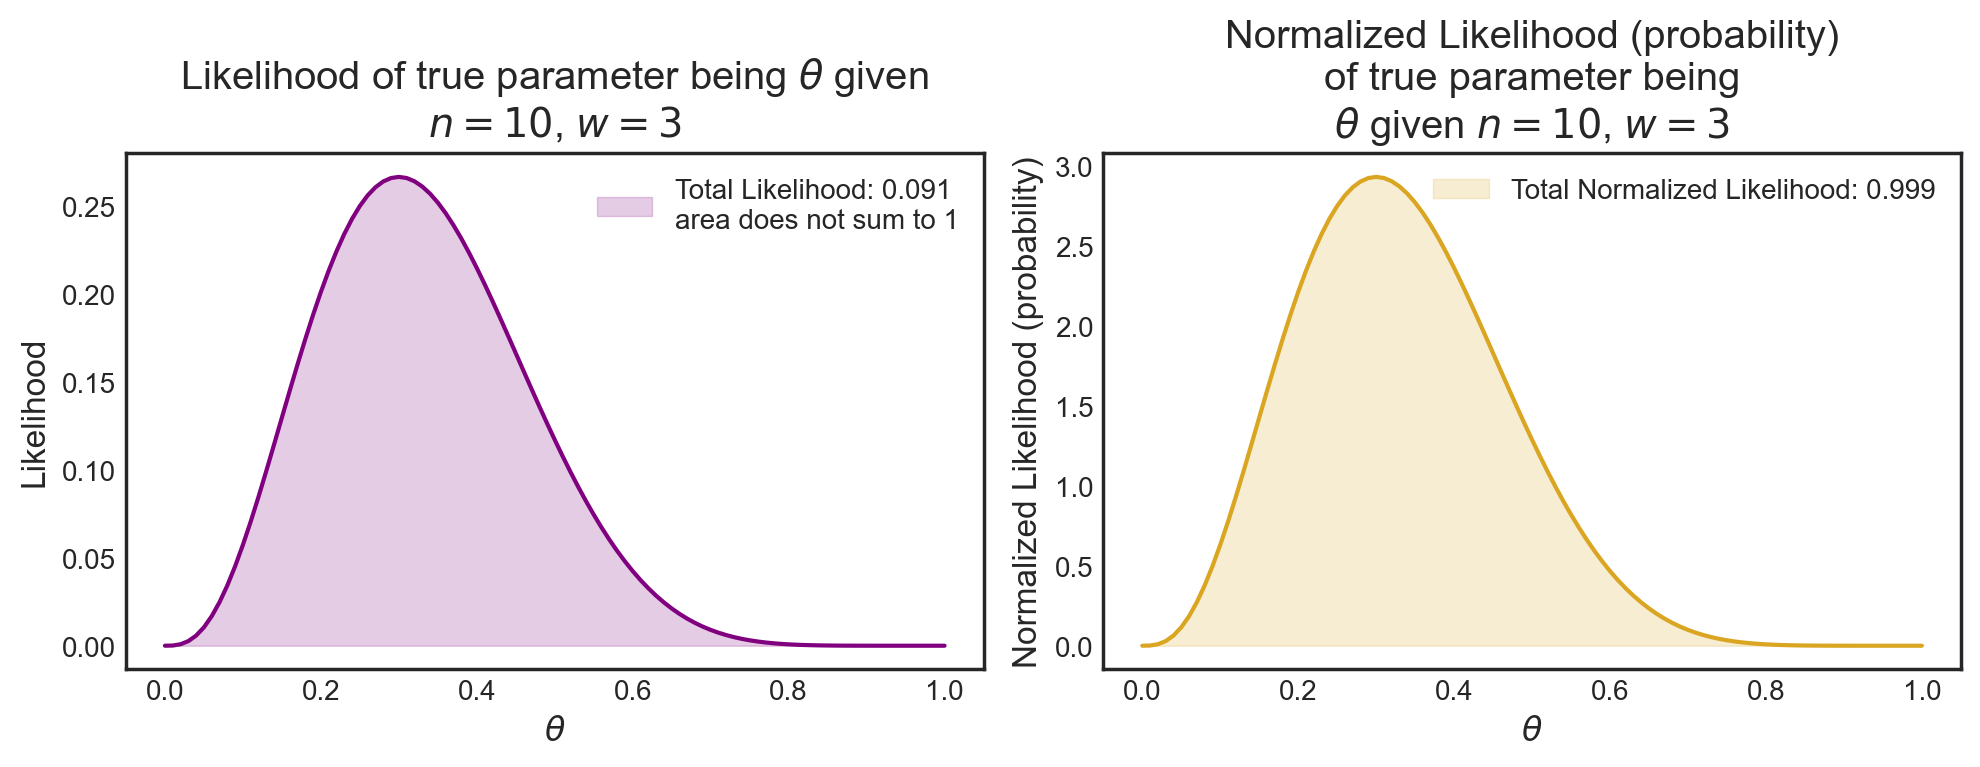

In [475]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 4))
total_likelihood = round(integrate.simps(likelihoods, thetas), 3)
ax2.plot(thetas, likelihoods, color='purple')
ax2.fill_between(thetas, likelihoods, np.zeros(likelihoods.values.shape), color='purple', alpha=0.2, label=f'Total Likelihood: {total_likelihood}\narea does not sum to 1')
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel('Likelihood')
ax2.set_title(r'Likelihood of true parameter being $\theta$ given' + f'\n' + r'$n=10$, $w=3$')
ax2.legend()

normalized_likelihood = likelihoods / total_likelihood
total_normalized_likelihood = round(integrate.simps(normalized_likelihood, thetas), 3)
ax3.plot(thetas, normalized_likelihood, color='goldenrod')
ax3.fill_between(thetas, normalized_likelihood, np.zeros(normalized_likelihood.values.shape), color='goldenrod', alpha=0.2, label=f'Total Normalized Likelihood: {total_normalized_likelihood}')
ax3.set_xlabel(r'$\theta$')
ax3.set_ylabel('Normalized Likelihood (probability)')
ax3.set_title(f'Normalized Likelihood (probability)\nof true parameter being\n' + r'$\theta$ given $n=10$, $w=3$')
ax3.legend()

plt.tight_layout()



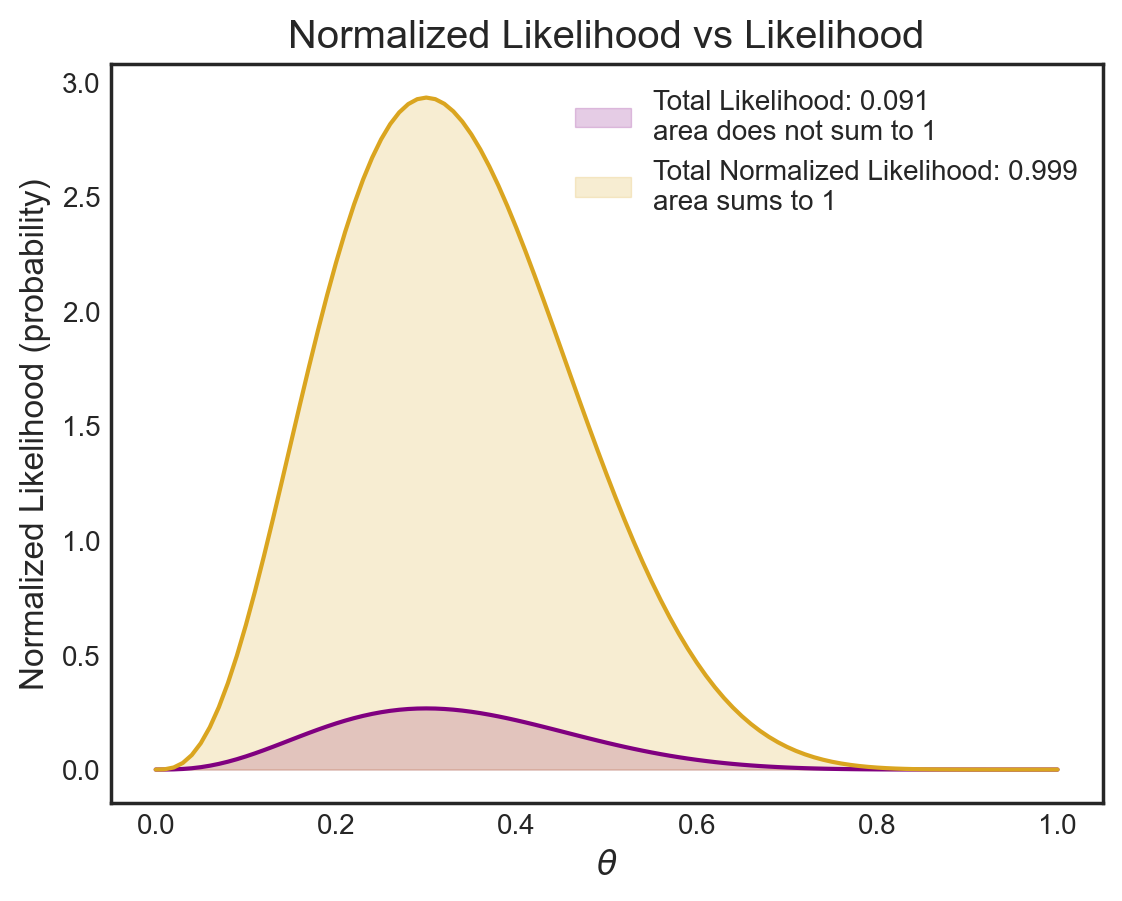

In [477]:
plt.plot(thetas, likelihoods, color='purple')
plt.fill_between(thetas, likelihoods, np.zeros(likelihoods.values.shape), color='purple', alpha=0.2, label=f'Total Likelihood: {total_likelihood}\narea does not sum to 1')

plt.plot(thetas, normalized_likelihood, color='goldenrod')
plt.fill_between(thetas, normalized_likelihood, np.zeros(normalized_likelihood.values.shape), color='goldenrod', alpha=0.2, label=f'Total Normalized Likelihood: {total_normalized_likelihood}\narea sums to 1')

plt.xlabel(r'$\theta$')
plt.ylabel('Normalized Likelihood (probability)')
plt.title(f'Normalized Likelihood vs Likelihood')
plt.legend()


In [462]:
().sum() * theta_step

AttributeError: 'tuple' object has no attribute 'sum'

Text(0.5, 1.0, 'Likelihood of true parameter being $\\theta$ given $n=10$, $w=3$')

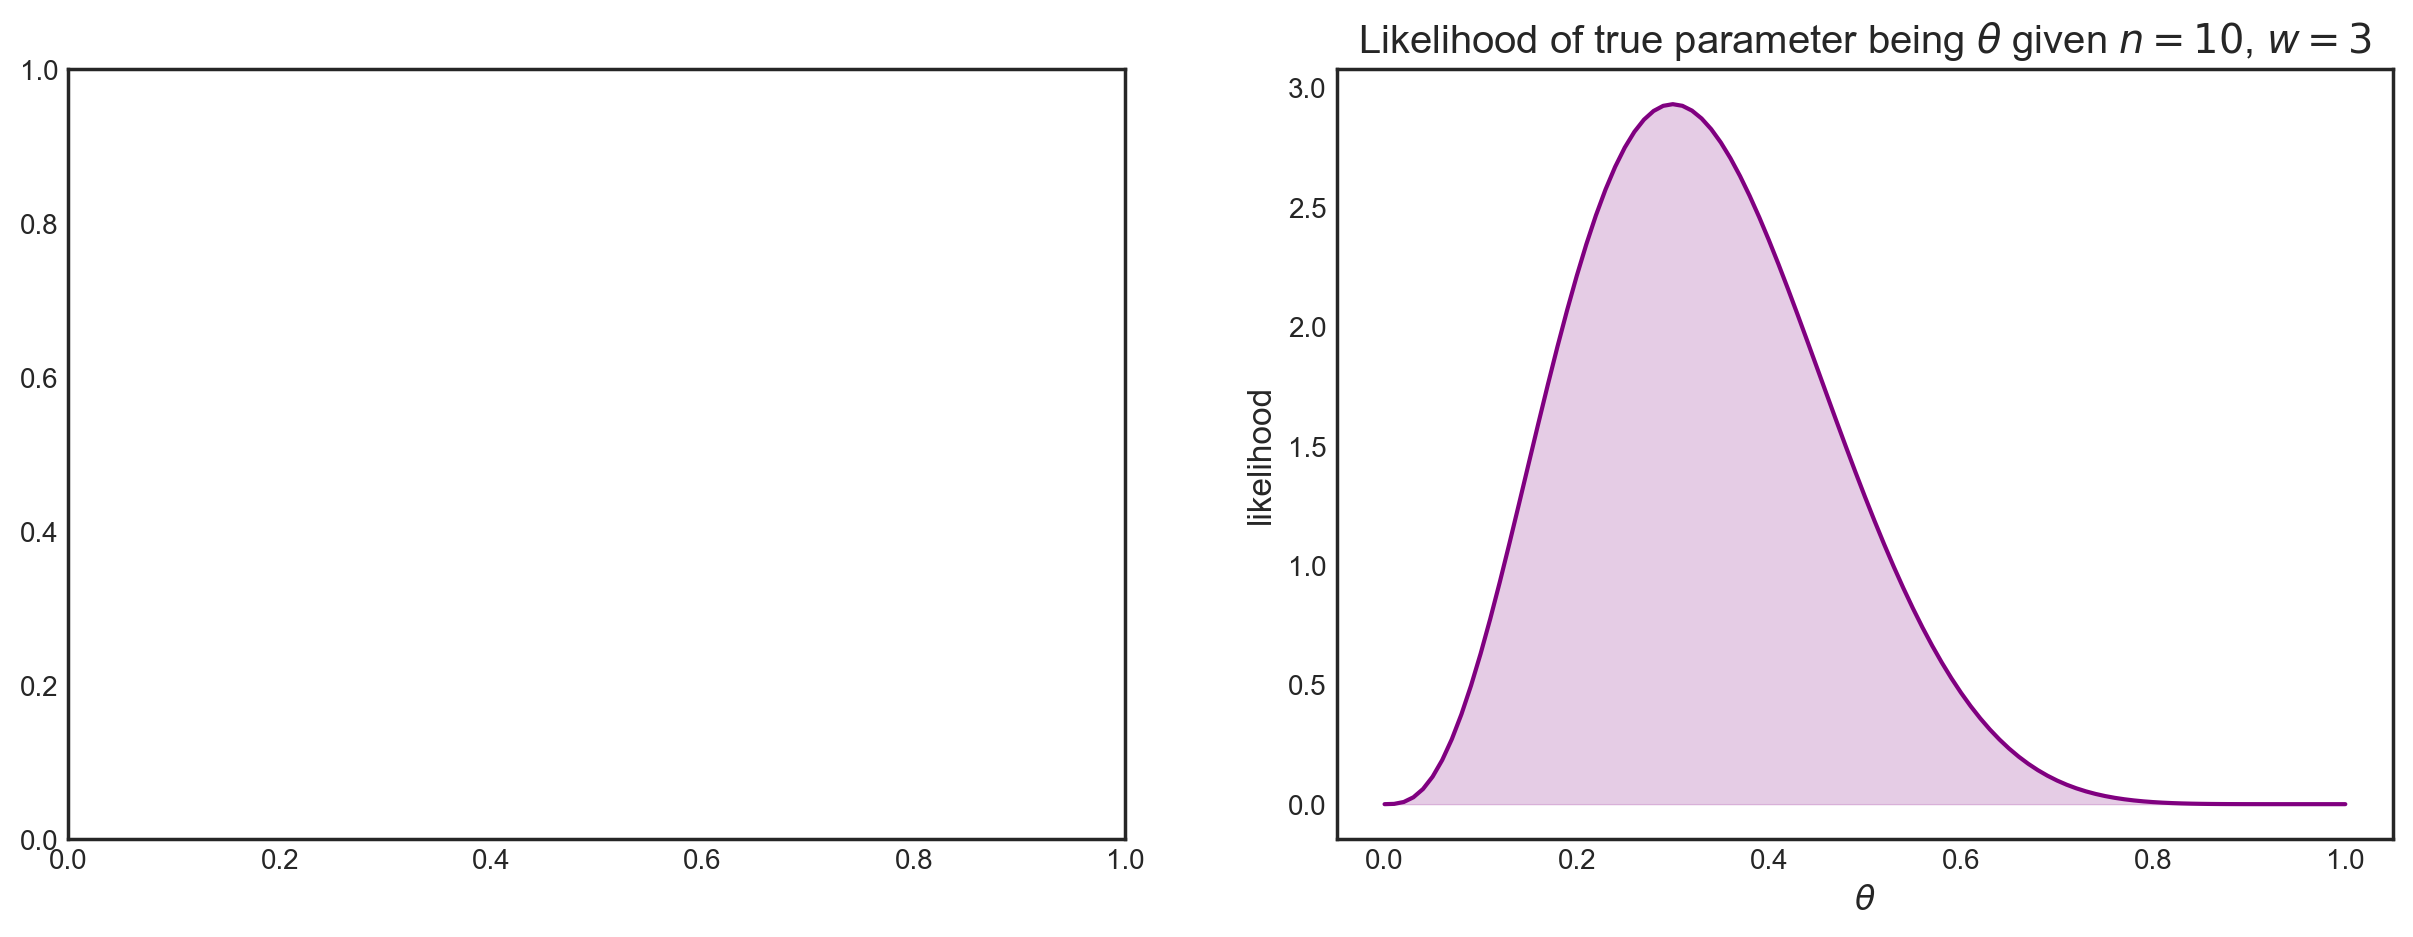

In [435]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))




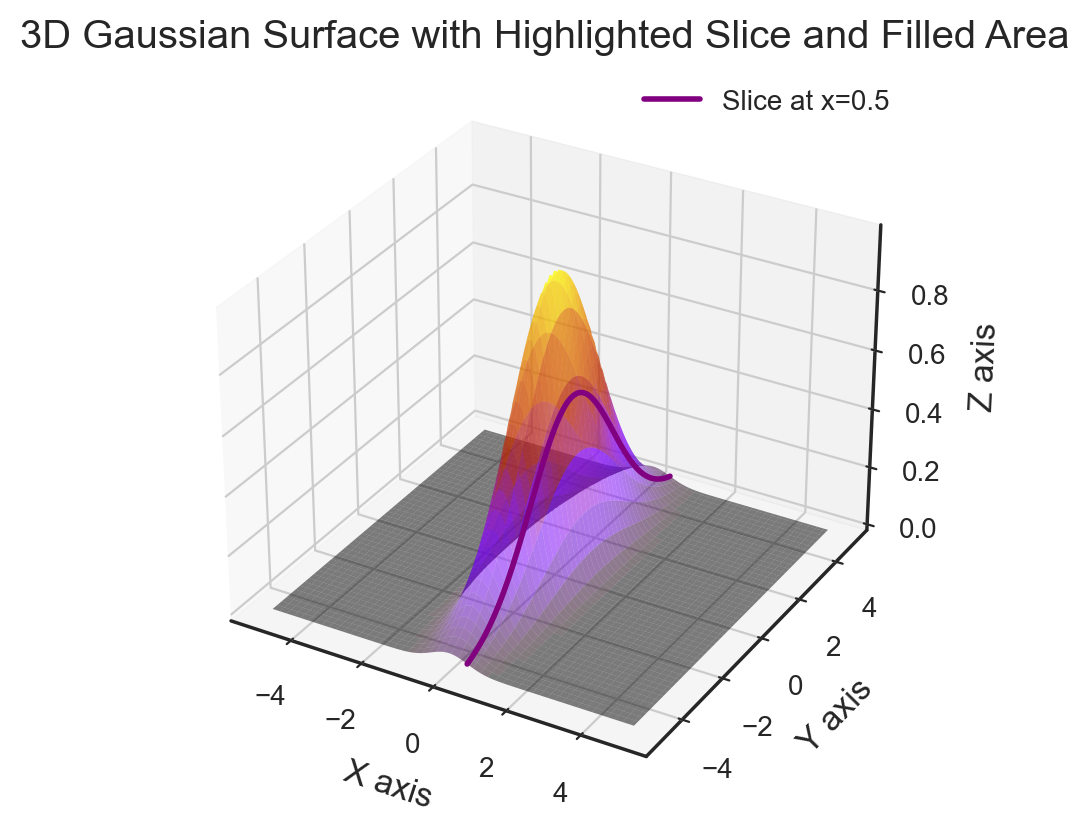

In [515]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian(x, y, A, mu_x, mu_y, sigma_x, sigma_y):
    return A * np.exp(-((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))

# Parameters for the Gaussian
A = 1  # Amplitude
mu_x = 0
mu_y = 0
sigma_x = 0.5
sigma_y = 2

# Generate X and Y grids
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Generate Z values based on the Gaussian function
Z = gaussian(X, Y, A, mu_x, mu_y, sigma_x, sigma_y)

# Compute Z values for the slice where x = 1
x_slice = 0.5
Z_slice = gaussian(x_slice, y, A, mu_x, mu_y, sigma_x, sigma_y)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='gnuplot', alpha=0.5) # Added transparency to the surface plot for better visibility

# Plot the slice
ax.plot3D(np.full(y.shape, x_slice), y, Z_slice, color='purple', linewidth=2, label='Slice at x=0.5')


# Compute Z values for the slice where x = 1
y_slice = 2
Z_slice = gaussian(x, y_slice, A, mu_x, mu_y, sigma_x, sigma_y)

# Plot the slice
# ax.plot3D(x, np.full(x.shape, y_slice), Z_slice, color='red', linewidth=2, label='Slice at x=1')


# Customize the plot
ax.set_title('3D Gaussian Surface with Highlighted Slice and Filled Area')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Display the plot
plt.show()


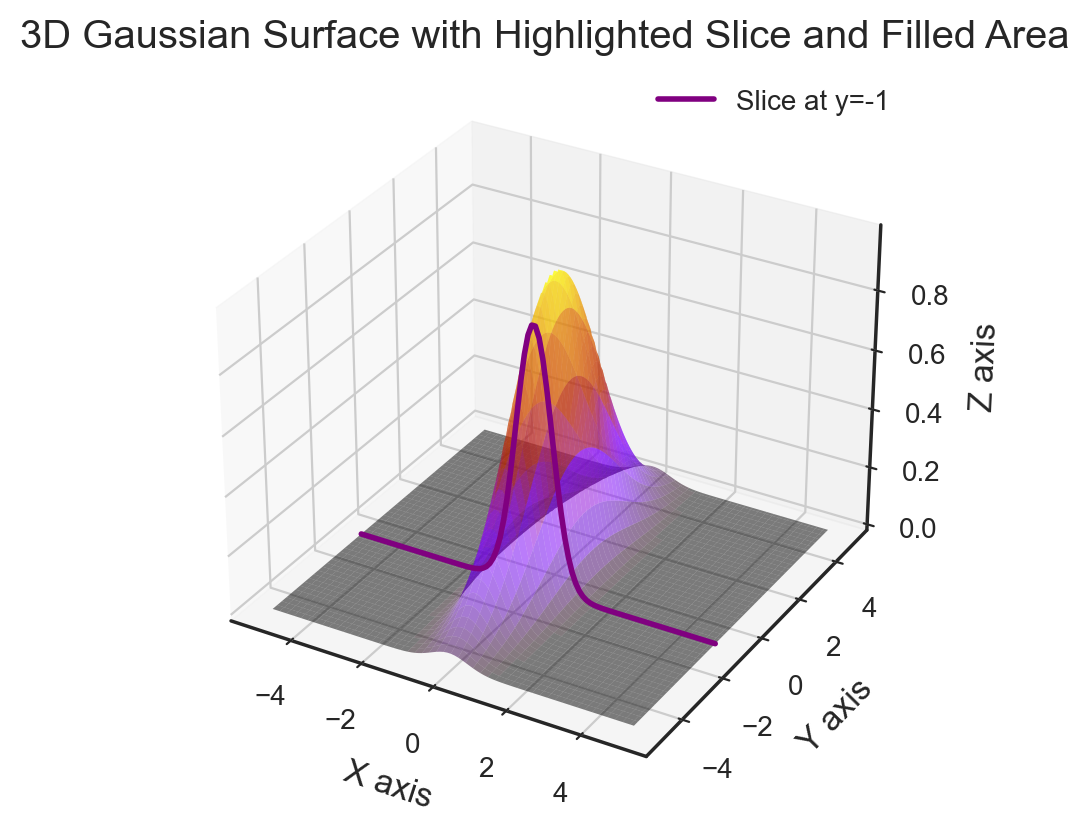

In [514]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian(x, y, A, mu_x, mu_y, sigma_x, sigma_y):
    return A * np.exp(-((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))

# Parameters for the Gaussian
A = 1  # Amplitude
mu_x = 0
mu_y = 0
sigma_x = 0.5
sigma_y = 2

# Generate X and Y grids
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Generate Z values based on the Gaussian function
Z = gaussian(X, Y, A, mu_x, mu_y, sigma_x, sigma_y)

# Compute Z values for the slice where x = 1
x_slice = 0.5
Z_slice = gaussian(x_slice, y, A, mu_x, mu_y, sigma_x, sigma_y)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='gnuplot', alpha=0.5)  # Added transparency to the surface plot for better visibility

# Plot the slice
# ax.plot3D(np.full(y.shape, x_slice), y, Z_slice, color='red', linewidth=2, label='Slice at x=1')


# Compute Z values for the slice where x = 1
y_slice = -1
Z_slice = gaussian(x, y_slice, A, mu_x, mu_y, sigma_x, sigma_y)

# Plot the slice
ax.plot3D(x, np.full(x.shape, y_slice), Z_slice, color='purple', linewidth=2, label='Slice at y=-1')


# Customize the plot
ax.set_title('3D Gaussian Surface with Highlighted Slice and Filled Area')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Display the plot
plt.show()
